In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
sys.path.append('../python/')

#matplotlib for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.style.use('../mplstyles/stylelib/standard.mplstyle')

#other computational libraries
import numpy as np
import pandas as pd
import scipy
import scipy.constants as co
import scipy.stats as ss
import scipy.signal as sig
from scipy.signal import find_peaks
from scipy.ndimage import shift
import itertools
import pickle
from pathlib import Path

from lmfit.models import GaussianModel, LinearModel

In [2]:
import pickle
#how to read
#fileObj = open('data/r76-80V-naitrig-100eV-goodchi.pkl', 'rb')
fileObj = open('data/r76_events_coincidencepeak_LE.pkl', 'rb')
exampleObj = pickle.load(fileObj)
fileObj.close()

print(exampleObj)

                                                                    Z1  \
                                                                    QI   
72209162200 20309    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            40339    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            50269    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60108    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            60849    [65532, 65532, 65532, 65532, 65532, 65532, 655...   
...                                                                ...   
72209172155 2020326  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2020591  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2030429  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060050  [65532, 65532, 65532, 65532, 65532, 65532, 655...   
            2060679  [65532, 65532, 65532, 65532, 65532, 65532, 655...   

                                     

In [3]:
import statistics as st
def isRailed(v):
    if(np.isnan(v).any()):
        return True
    if(st.mode(v)==0):
        return True
    return False

In [4]:
#import singularity_pulseSave as sps
import pulseAnalysis as pa

pulse_struct = pa.parseEventList('../coin_analysis/data/r76-coinpeak-lt-50keV.txt')

#pulse_struct = sps.parseEventList('../coin_analysis/data/r76_events_coincidencepeak.txt')

   SeriesNumber  EventNumber
0   72209162200        20309
1   72209162200        40339
2   72209162200        50269
3   72209162200        60108
4   72209162200        60849
5   72209162200        80307
6   72209162200       100246
7   72209162200       110588
8   72209162200       110617
9   72209162200       120647
[72209162200 72209171225 72209172155]
[  20309   40339   50269   60108   60849   80307  100246  110588  110617
  120647  120688  130460  140628  150823  160296  170423  180002  180423
  230432  240270  270221  340151  340912  380054  380186  390511  420391
  420816  430710  440168  480387  480389  500725  520930  540170  540903
  550322  560707  560931  570415  580008  580723  590121  610172  610663
  610684  640653  650751  670228  670650  690338  710437  740337  750334
  750490  760179  770287  780145  780259  780278  780628  800530  810923
  820568  840012  840222  850265  860663  880573  880913  910282  920809
  920948  930239  930872  940631  950888  960920  970767 10

In [5]:
coindata = pd.read_csv("../coin_analysis/data/r76_events_coincidencepeak.txt", skiprows=3, engine='python',skipfooter=1,sep="*",skipinitialspace=True, \
            index_col=False, \
            names=['garbage','Row','SeriesNumber','EventNumber','PTOFdelay','pt_keVee'], \
            delim_whitespace=False)

series_nums = np.asarray(coindata['SeriesNumber'])
event_nums = np.asarray(coindata['EventNumber'])
EkeV = np.asarray(coindata['pt_keVee'])
PTOFdelay = np.asarray(coindata['PTOFdelay'])

def getEnergy(series,ev):
    energy = 0

    for i in range(0, len(series_nums)):
        if series_nums[i] == series:
            if event_nums[i] == ev:
                energy = (EkeV[i])
    return energy

# ax1.fill_between(np.arange(0, best_cross + 1), bshifted_pT[:best_cross + 1], 0, color='gray', alpha=0.5)
                
              #      area = np.trapz(bshifted_pT[:best_cross + 1], dx=1)
                #    print("Area:", area)
def getPTPulse(pulses,series=72209162200,ev=20309,chan=[('Z1','PA'),('Z1','PB'),('Z1','PD'),('Z3','PA'),('Z3','PB'),('Z3','PD')]):
    ptpulse=[]
    ccount=0
    for c in chan:
        #print(c[0])
        pulse = pulses[c[0]][c[1]][series,ev]
        if(isRailed(pulse)):
            continue
        mean = np.mean(pulse[100:])
        #print(mean)
        pulse = pulse-mean
        #print(pulse)
        #print(np.size(ptpulse))
        if(ccount==0):
            ptpulse=pulse
        else:
            ptpulse+=pulse
        ccount+=1
        
    return ptpulse


def getPTPulseCD(pulses,series=72209162200,ev=20309):
    
    pulse = getPTPulse(pulses, series, ev)

    #adding discriminator
    D = 100

    end_values = pulse[3997:]
    
    CD_pulse = shift(pulse, D, cval=np.nan)

    #adding the cut off values to the front of the new pulse
    CD_pulse[0:99] = end_values
    #print(new_pulse)
        
    return CD_pulse

def getBadBL(obj, series=72209162200, ev=20309):
    pT = getPTPulseCD(obj,ser,ev)+3000
    baseline = getBaseline(pT)
    xB = np.linspace(0, 4095, 4096)
    yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
    bshifted_pT = np.subtract(pT,yB)
    asdf = np.linspace(150, 300) 
    asdfg = bshifted_pT[np.round(asdf).astype(int)]  
    asdf1 = np.linspace(3000, 3500)
    asdfg1 = bshifted_pT[np.round(asdf1).astype(int)]  
    lowBinAvg = np.mean(asdfg)
    #print("lo avg", lowBinAvg)
    hiBinAvg = np.mean(asdfg1)
    #print("hi avg", hiBinAvg)
    if ((hiBinAvg - lowBinAvg) > 700) or ((hiBinAvg - lowBinAvg)<-170):#upsloping/downsloping bl should have different thrs
        return True
    else:
        return False
        

def getBaseline(ptpulse):
    
    x = np.linspace(100, 250, 150)
    #print(len(x))
    y = ptpulse[100:250]
    #print(len(y))
    
    #print(x)
    #print(y)
    
    baseline_model = np.polyfit(x, y, 1)
    baseline_model_fn = np.poly1d(baseline_model)
    
    return(baseline_model_fn)


Series Number: 72209162200
Event Number: 380186
Energy: 8.165548711592 keV


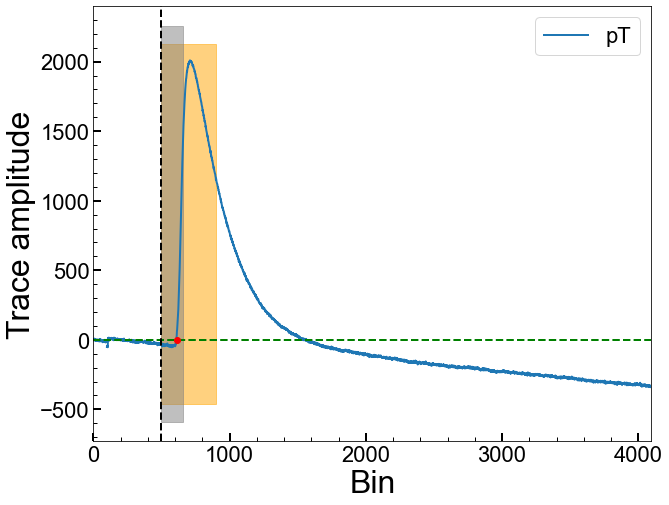

Series Number: 72209162200
Event Number: 480389
Energy: 14.79957140929 keV


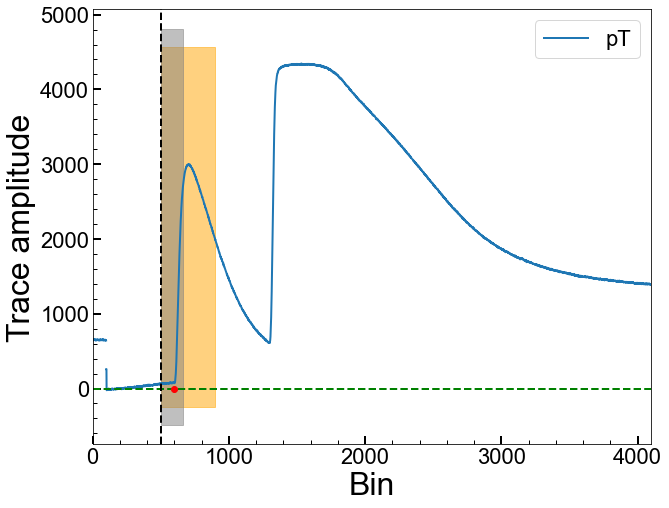

Series Number: 72209162200
Event Number: 640653
Energy: 10.43226269511 keV


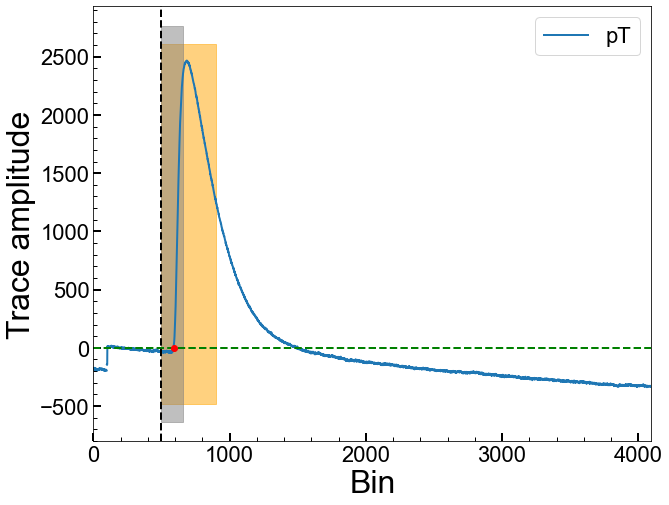

Series Number: 72209162200
Event Number: 670650
Energy: 2.05105148157 keV


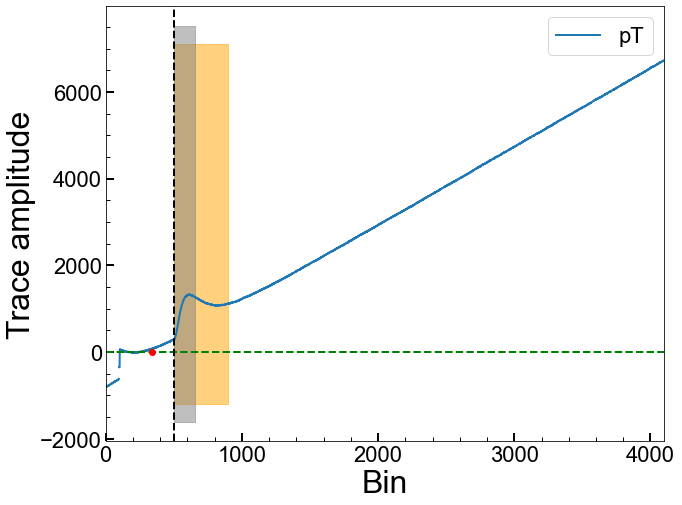

Series Number: 72209162200
Event Number: 750334
Energy: 7.153684944725 keV


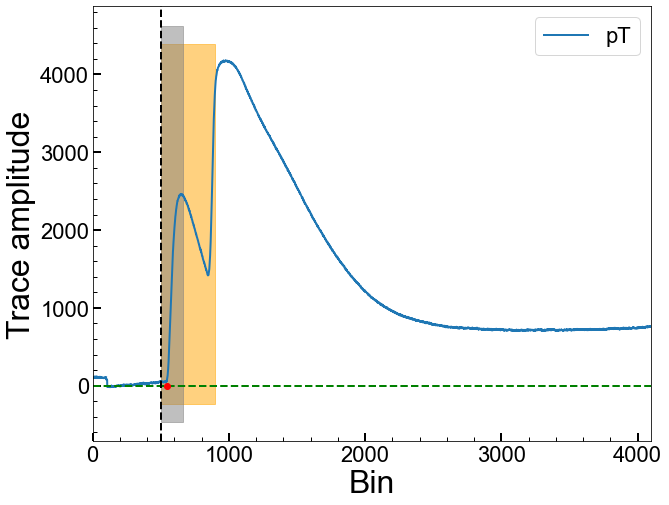

Series Number: 72209162200
Event Number: 920948
Energy: 3.558577288045 keV


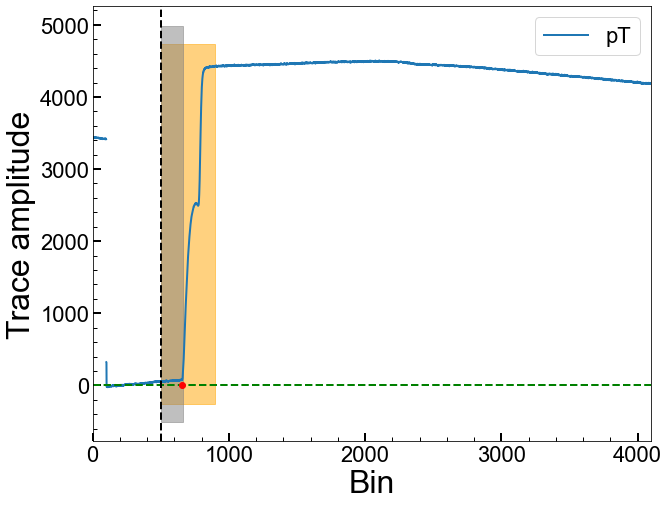

Series Number: 72209162200
Event Number: 1100492
Energy: 12.69641815982 keV


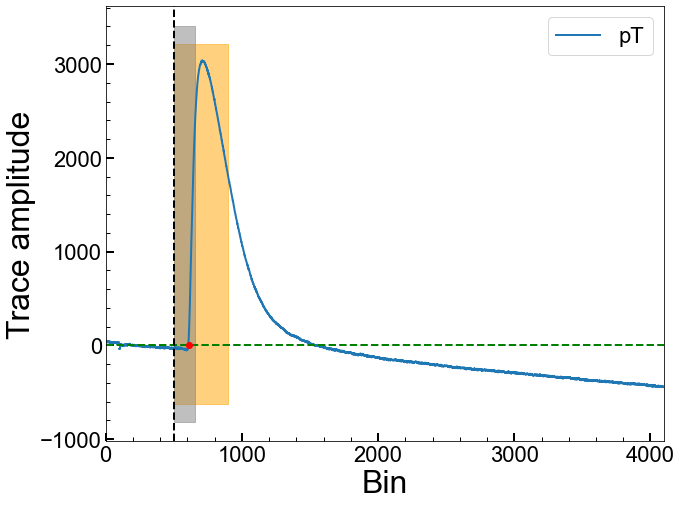

Series Number: 72209162200
Event Number: 1290407
Energy: 10.87202261475 keV


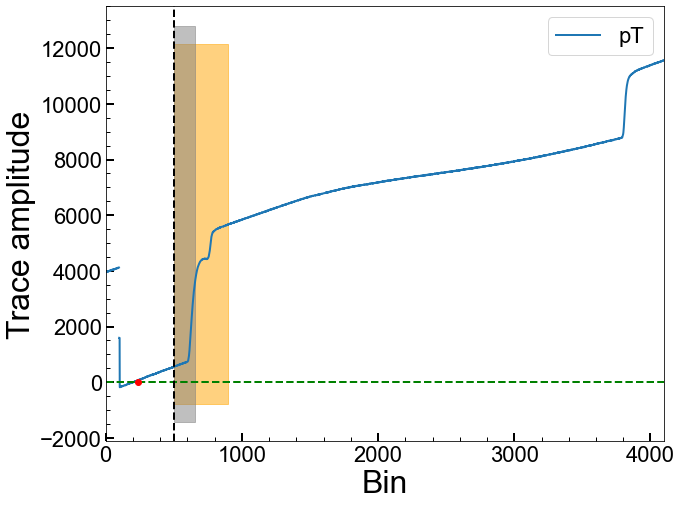

Series Number: 72209162200
Event Number: 1490368
Energy: 3.477842194456 keV


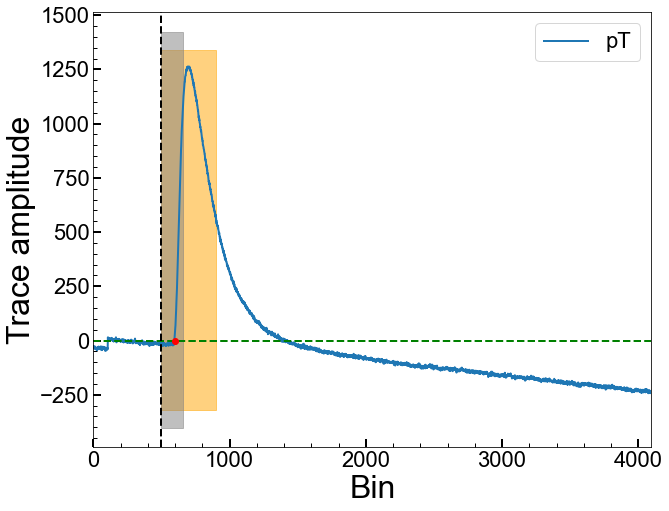

Series Number: 72209162200
Event Number: 1750806
Energy: 10.7876630878 keV


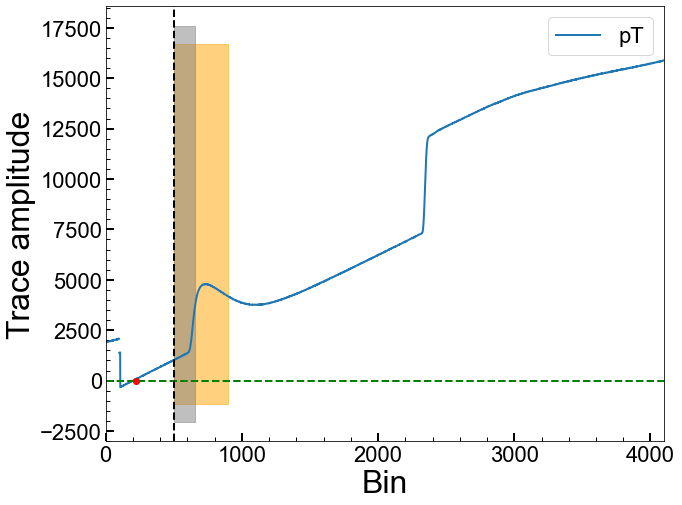

Series Number: 72209162200
Event Number: 1770687
Energy: 13.81211076139 keV


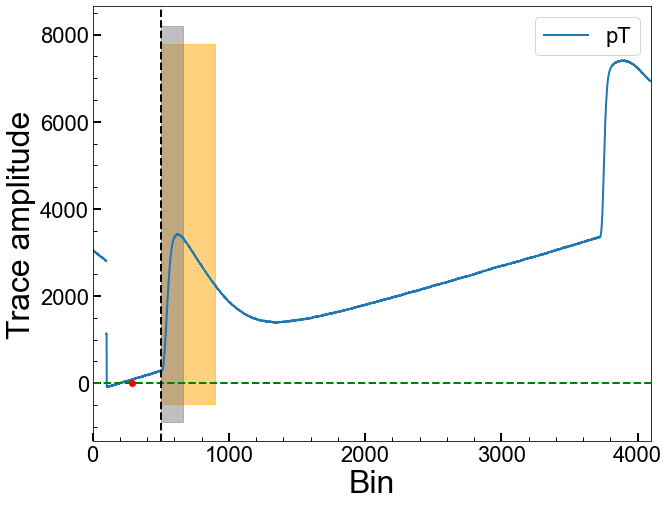

Series Number: 72209162200
Event Number: 1780723
Energy: 8.969939237865 keV


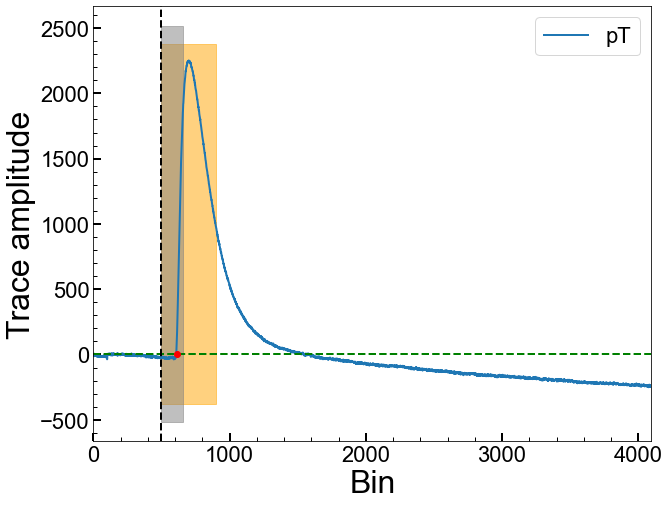

Series Number: 72209162200
Event Number: 1810683
Energy: 5.907500590198 keV


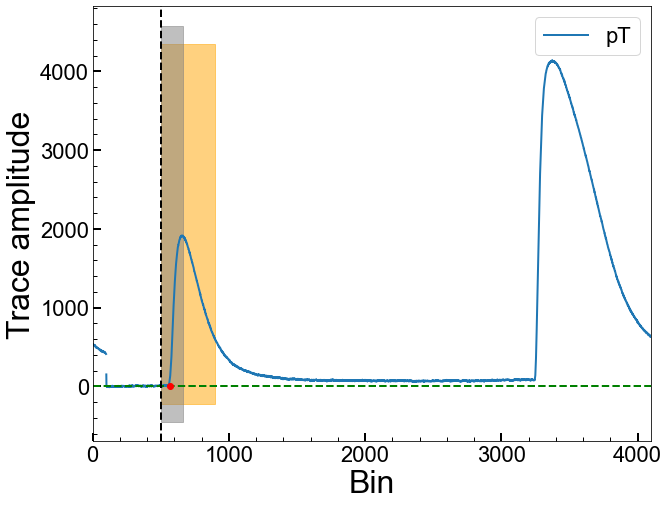

Series Number: 72209162200
Event Number: 1870496
Energy: 13.5059221535 keV


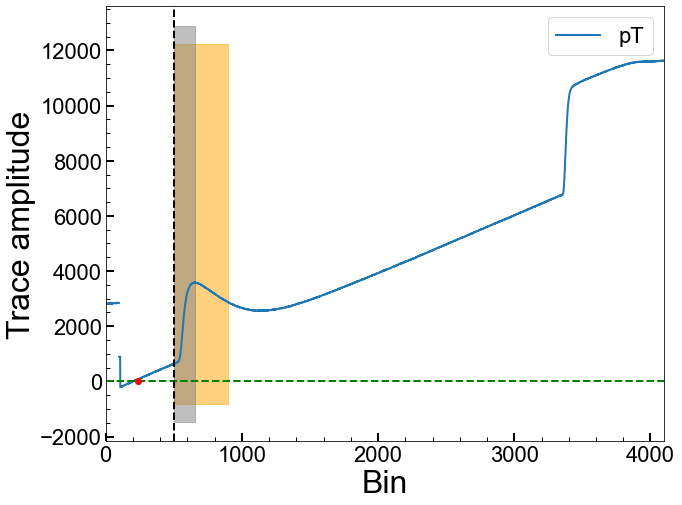

Series Number: 72209162200
Event Number: 1890196
Energy: 2.217073508668 keV


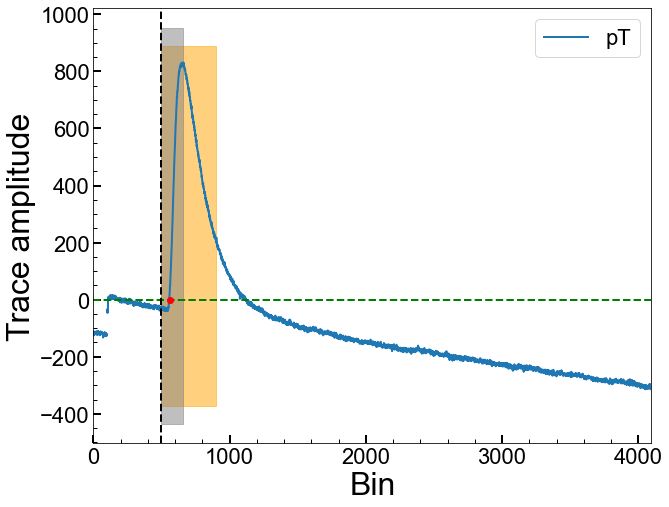

Series Number: 72209162200
Event Number: 2040143
Energy: 14.80179940773 keV


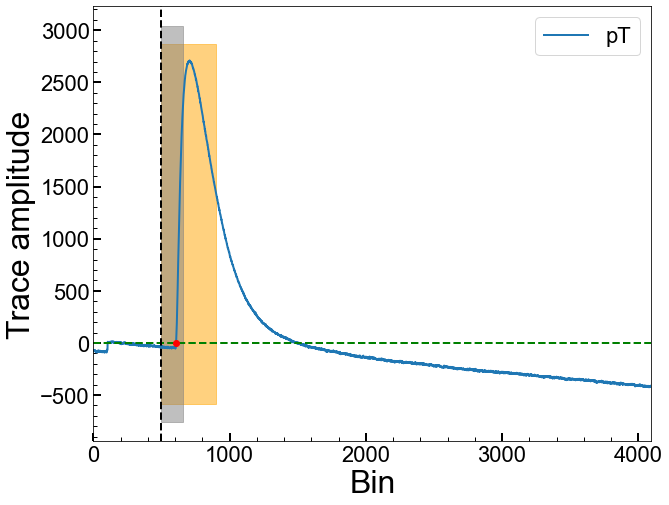

Series Number: 72209162200
Event Number: 2120672
Energy: 2.945185163492 keV


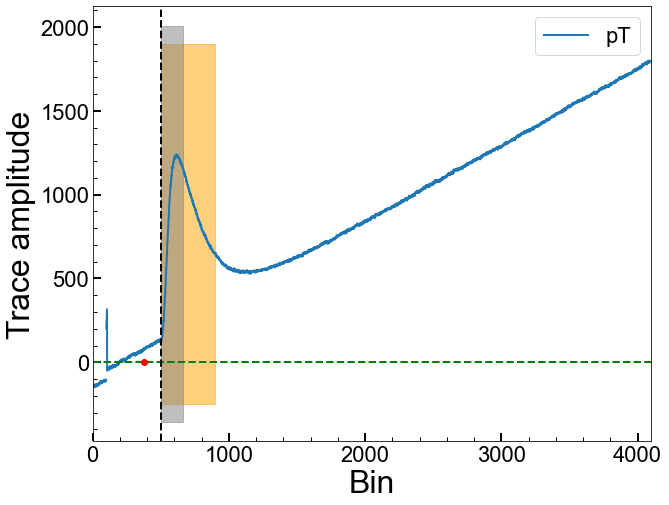

Series Number: 72209162200
Event Number: 2200105
Energy: 11.28999911897 keV


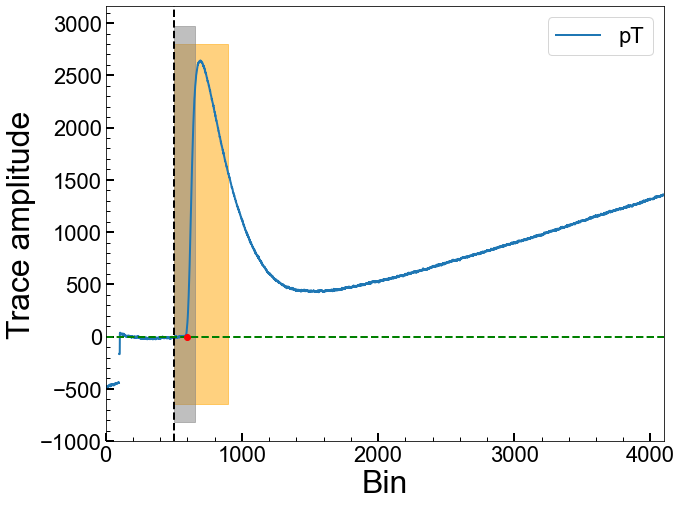

Series Number: 72209162200
Event Number: 2600244
Energy: 7.59569897403 keV


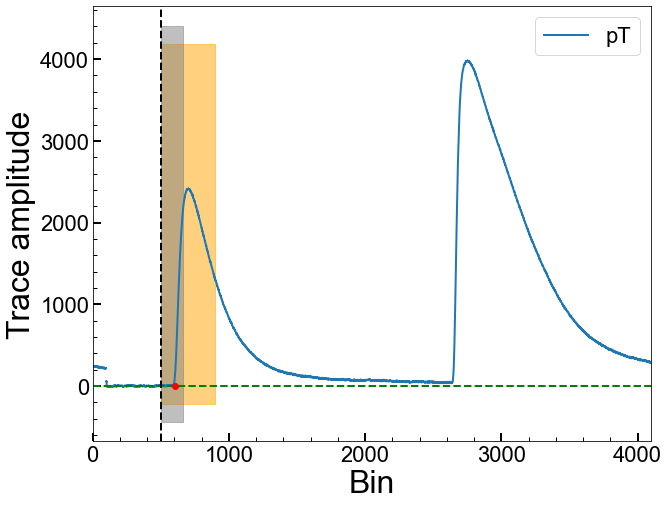

Series Number: 72209162200
Event Number: 2680389
Energy: 2.829655200786 keV


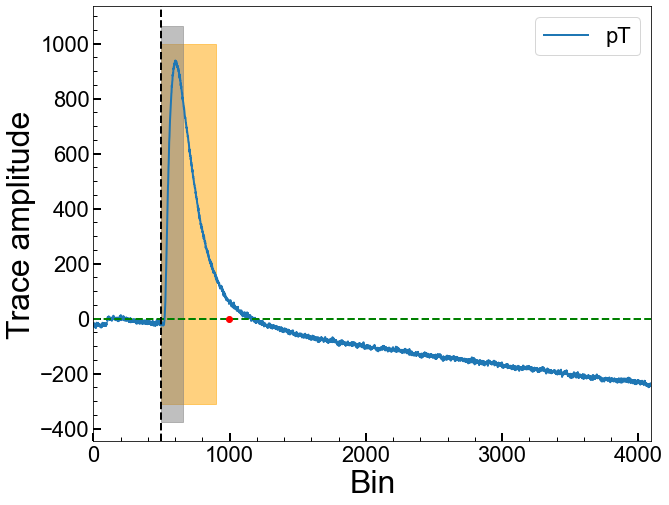

Series Number: 72209162200
Event Number: 2840820
Energy: 13.78981823399 keV


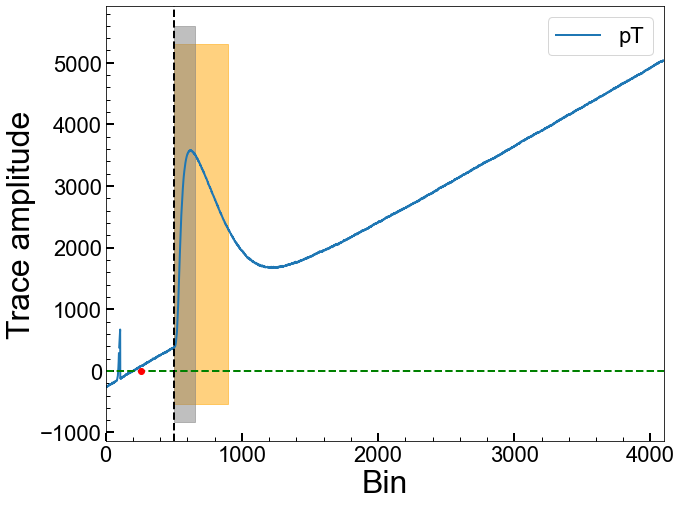

Series Number: 72209162200
Event Number: 2850462
Energy: 12.63805420814 keV


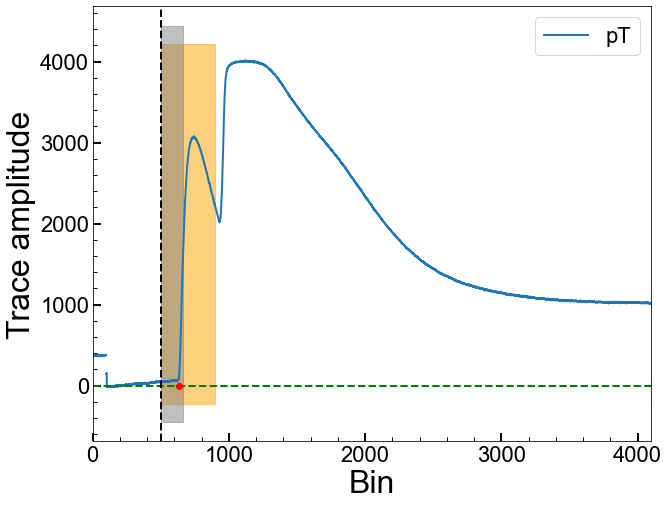

Series Number: 72209162200
Event Number: 2940033
Energy: 6.021992545616 keV


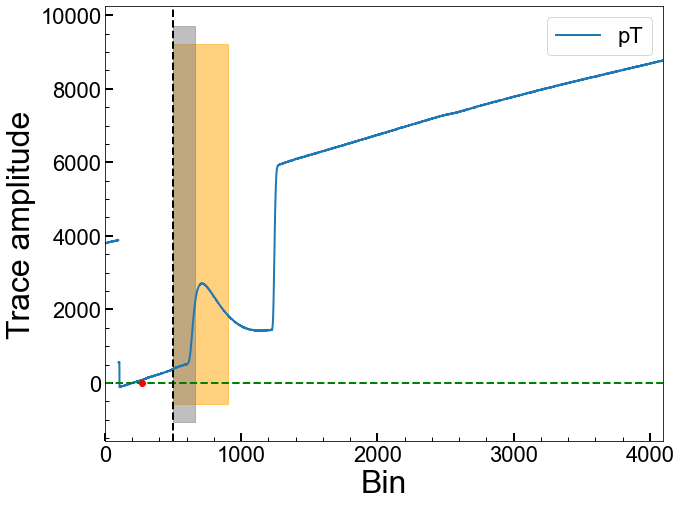

Series Number: 72209162200
Event Number: 3270617
Energy: 6.065410078106 keV


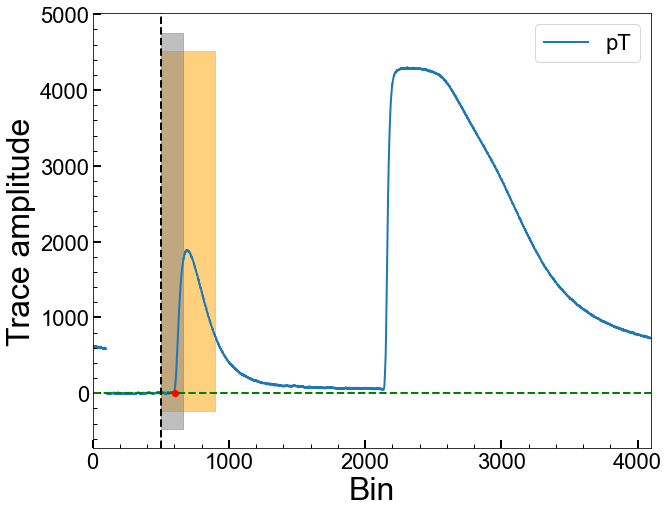

Series Number: 72209162200
Event Number: 3270905
Energy: 2.899360129374 keV


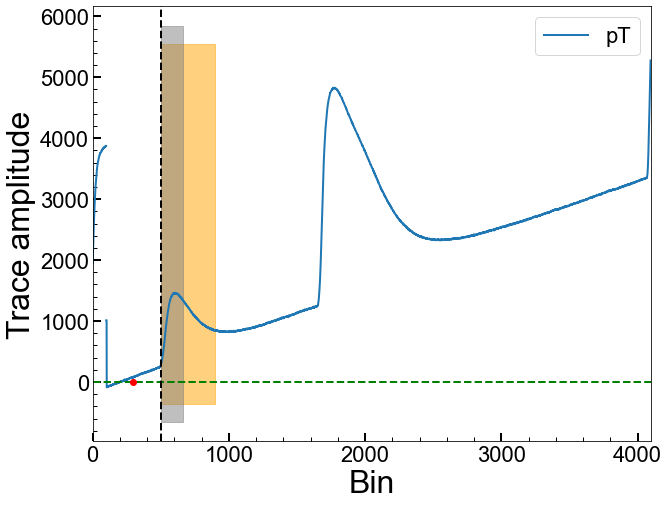

Series Number: 72209162200
Event Number: 3350178
Energy: 13.57077681298 keV


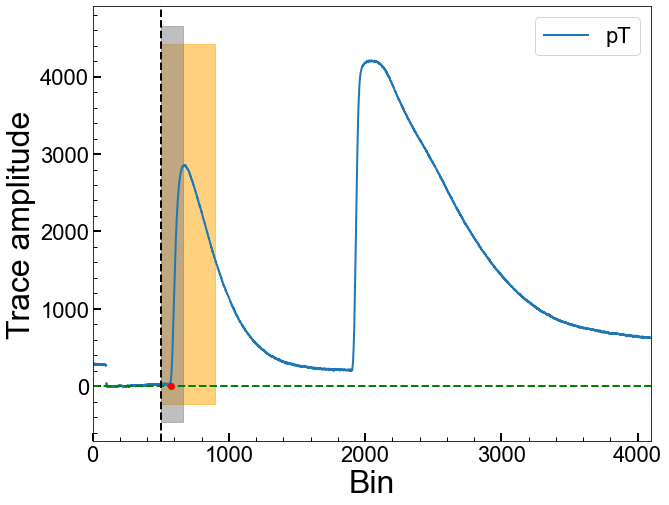

Series Number: 72209162200
Event Number: 3350723
Energy: 4.288947706303 keV


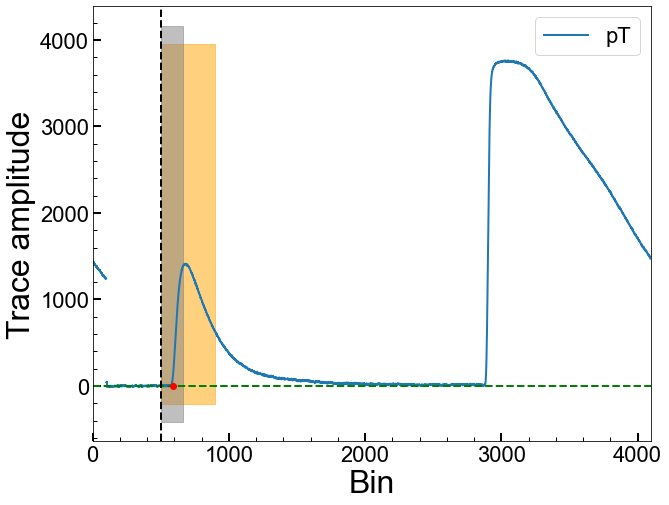

Series Number: 72209162200
Event Number: 3540826
Energy: 4.241800057188 keV


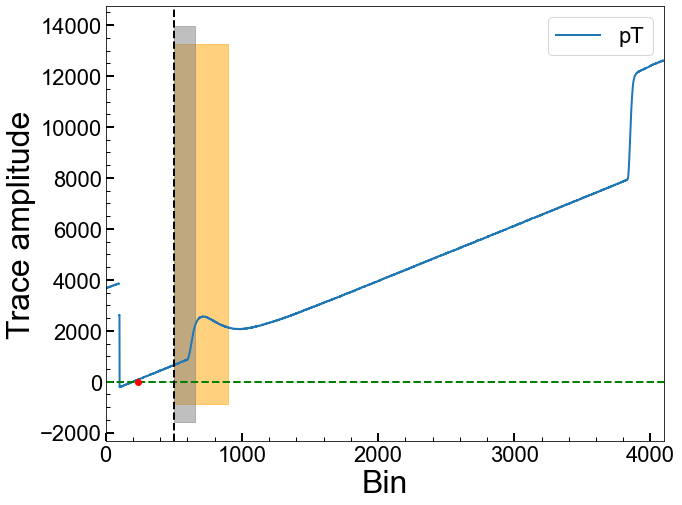

Series Number: 72209162200
Event Number: 3620570
Energy: 2.449876840887 keV


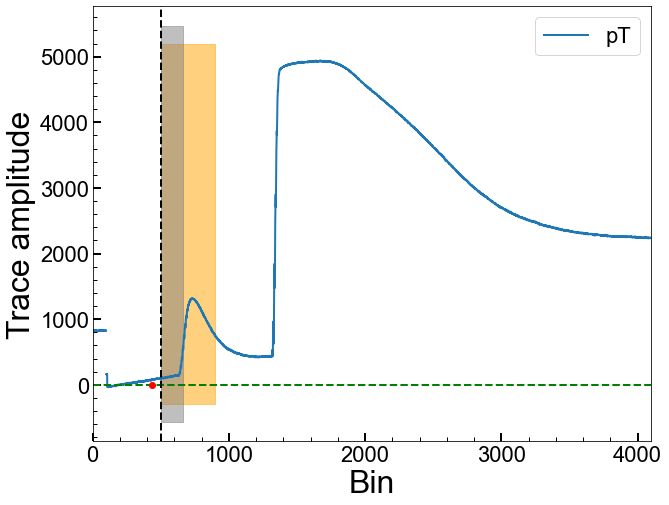

Series Number: 72209162200
Event Number: 4010538
Energy: 3.999107928438 keV


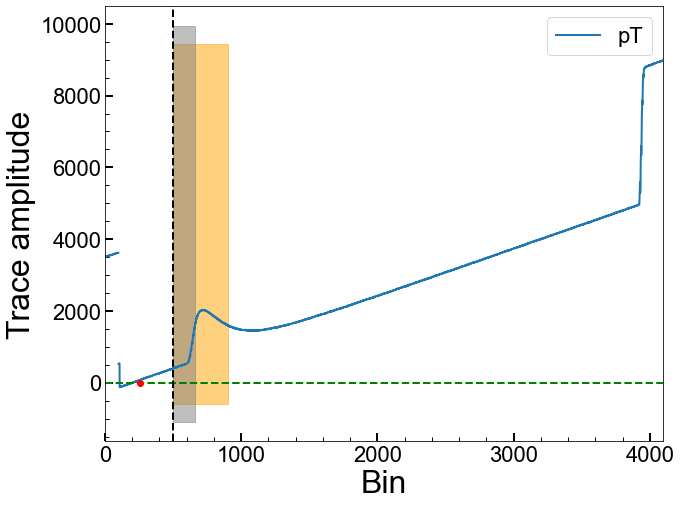

Series Number: 72209162200
Event Number: 4280711
Energy: 13.35888776314 keV


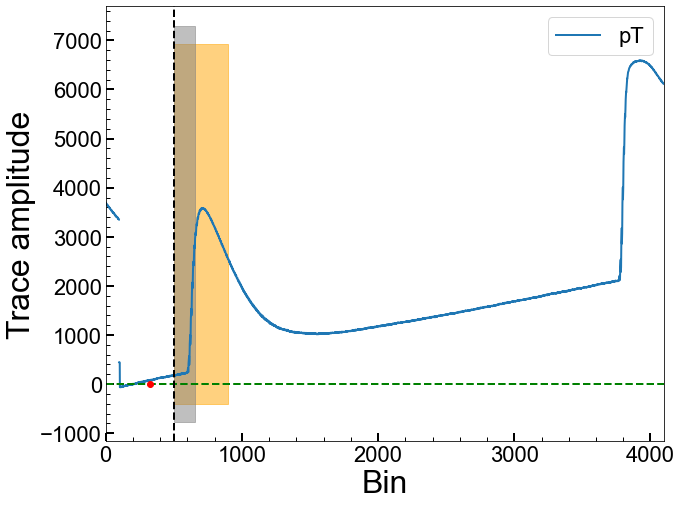

Series Number: 72209162200
Event Number: 4500856
Energy: 2.201223254445 keV


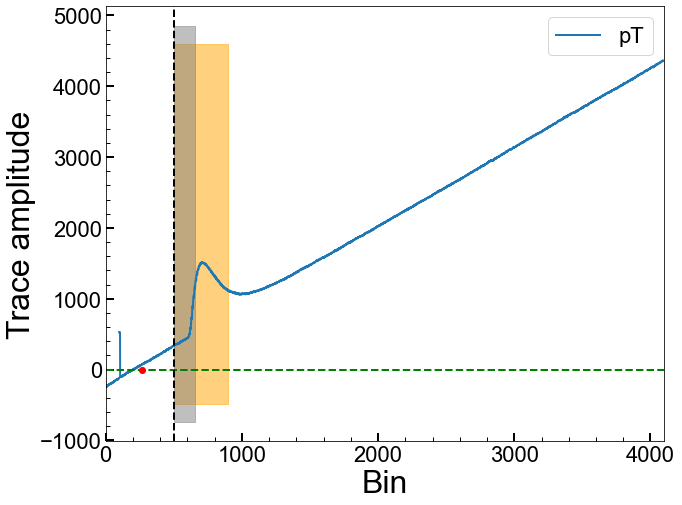

Series Number: 72209162200
Event Number: 4520043
Energy: 7.542917417246 keV


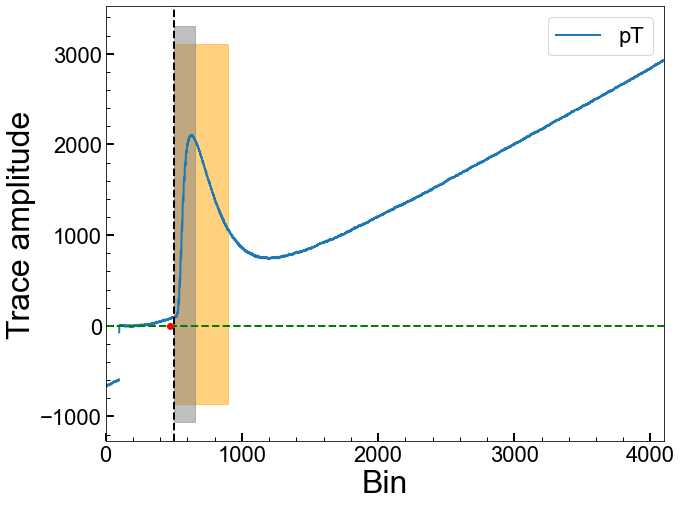

Series Number: 72209162200
Event Number: 4590916
Energy: 12.76370698041 keV


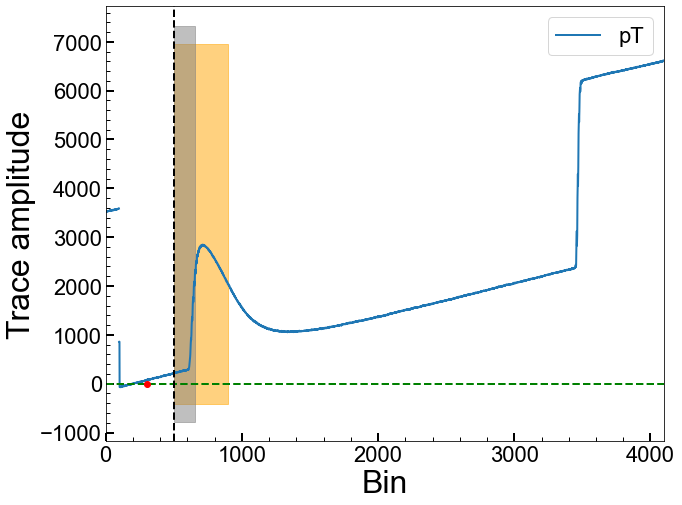

Series Number: 72209162200
Event Number: 4650446
Energy: 8.441939080995 keV


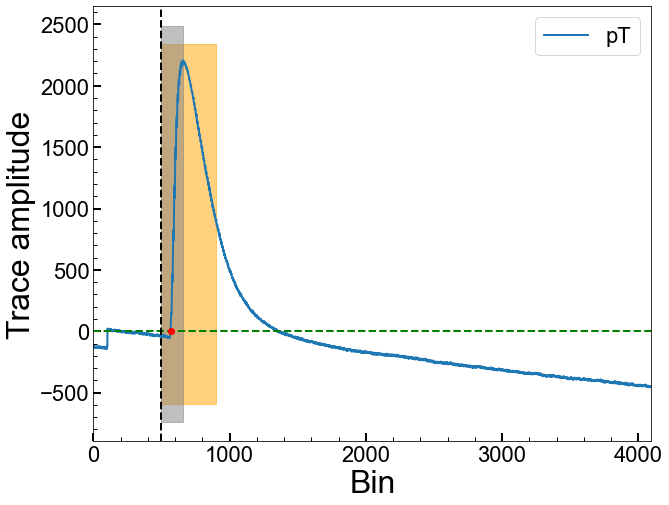

Series Number: 72209162200
Event Number: 4860070
Energy: 2.810942425095 keV


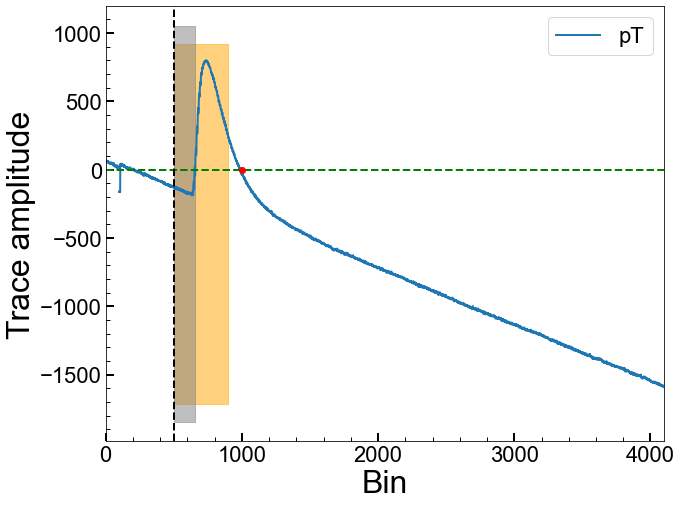

Series Number: 72209162200
Event Number: 5050732
Energy: 8.973632070046 keV


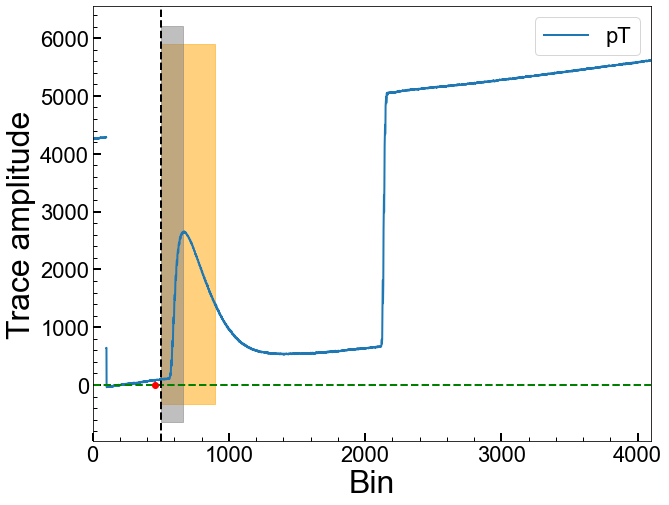

Series Number: 72209162200
Event Number: 5240811
Energy: 6.17912740005 keV


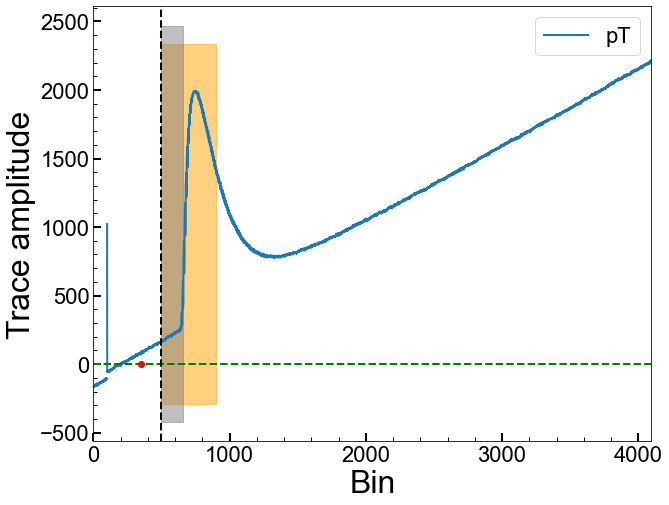

Series Number: 72209162200
Event Number: 5260711
Energy: 7.156935281128 keV


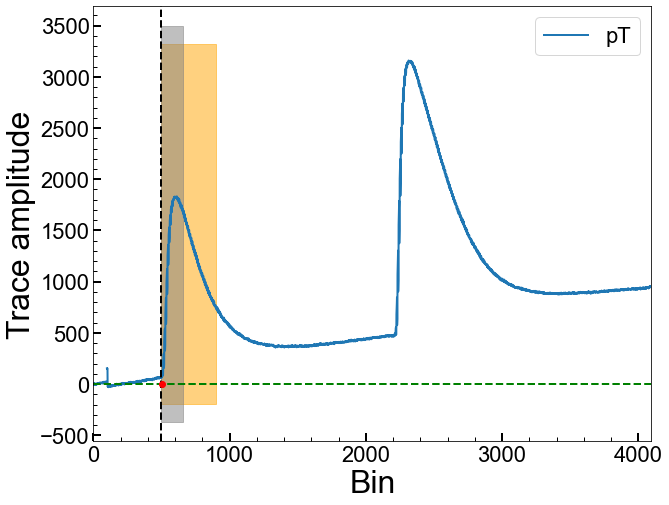

Series Number: 72209162200
Event Number: 5330875
Energy: 7.258779996547 keV


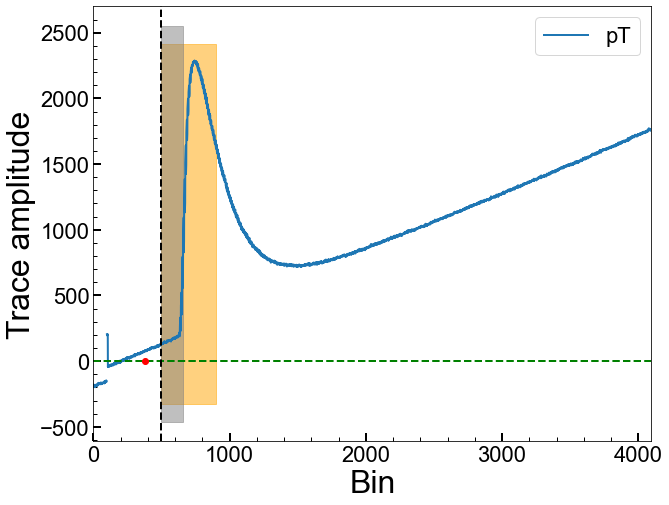

Series Number: 72209162200
Event Number: 5380569
Energy: 12.11218060073 keV


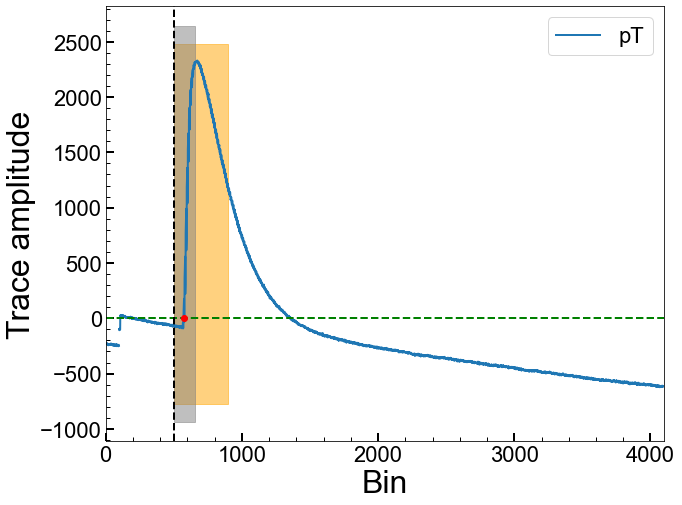

Series Number: 72209162200
Event Number: 5600827
Energy: 14.59716204358 keV


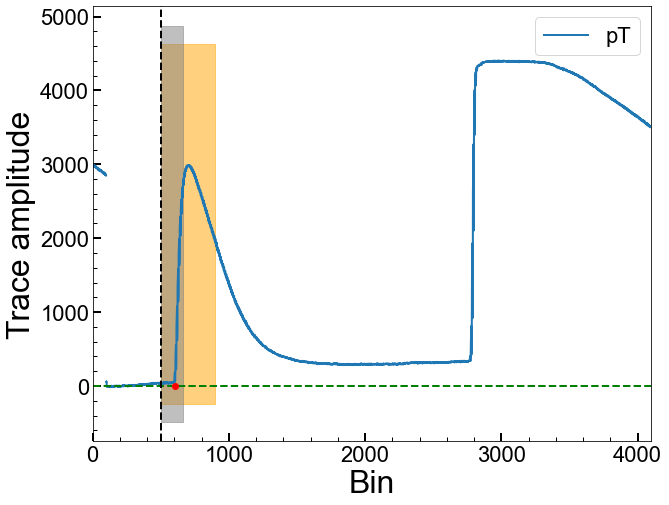

Series Number: 72209162200
Event Number: 5640544
Energy: 8.585720029057 keV


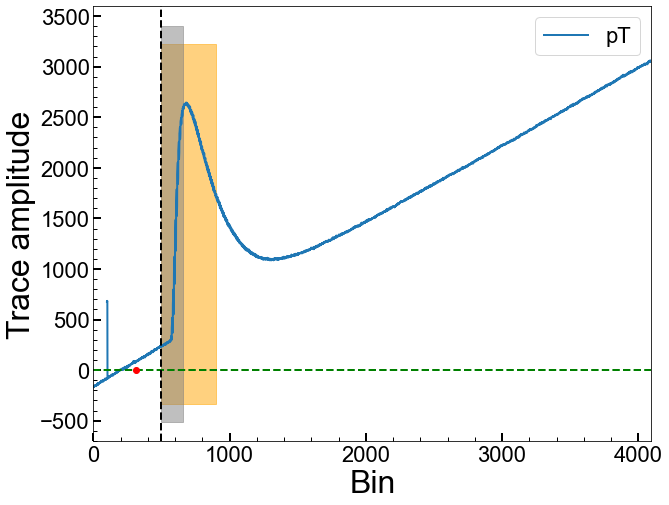

Series Number: 72209162200
Event Number: 5760180
Energy: 8.834725259576 keV


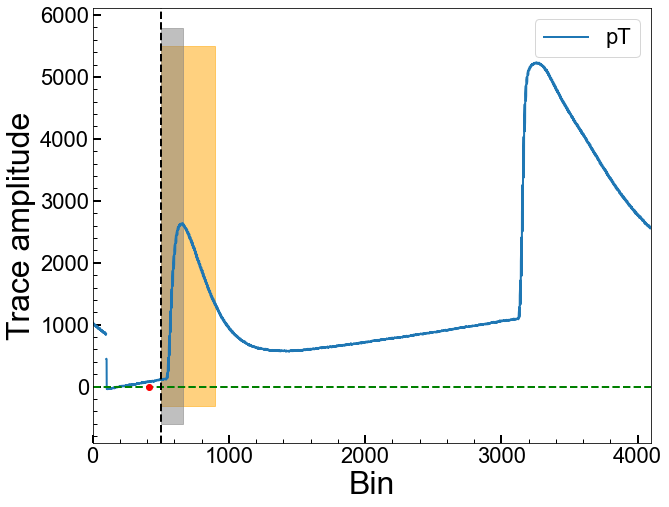

Series Number: 72209162200
Event Number: 5780839
Energy: 11.3683361892 keV


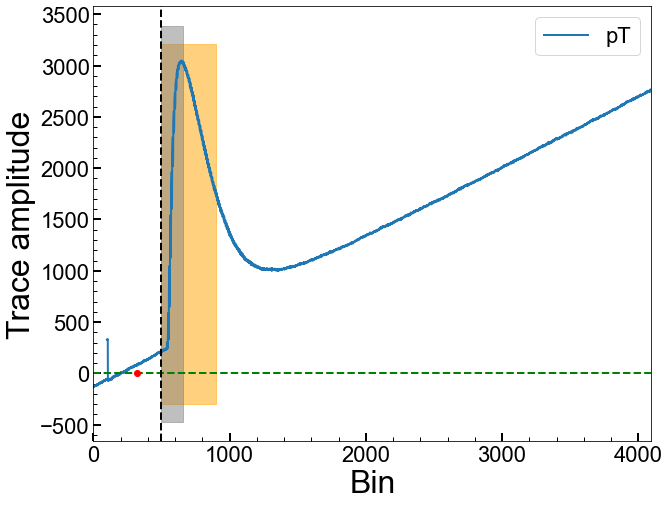

Series Number: 72209162200
Event Number: 5880059
Energy: 13.58616102547 keV


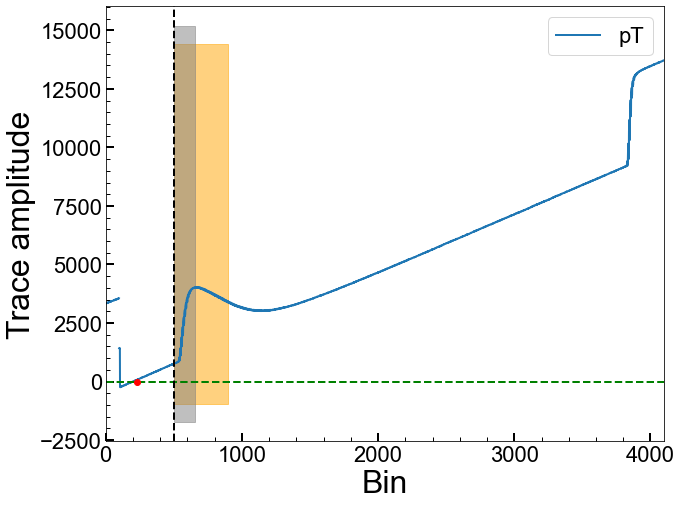

Series Number: 72209162200
Event Number: 6000522
Energy: 10.64594210321 keV


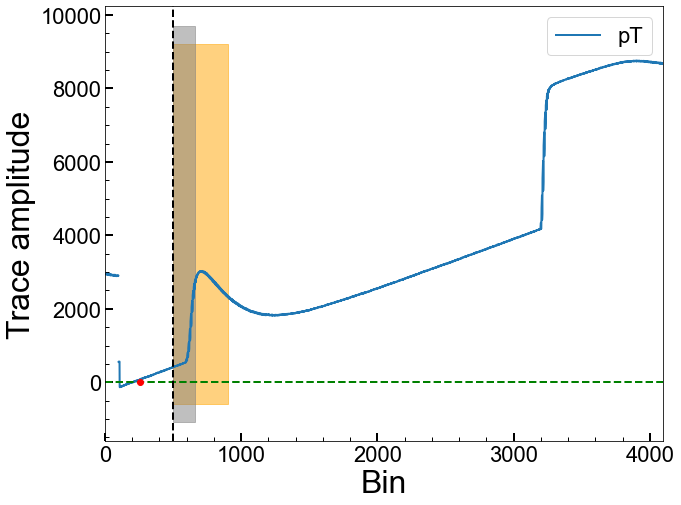

Series Number: 72209162200
Event Number: 6020467
Energy: 11.19189175251 keV


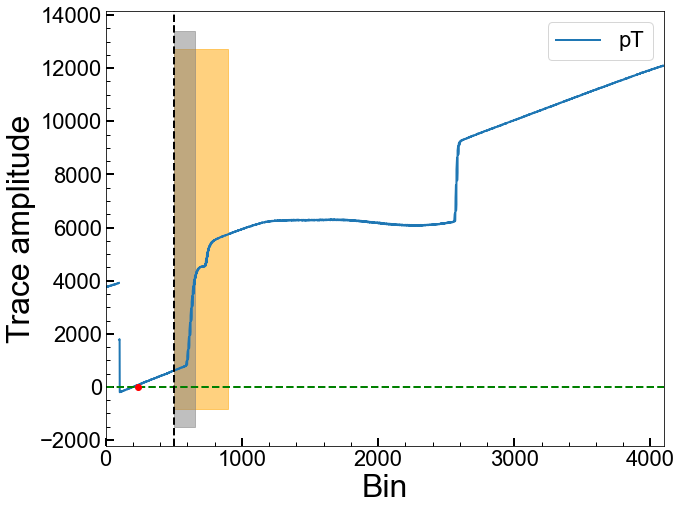

Series Number: 72209162200
Event Number: 6460652
Energy: 14.91902825929 keV


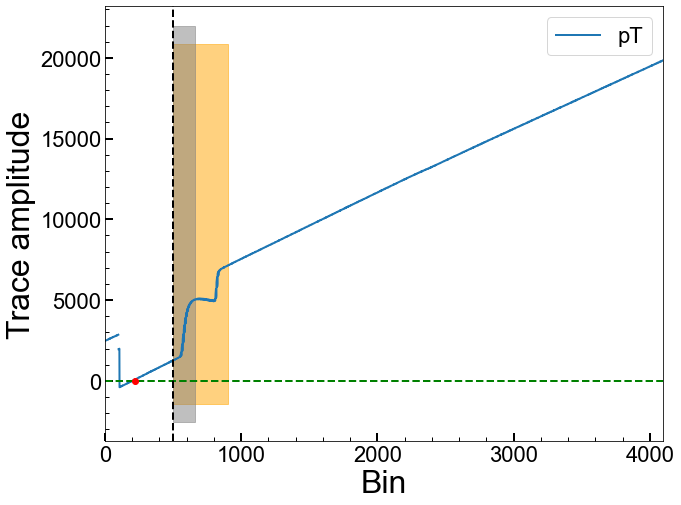

Series Number: 72209162200
Event Number: 6480647
Energy: 12.48629410187 keV


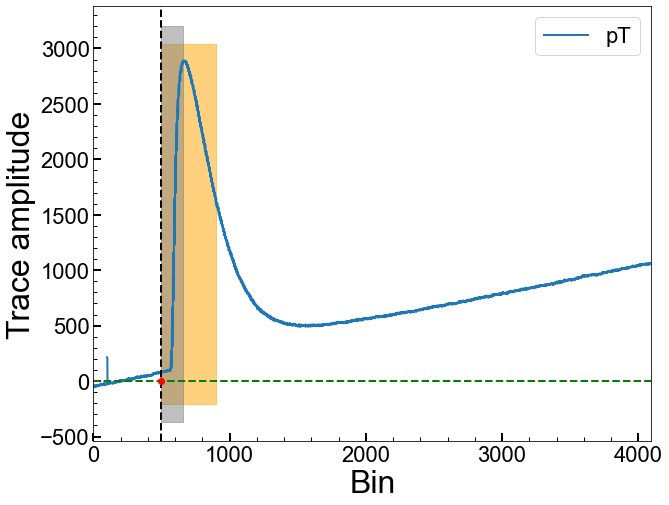

Series Number: 72209162200
Event Number: 6820549
Energy: 14.55882936696 keV


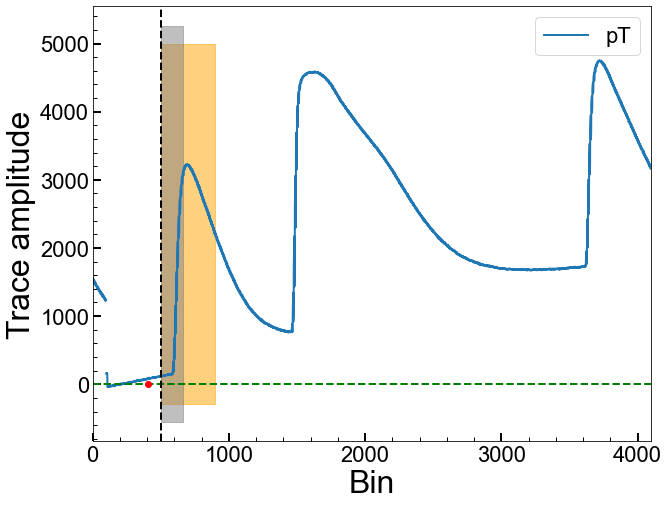

Series Number: 72209162200
Event Number: 7080841
Energy: 13.1348736938 keV


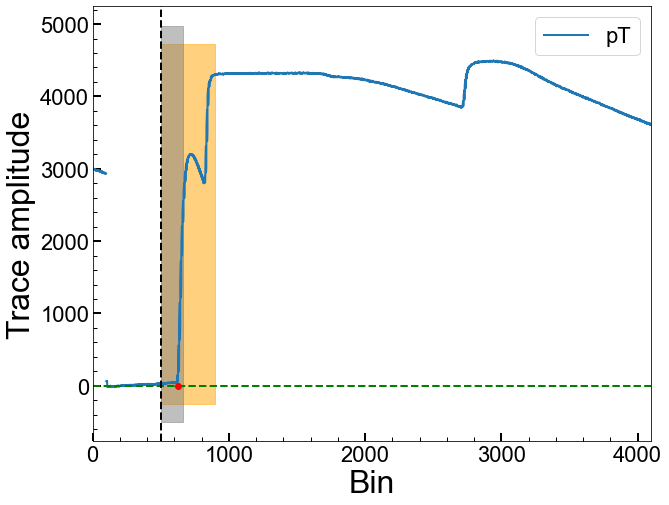

Series Number: 72209162200
Event Number: 7160810
Energy: 8.945300966353 keV


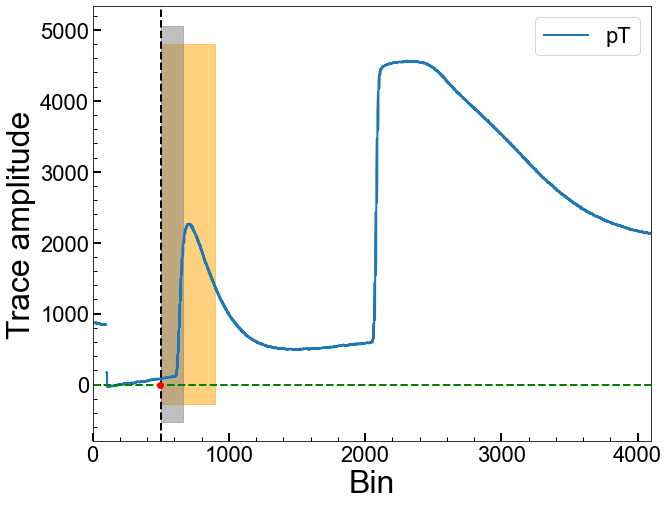

Series Number: 72209162200
Event Number: 7370027
Energy: 7.692588329475 keV


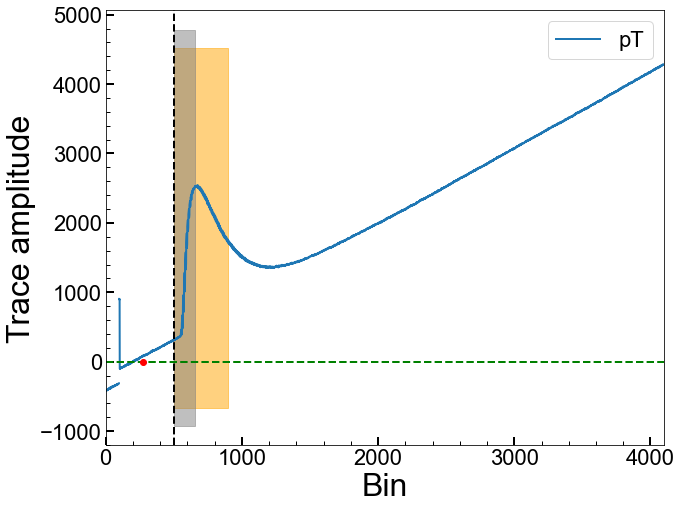

Series Number: 72209162200
Event Number: 7410314
Energy: 7.292607682607 keV


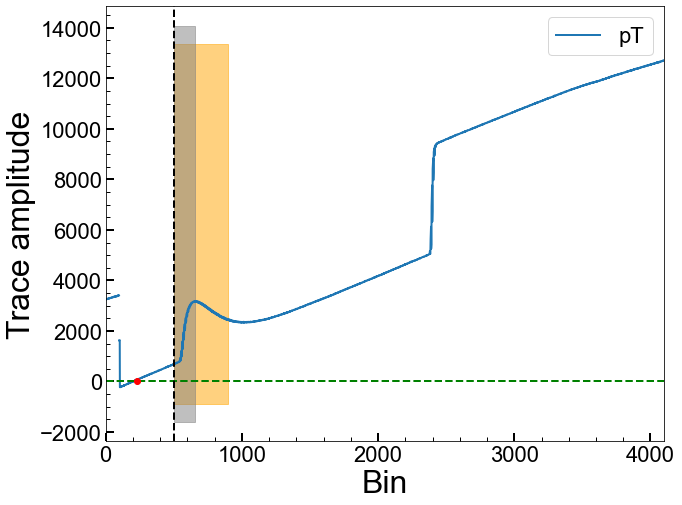

Series Number: 72209162200
Event Number: 7440215
Energy: 7.201134586102 keV


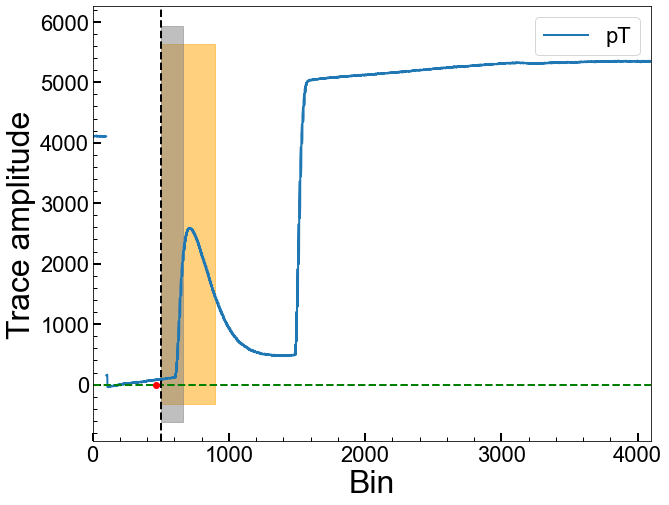

Series Number: 72209171225
Event Number: 100337
Energy: 10.07156075987 keV


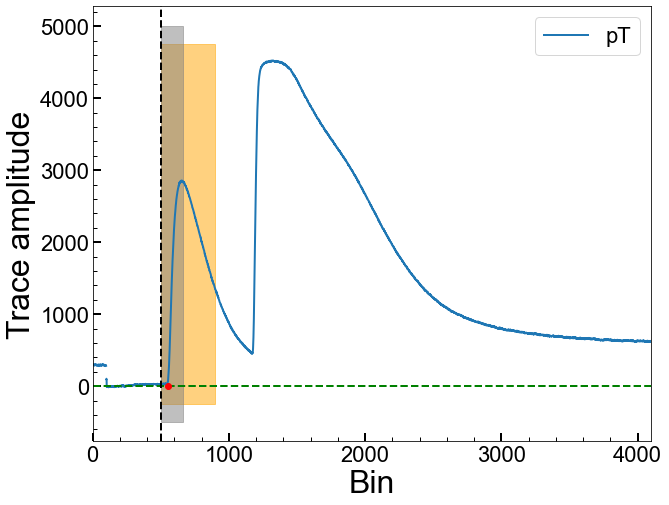

Series Number: 72209171225
Event Number: 570123
Energy: 3.982526680198 keV


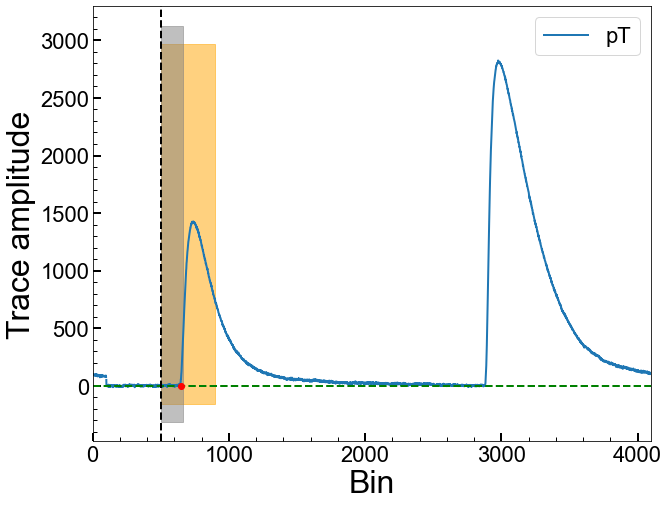

Series Number: 72209171225
Event Number: 1050411
Energy: 2.279092510027 keV


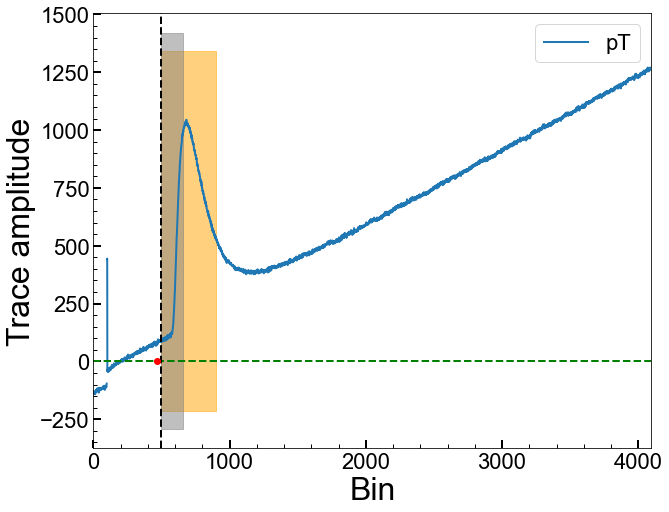

Series Number: 72209171225
Event Number: 1250534
Energy: 5.142703648541 keV


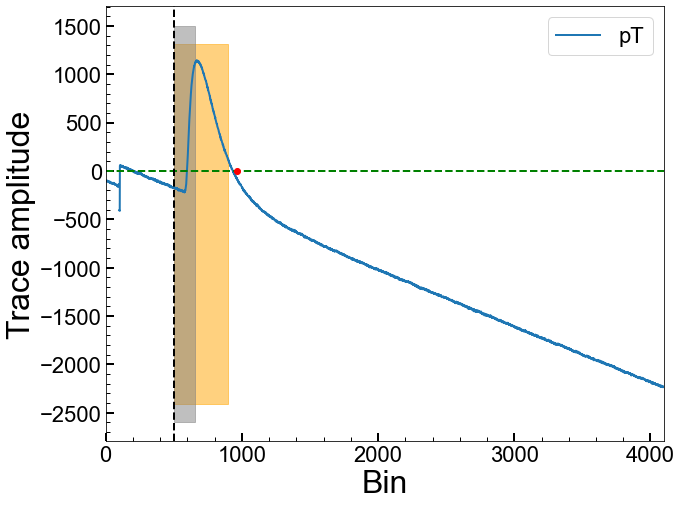

Series Number: 72209171225
Event Number: 1290559
Energy: 12.35324155801 keV


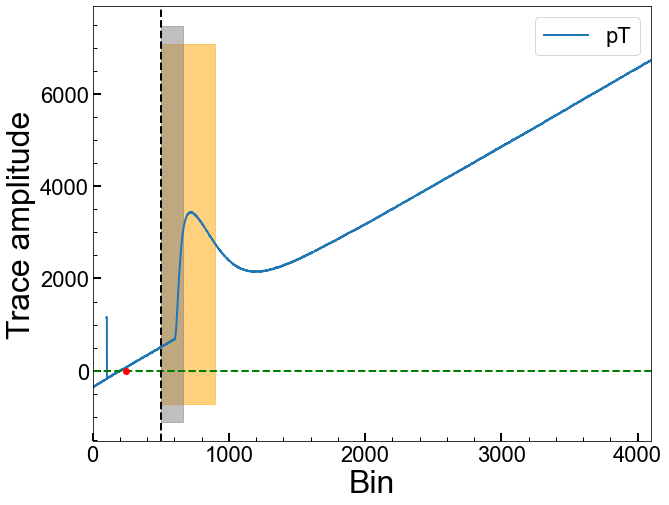

Series Number: 72209171225
Event Number: 1310816
Energy: 13.77983351672 keV


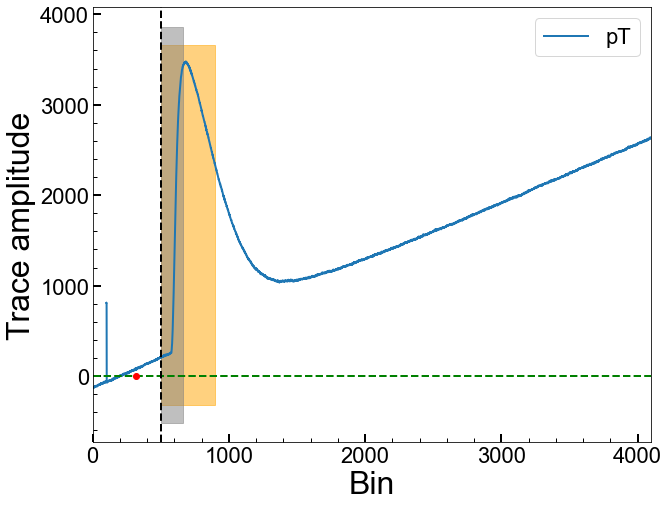

Series Number: 72209171225
Event Number: 1560841
Energy: 2.865328825931 keV


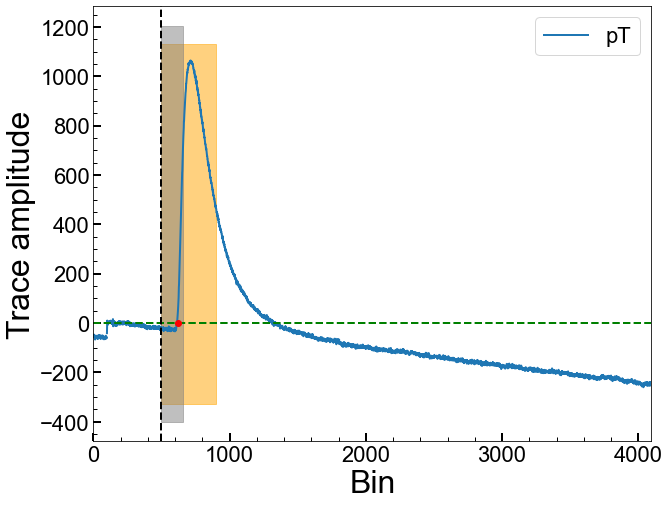

Series Number: 72209171225
Event Number: 1700015
Energy: 3.772400527502 keV


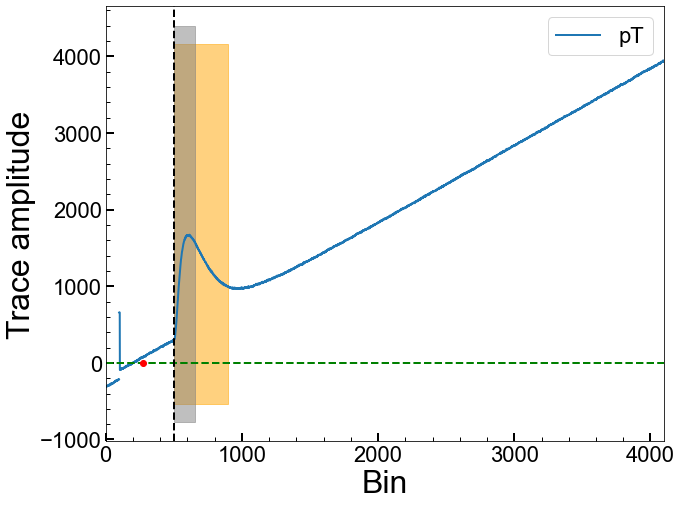

Series Number: 72209171225
Event Number: 1900197
Energy: 5.487935401485 keV


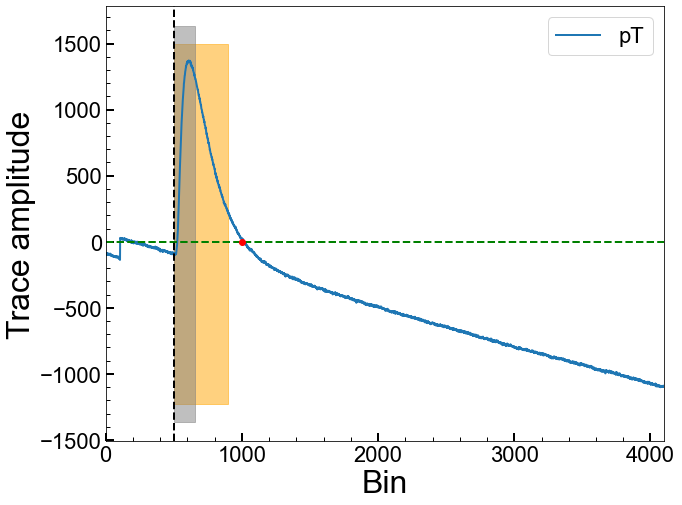

Series Number: 72209171225
Event Number: 2010329
Energy: 11.42217610585 keV


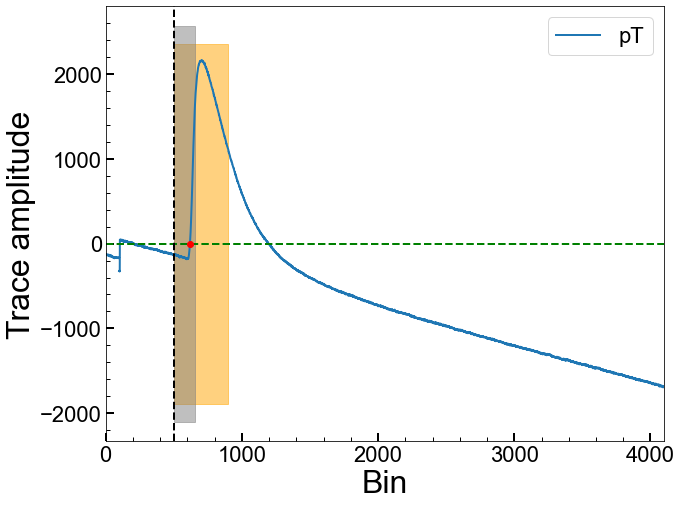

Series Number: 72209171225
Event Number: 2030680
Energy: 10.93323031429 keV


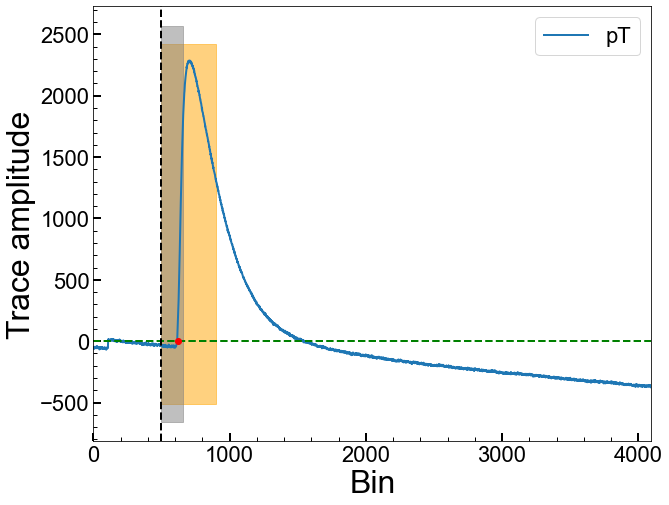

Series Number: 72209171225
Event Number: 2130589
Energy: 5.903520092933 keV


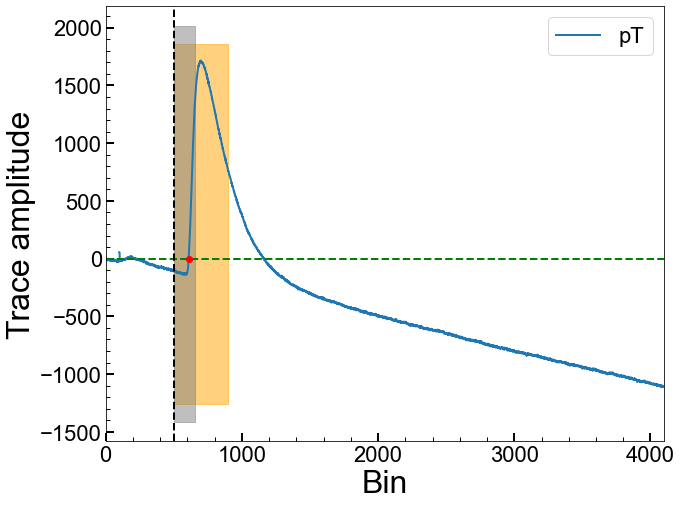

Series Number: 72209171225
Event Number: 2340336
Energy: 13.1694845488 keV


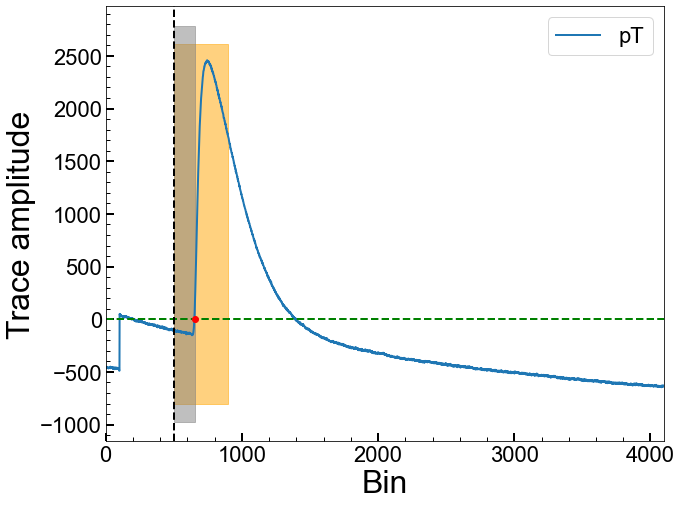

Series Number: 72209171225
Event Number: 2380670
Energy: 7.803059650351 keV


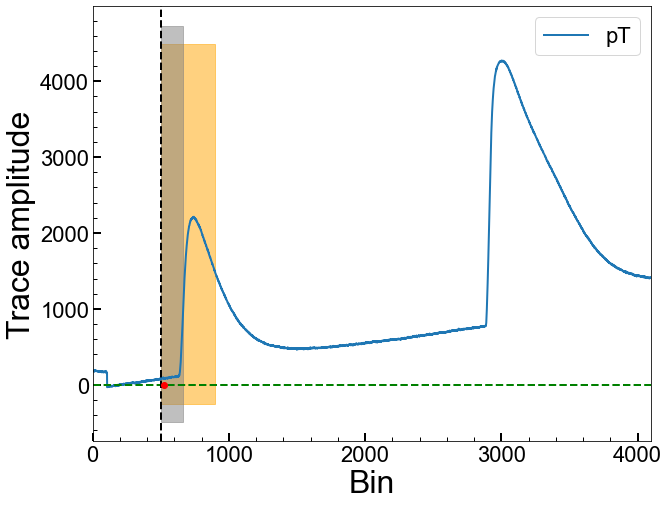

Series Number: 72209171225
Event Number: 2620371
Energy: 14.55607418789 keV


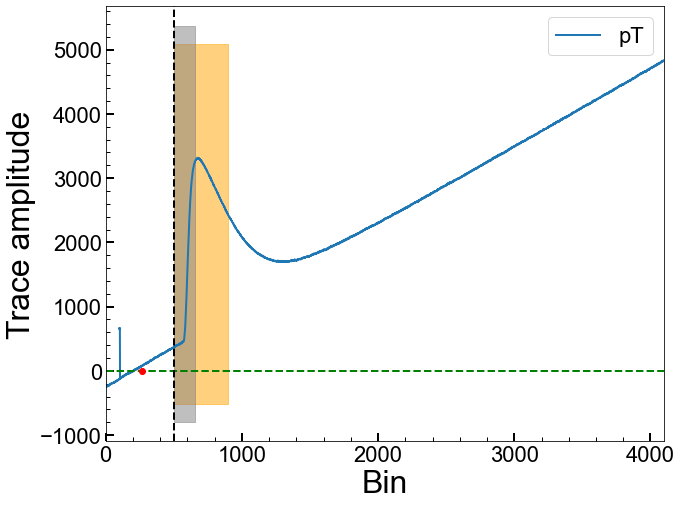

Series Number: 72209171225
Event Number: 2800023
Energy: 9.288981441905 keV


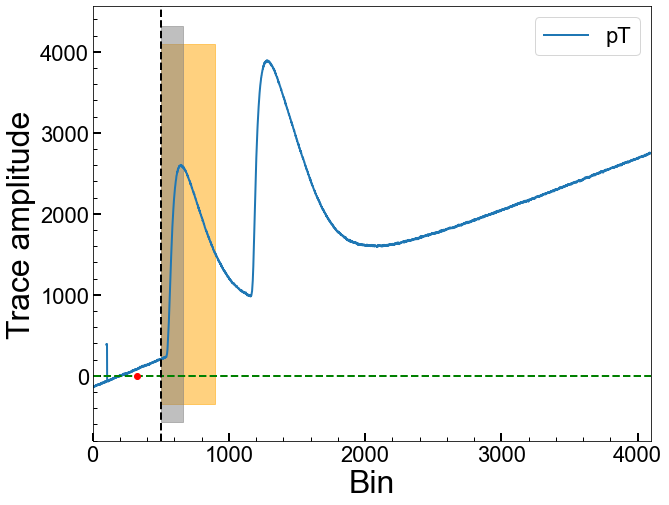

Series Number: 72209171225
Event Number: 2800492
Energy: 3.88106848511 keV


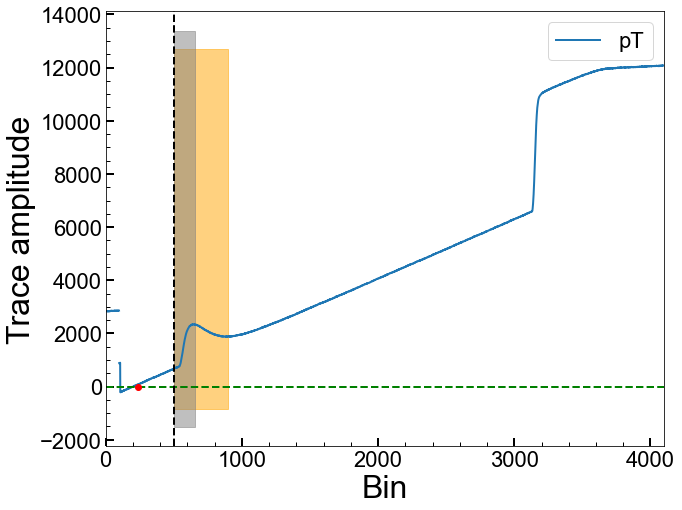

Series Number: 72209171225
Event Number: 2860716
Energy: 14.0812970012 keV


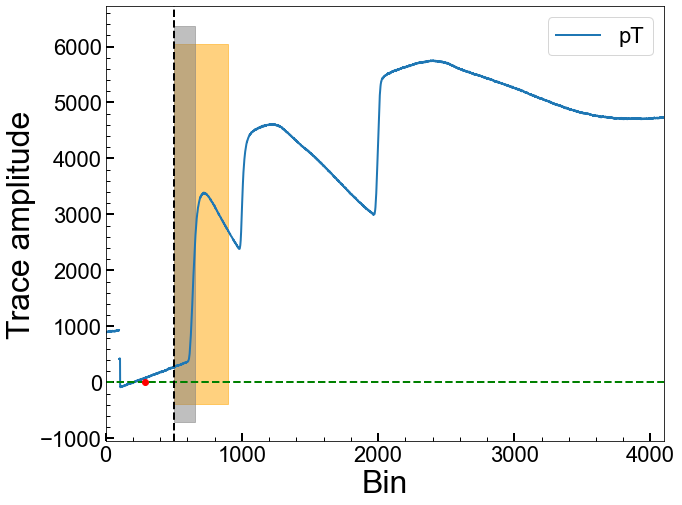

Series Number: 72209171225
Event Number: 2910234
Energy: 14.54901584511 keV


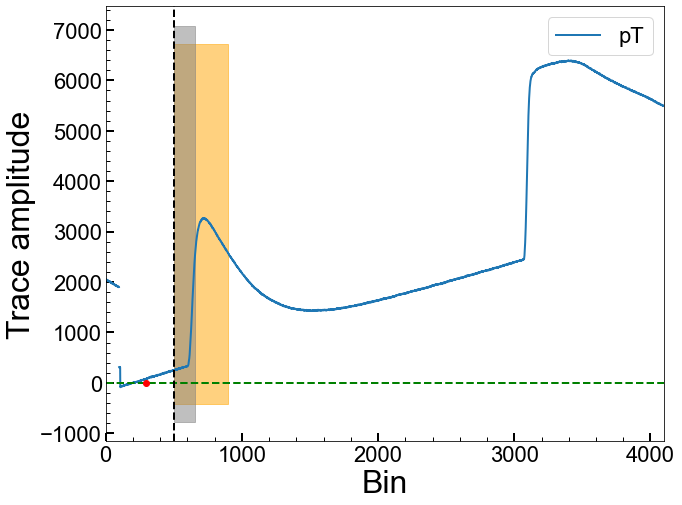

Series Number: 72209171225
Event Number: 3100271
Energy: 7.257608835645 keV


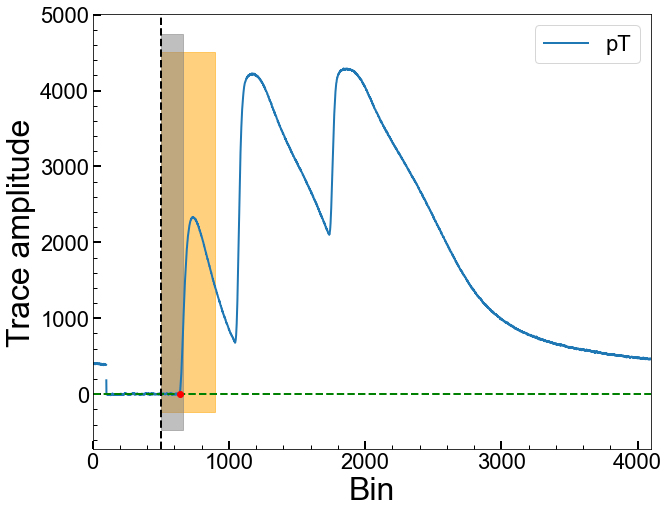

Series Number: 72209171225
Event Number: 3140592
Energy: 5.393781686734 keV


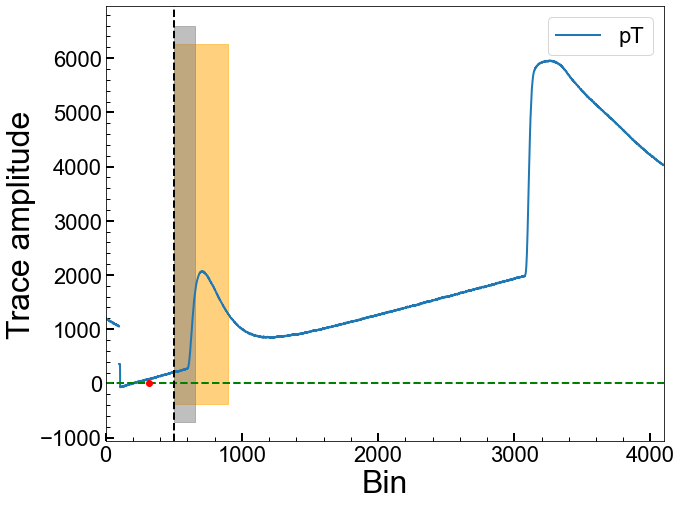

Series Number: 72209171225
Event Number: 3200882
Energy: 6.243001051 keV


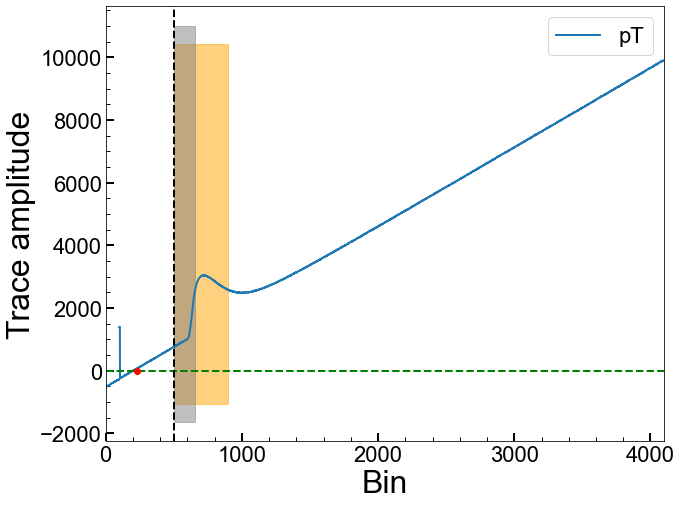

Series Number: 72209171225
Event Number: 3300216
Energy: 4.157315084321 keV


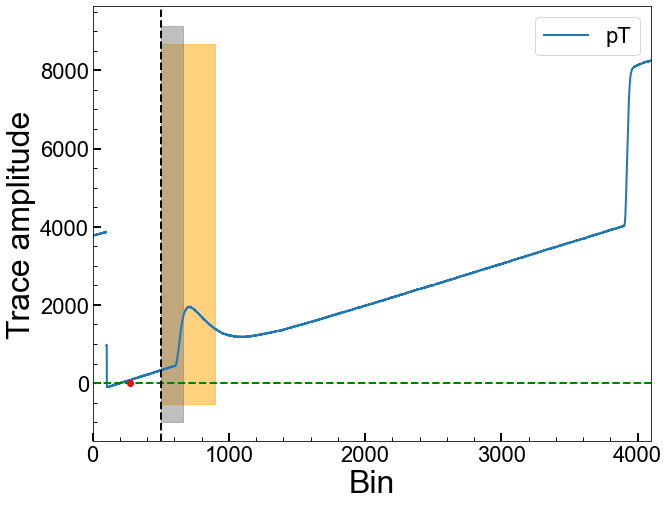

Series Number: 72209171225
Event Number: 3500068
Energy: 5.999865360979 keV


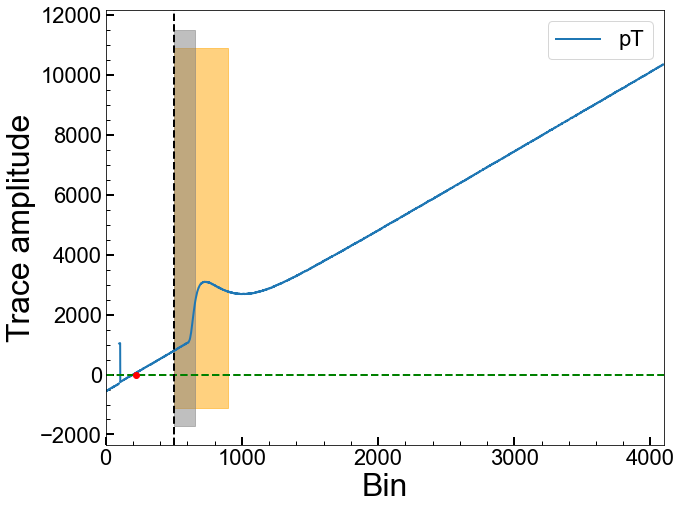

Series Number: 72209171225
Event Number: 3740347
Energy: 6.119056310427 keV


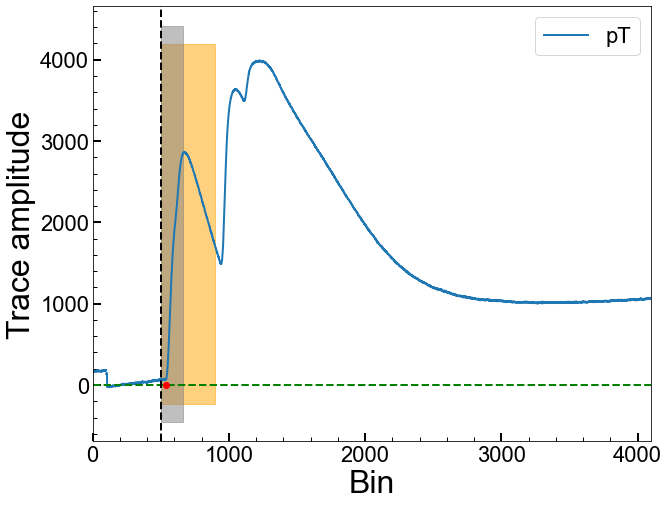

Series Number: 72209171225
Event Number: 3860027
Energy: 10.37153152173 keV


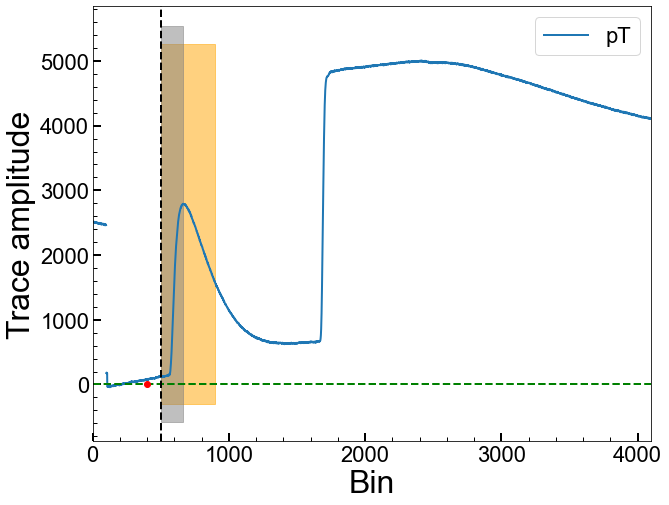

Series Number: 72209171225
Event Number: 3870123
Energy: 12.68021970752 keV


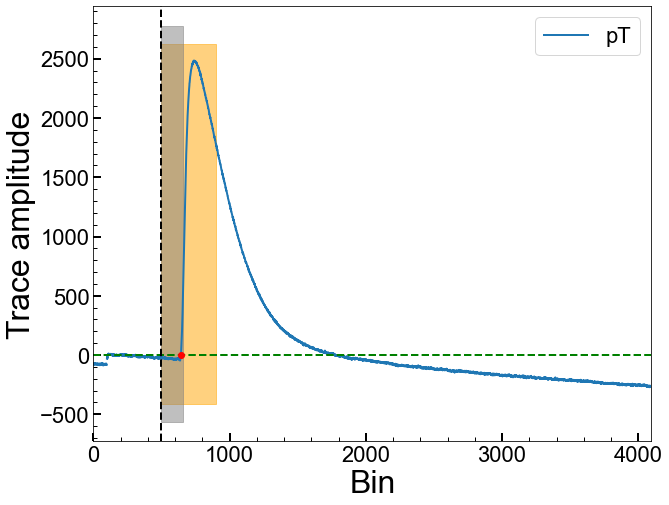

Series Number: 72209171225
Event Number: 4710444
Energy: 14.34775806185 keV


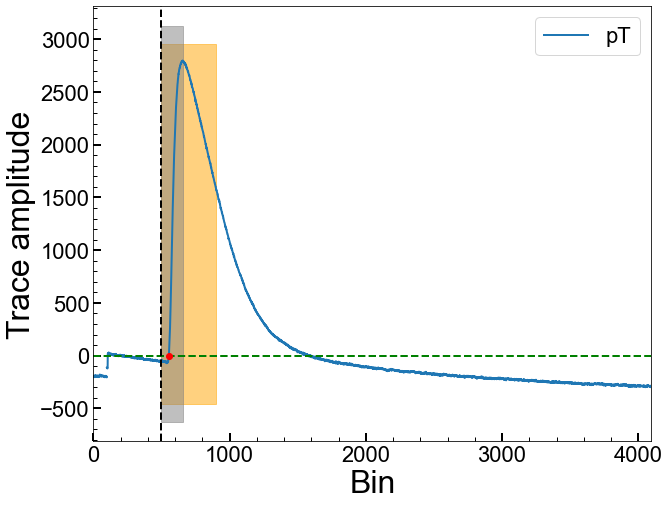

Series Number: 72209171225
Event Number: 4810359
Energy: 14.58320292159 keV


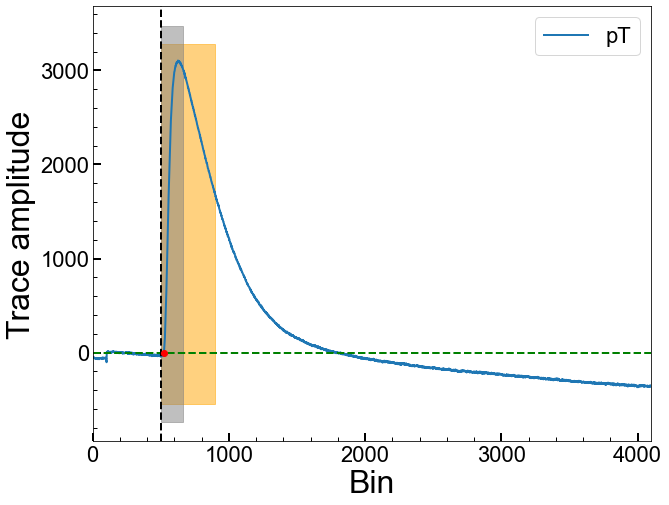

Series Number: 72209171225
Event Number: 4820332
Energy: 4.25709376349 keV


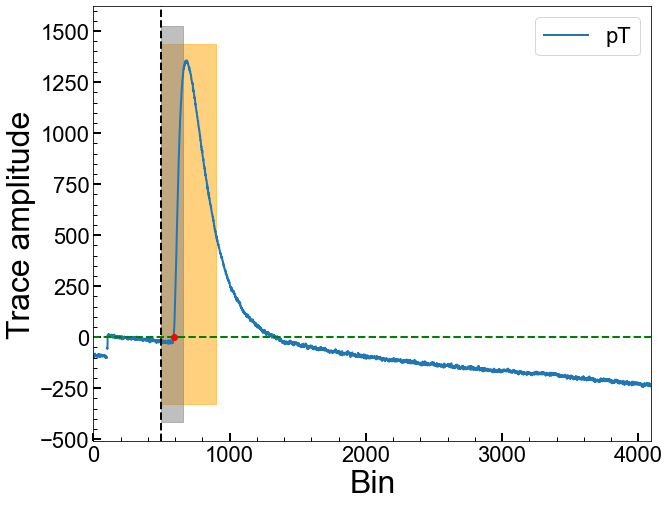

Series Number: 72209171225
Event Number: 5100400
Energy: 4.516517759674 keV


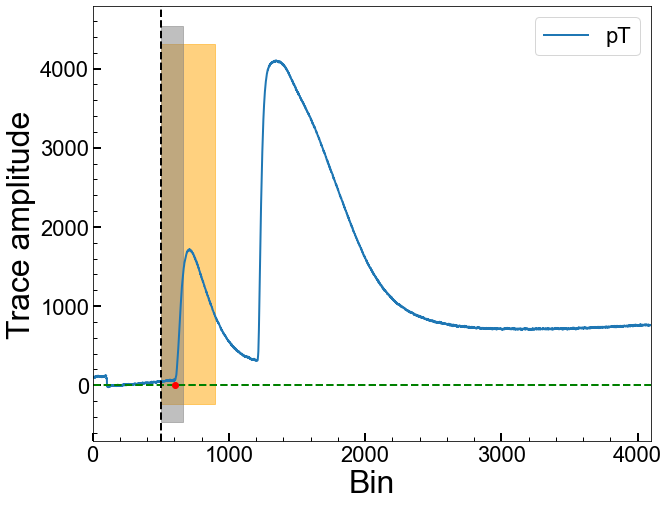

Series Number: 72209172155
Event Number: 390282
Energy: 2.716829541955 keV


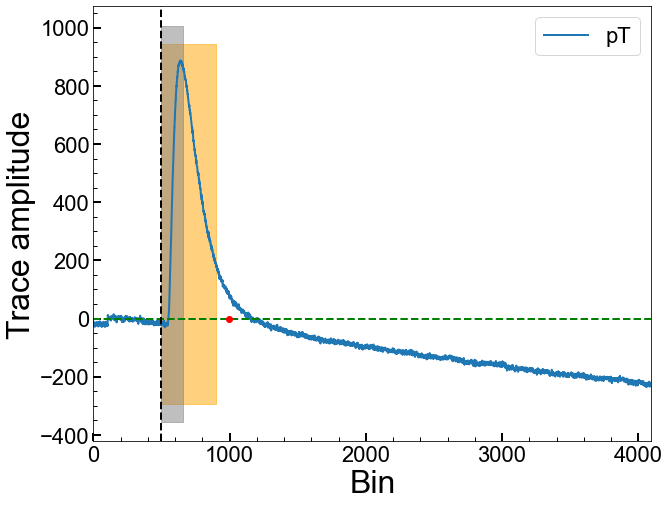

Series Number: 72209172155
Event Number: 900575
Energy: 9.339626117881 keV


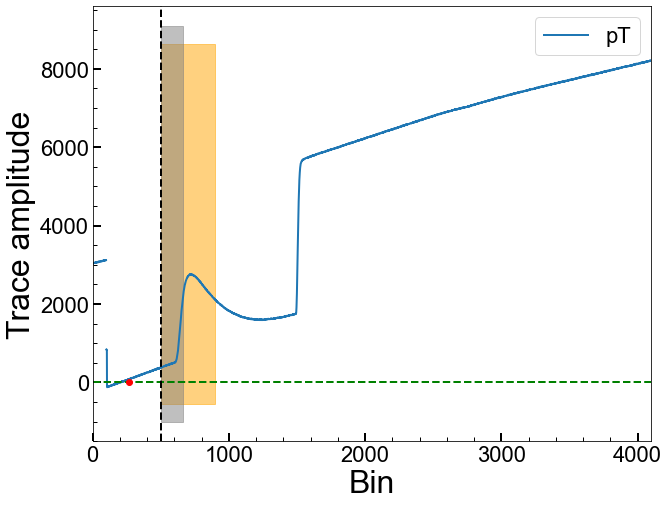

Series Number: 72209172155
Event Number: 1500583
Energy: 14.13153393868 keV


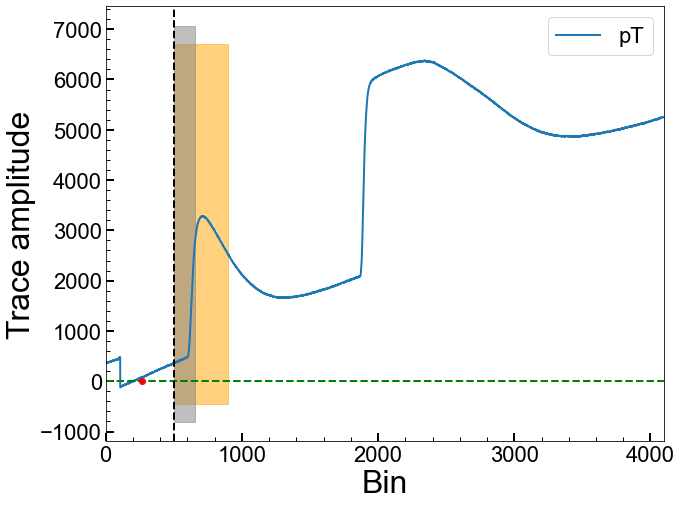

Series Number: 72209172155
Event Number: 1620841
Energy: 11.16079937875 keV


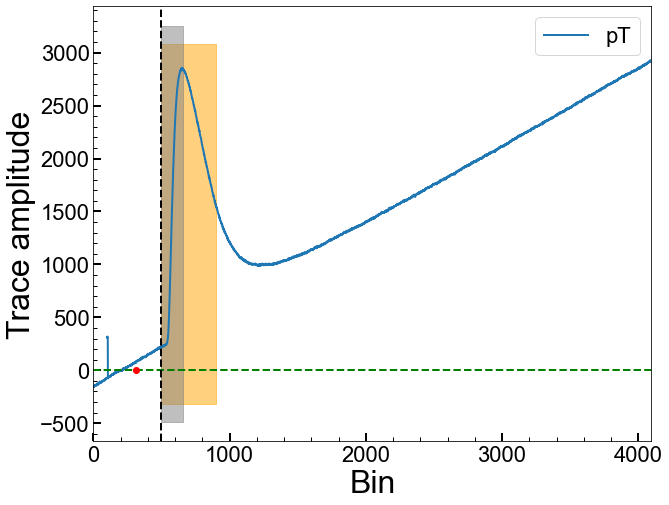

Series Number: 72209172155
Event Number: 1870008
Energy: 4.750556877943 keV


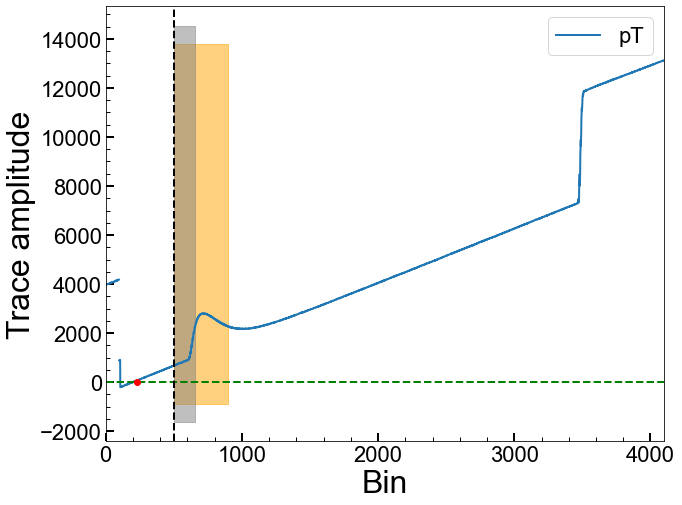

Series Number: 72209172155
Event Number: 2010568
Energy: 14.56993679059 keV


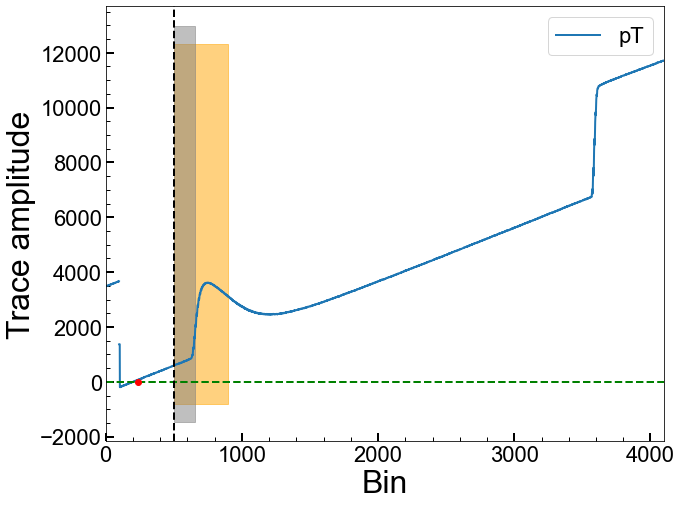

In [6]:
loops = 0
time_reg = []
energies = []
bad=[]
goodevs=[]
plot=True

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                if best_cross<500:
                    bad.append(loops)
                elif (energy<15):
                    goodevs.append(ev)
                    
            if (plot==True) and (getBadBL(exampleObj,ser,ev)) and (energy<15):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1

Series Number: 72209162200
Event Number: 20309
Energy: 48.72442612309 keV


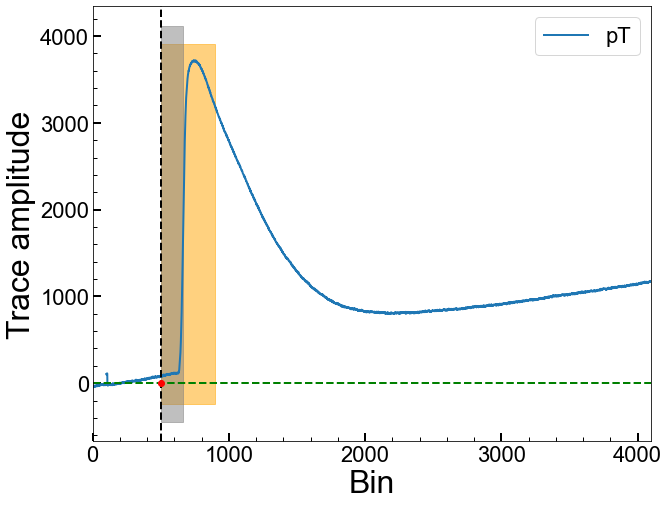

Series Number: 72209162200
Event Number: 270221
Energy: 39.26025312352 keV


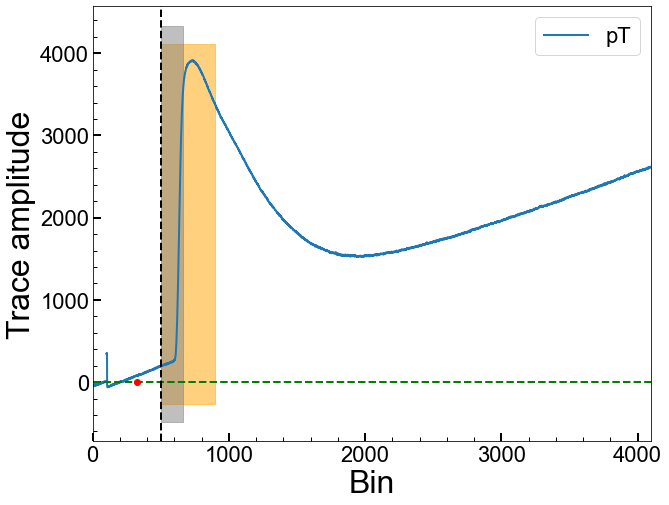

Series Number: 72209162200
Event Number: 560931
Energy: 37.38332924631 keV


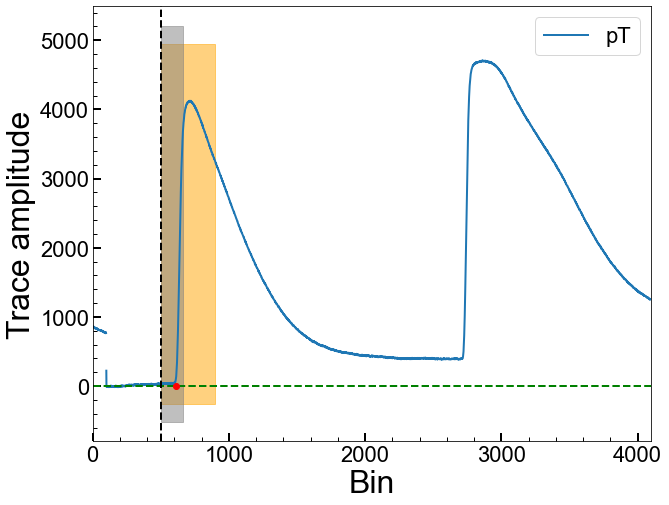

Series Number: 72209162200
Event Number: 580008
Energy: 33.97321412501 keV


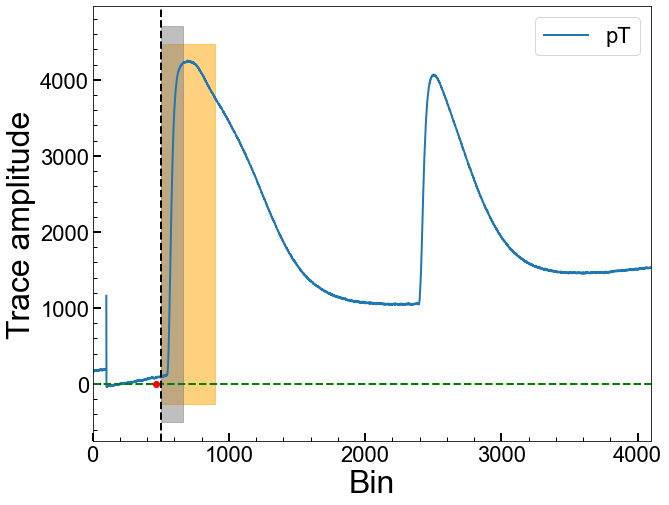

Series Number: 72209162200
Event Number: 780628
Energy: 39.48083097848 keV


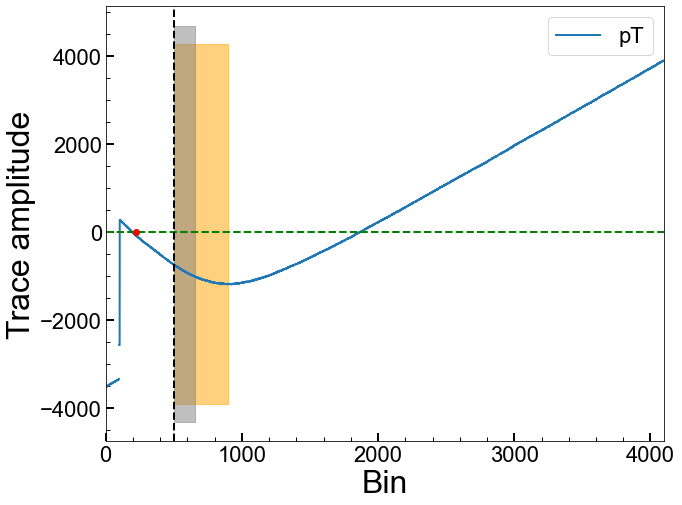

Series Number: 72209162200
Event Number: 970767
Energy: 47.91986636021 keV


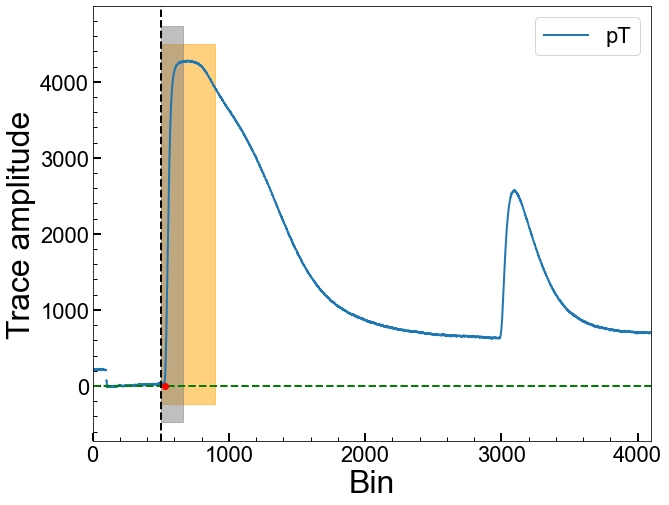

Series Number: 72209162200
Event Number: 1070509
Energy: 47.55945117602 keV


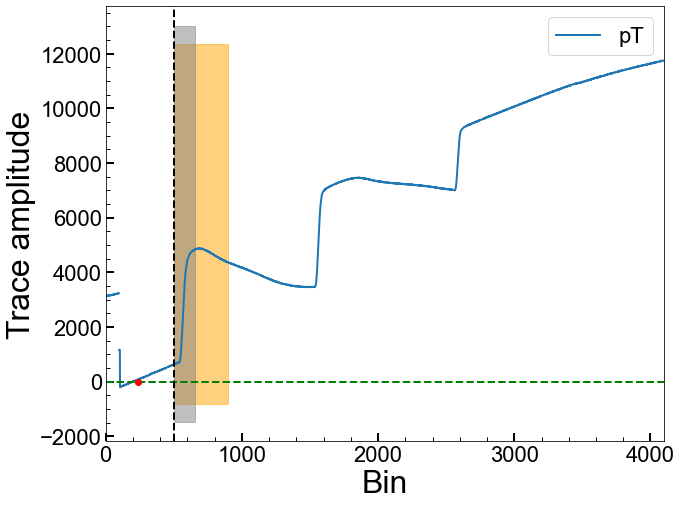

Series Number: 72209162200
Event Number: 1110143
Energy: 36.21041003857 keV


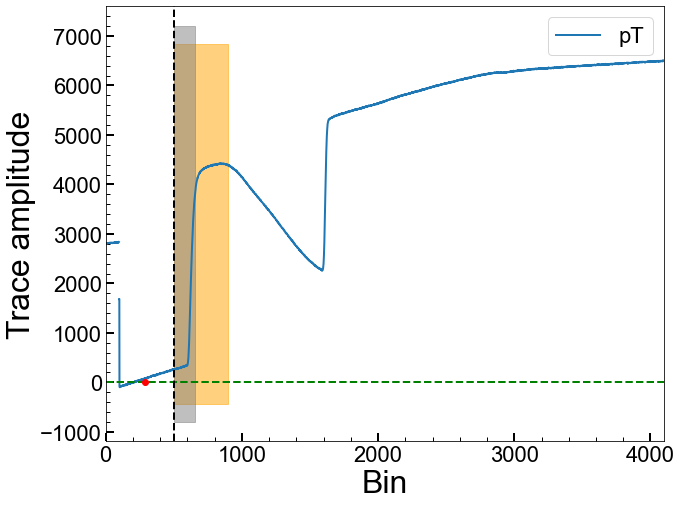

Series Number: 72209162200
Event Number: 1130006
Energy: 34.04177862434 keV


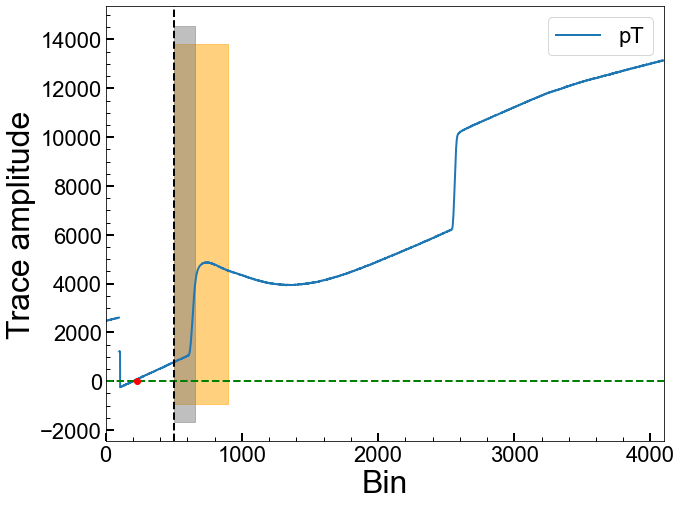

Series Number: 72209162200
Event Number: 1410541
Energy: 37.19507432221 keV


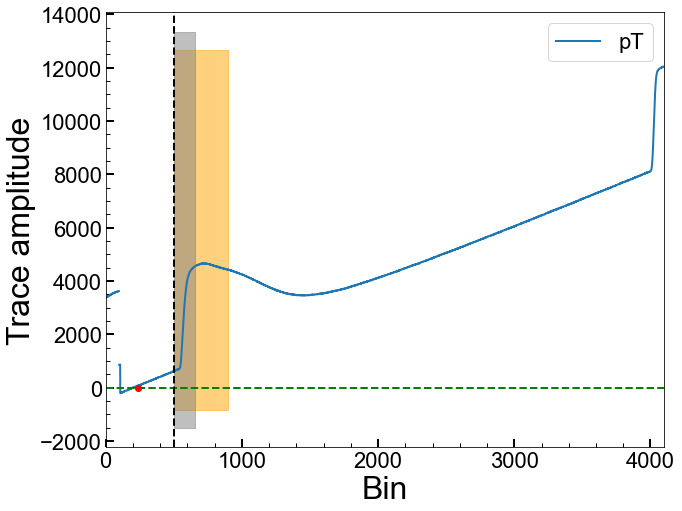

Series Number: 72209162200
Event Number: 1830115
Energy: 42.13844417863 keV


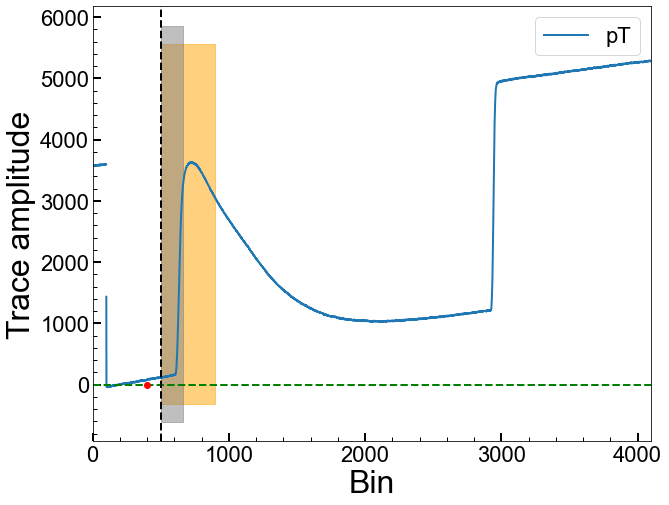

Series Number: 72209162200
Event Number: 2110042
Energy: 37.23495397847 keV


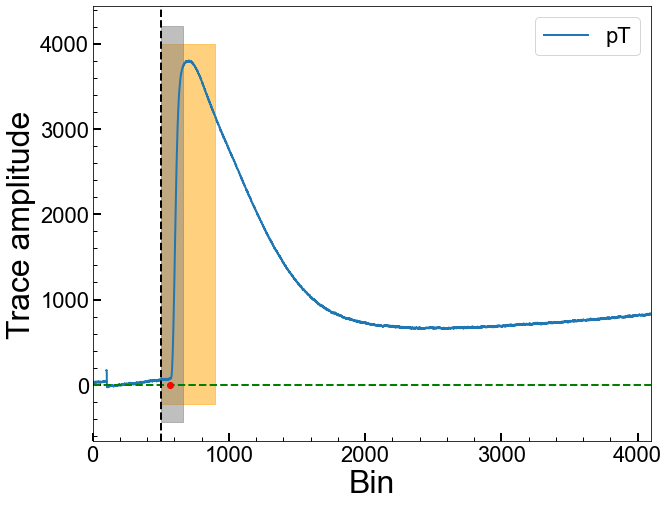

Series Number: 72209162200
Event Number: 2110321
Energy: 33.04935262098 keV


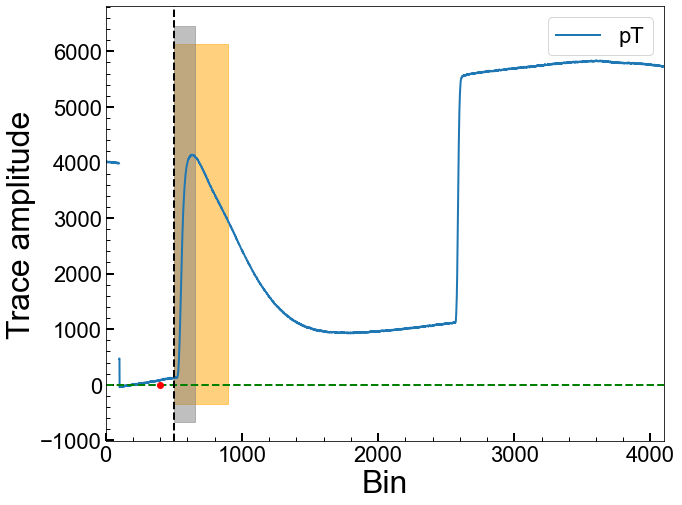

Series Number: 72209162200
Event Number: 2200405
Energy: 45.48539733361 keV


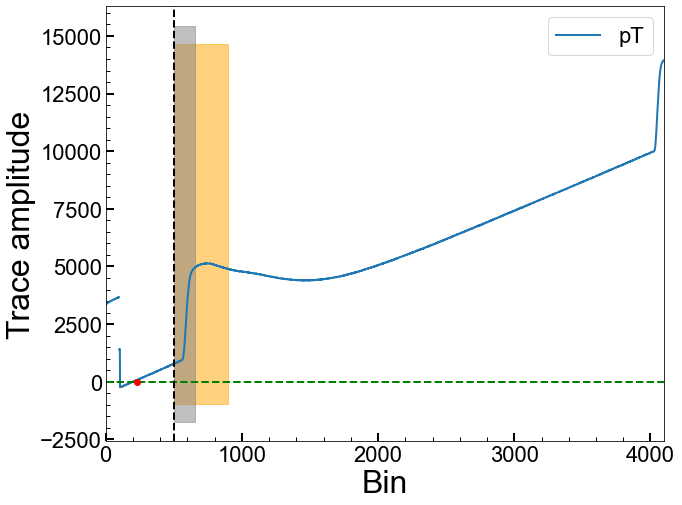

Series Number: 72209162200
Event Number: 2300247
Energy: 37.04604686141 keV


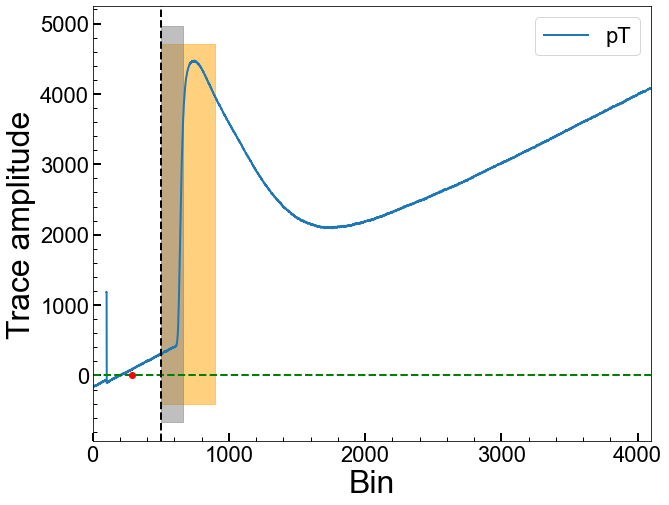

Series Number: 72209162200
Event Number: 2310373
Energy: 39.7944121246 keV


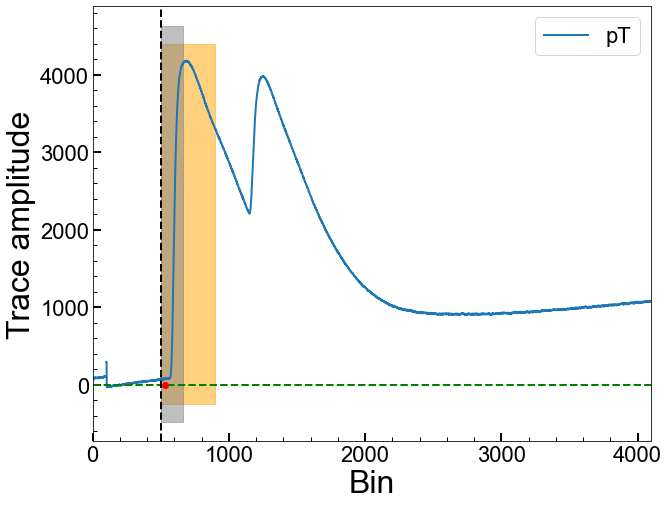

Series Number: 72209162200
Event Number: 2310435
Energy: 45.51915434933 keV


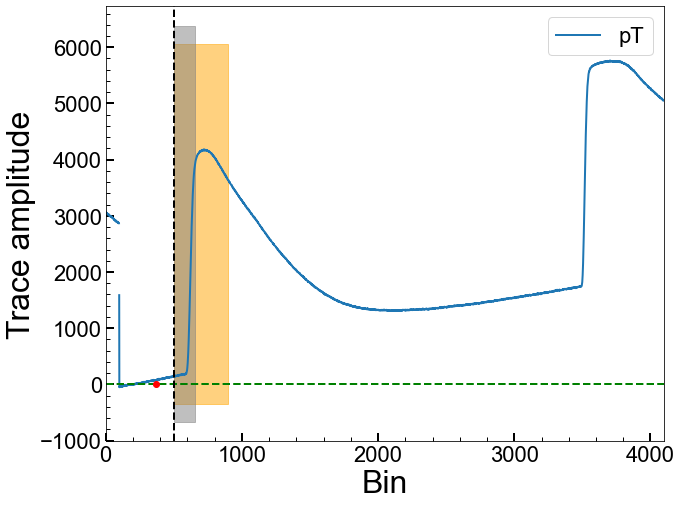

Series Number: 72209162200
Event Number: 2500665
Energy: 37.47752435397 keV


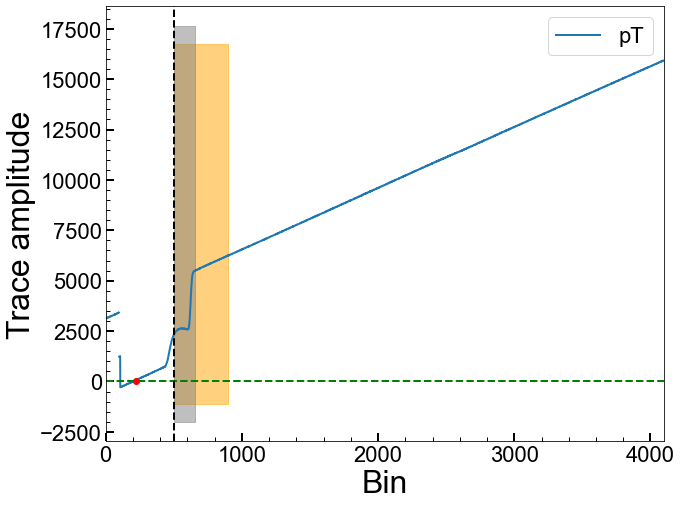

Series Number: 72209162200
Event Number: 2620773
Energy: 47.91406375709 keV


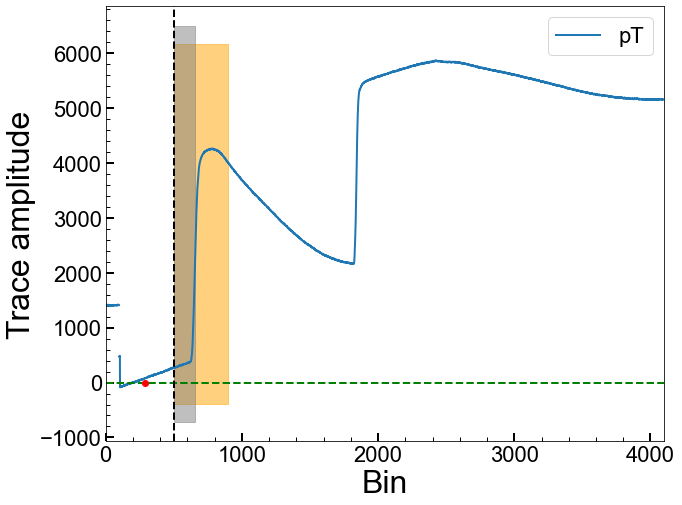

Series Number: 72209162200
Event Number: 2630787
Energy: 43.13693716982 keV


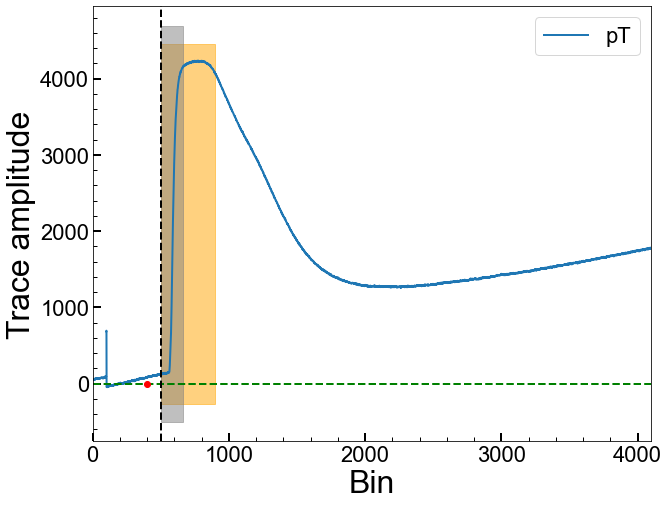

Series Number: 72209162200
Event Number: 3070886
Energy: 36.10265655727 keV


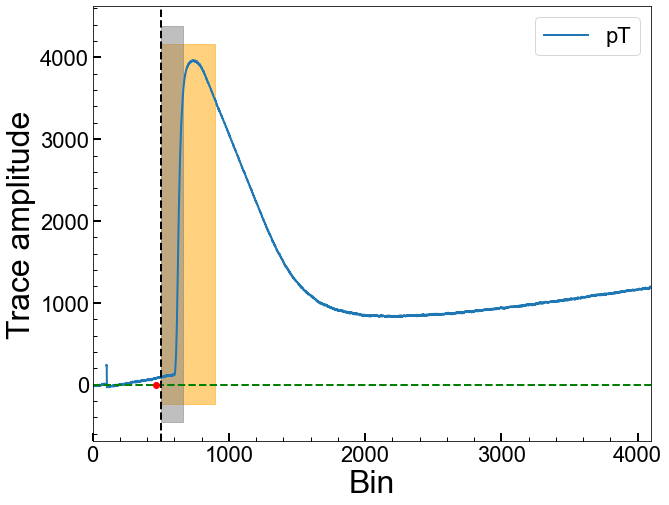

Series Number: 72209162200
Event Number: 3150288
Energy: 34.08515306094 keV


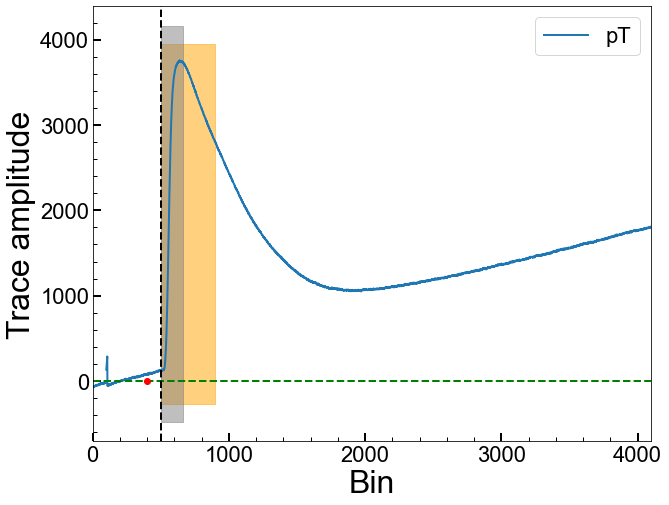

Series Number: 72209162200
Event Number: 3390608
Energy: 41.00164147379 keV


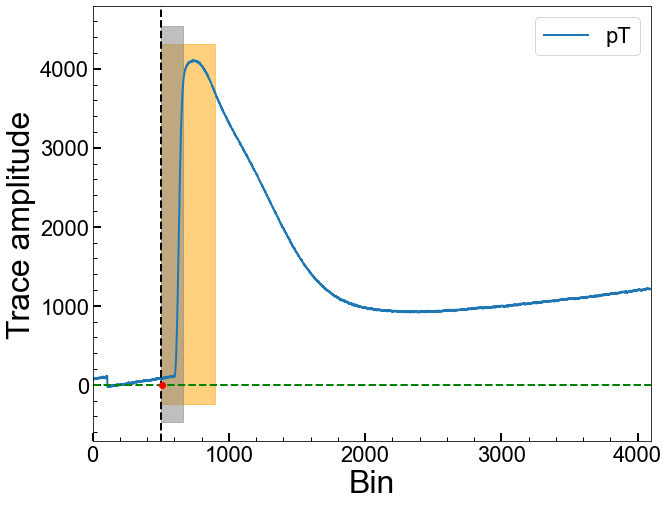

Series Number: 72209162200
Event Number: 3430119
Energy: 32.03605817262 keV


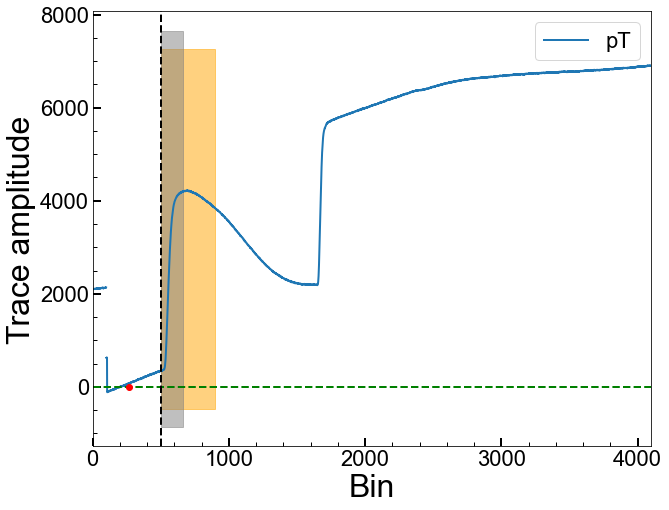

Series Number: 72209162200
Event Number: 3430598
Energy: 49.8815073324 keV


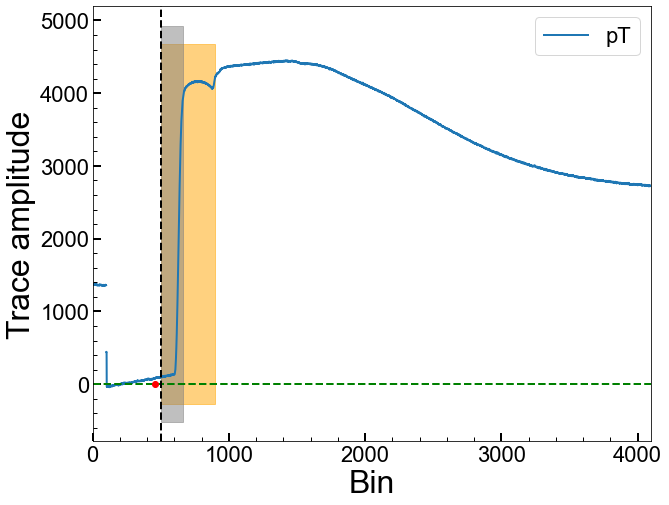

Series Number: 72209162200
Event Number: 3710851
Energy: 33.31666486587 keV


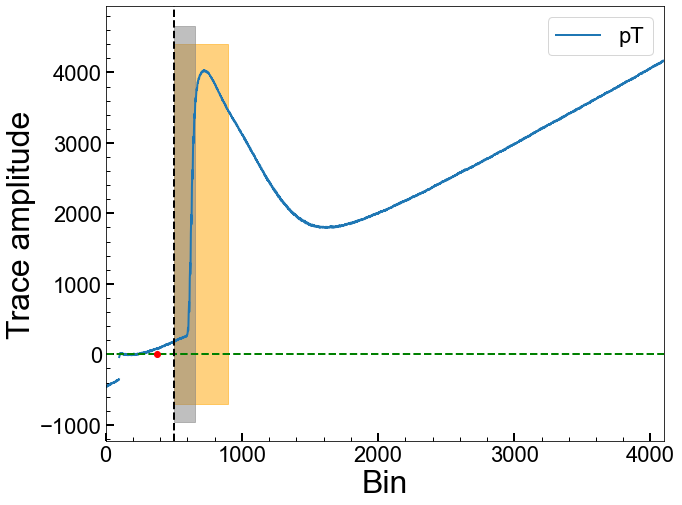

Series Number: 72209162200
Event Number: 3900223
Energy: 45.95803377221 keV


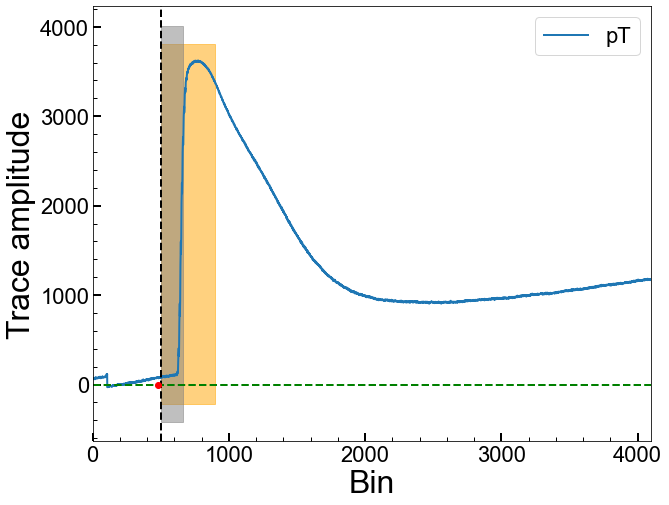

Series Number: 72209162200
Event Number: 4100643
Energy: 30.45051809168 keV


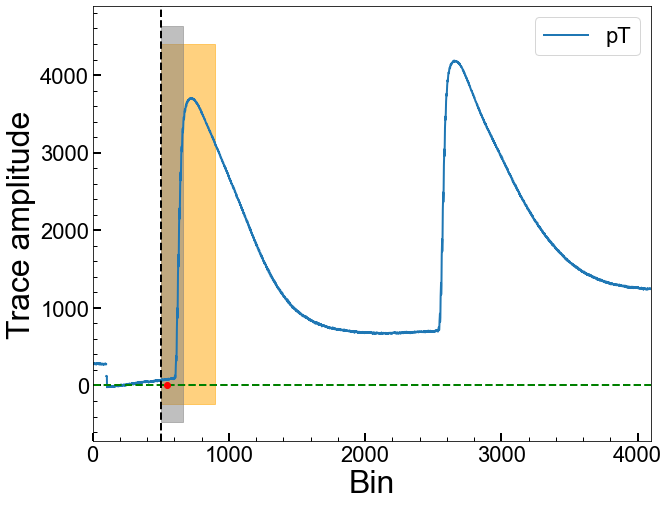

Series Number: 72209162200
Event Number: 4540360
Energy: 48.03140485235 keV


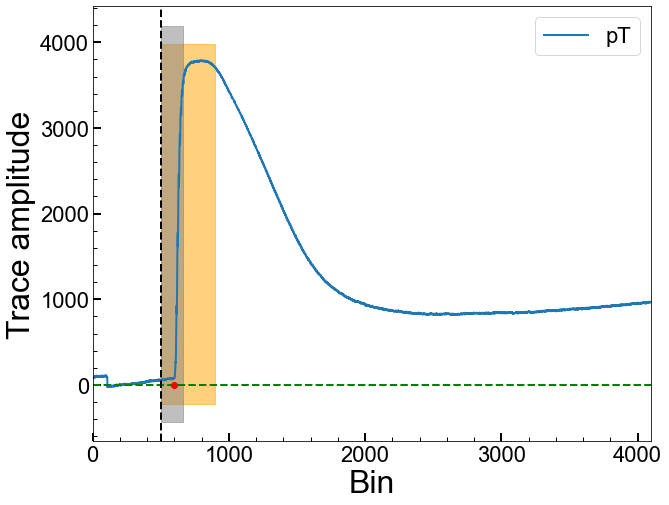

Series Number: 72209162200
Event Number: 4630374
Energy: 45.11111164114 keV


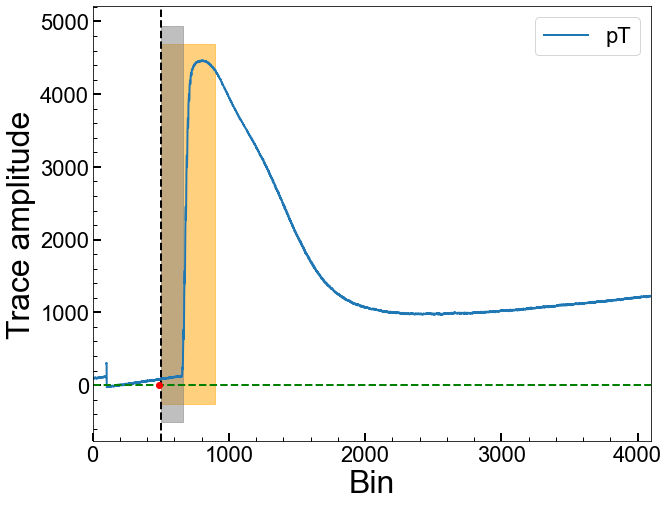

Series Number: 72209162200
Event Number: 4770218
Energy: 41.98196530883 keV


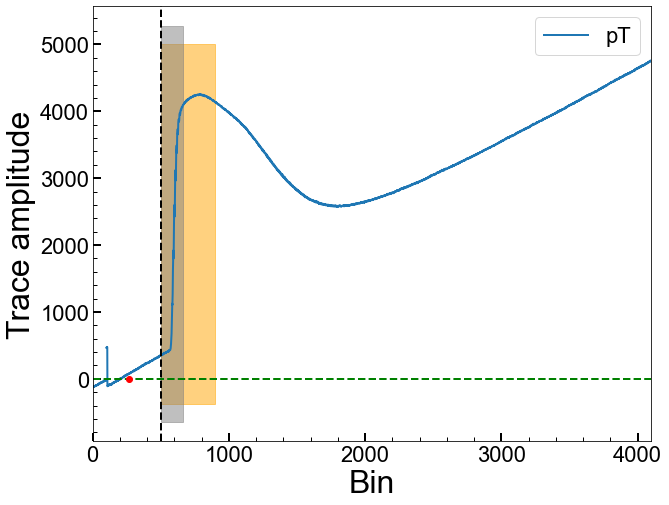

Series Number: 72209162200
Event Number: 4810796
Energy: 36.43634390353 keV


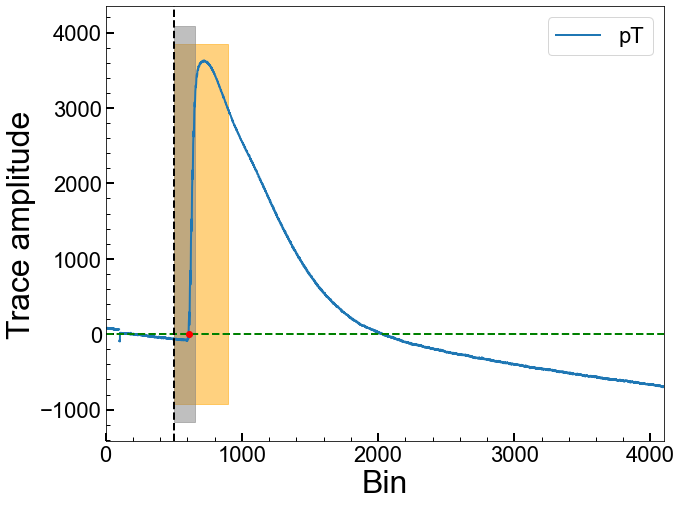

Series Number: 72209162200
Event Number: 5420021
Energy: 41.53972978058 keV


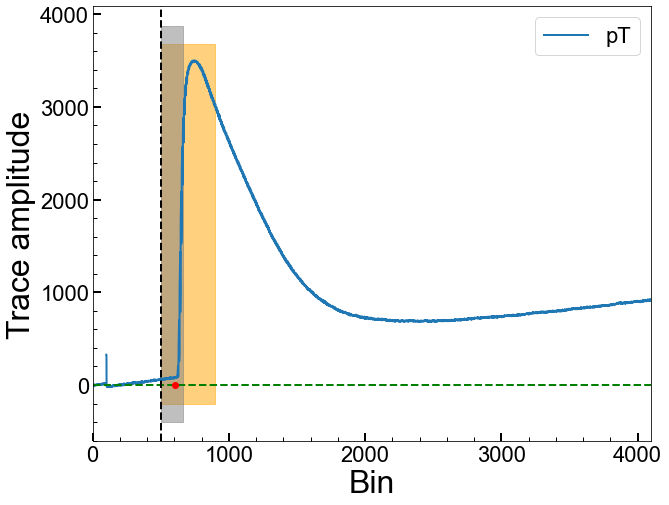

Series Number: 72209162200
Event Number: 5480186
Energy: 36.35741734522 keV


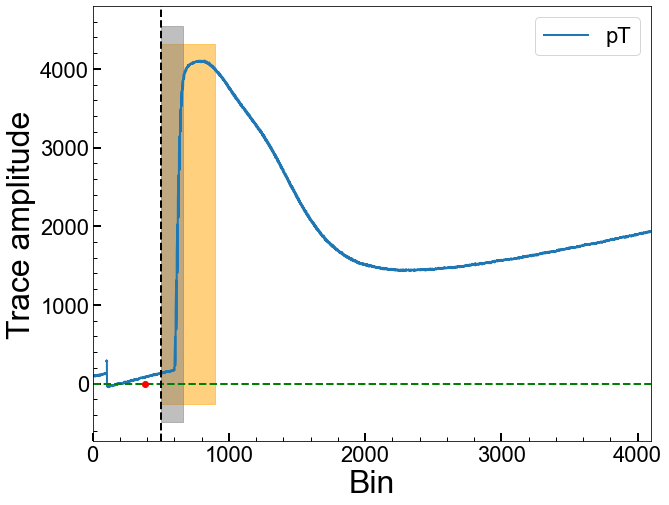

Series Number: 72209162200
Event Number: 5640434
Energy: 46.23784529851 keV


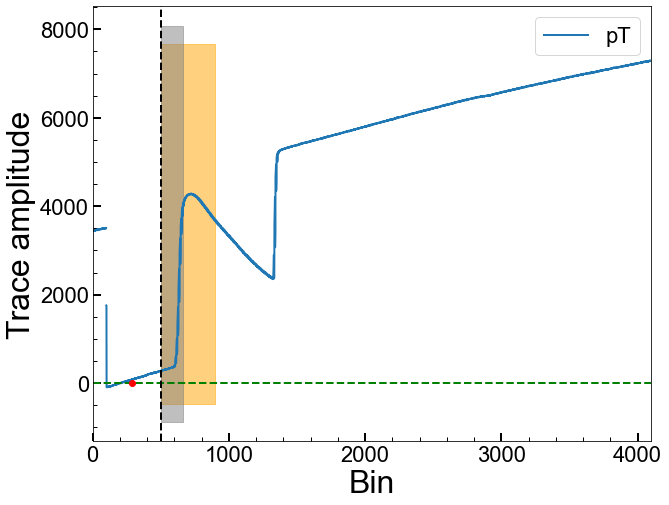

Series Number: 72209162200
Event Number: 5830579
Energy: 49.53848131416 keV


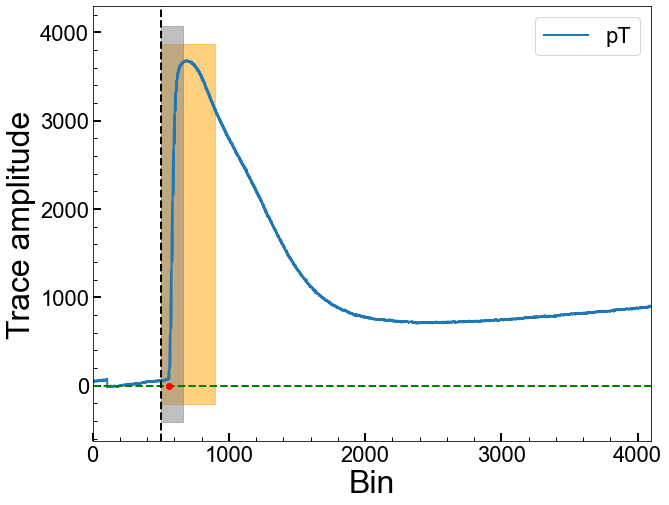

Series Number: 72209162200
Event Number: 5940049
Energy: 38.12098902167 keV


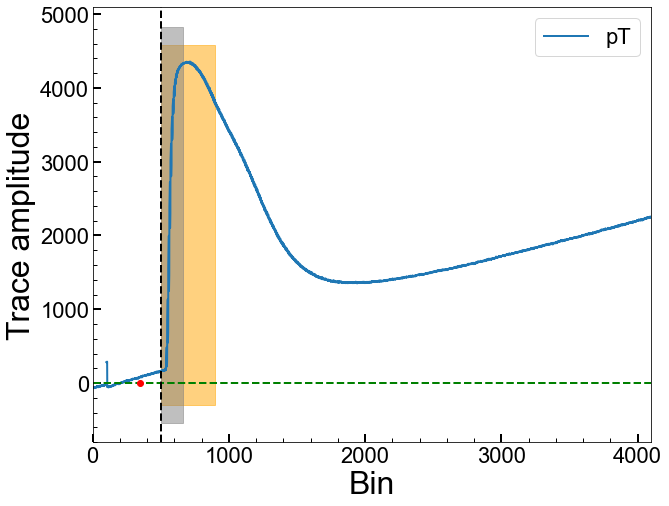

Series Number: 72209162200
Event Number: 5950460
Energy: 45.23014768465 keV


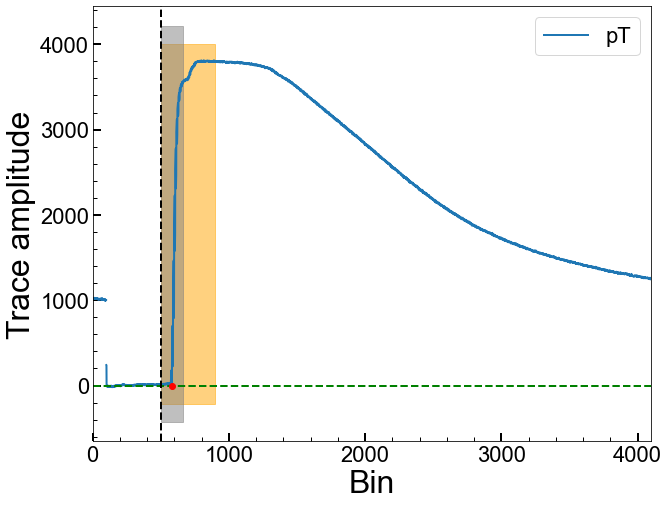

Series Number: 72209162200
Event Number: 6010388
Energy: 37.29845004939 keV


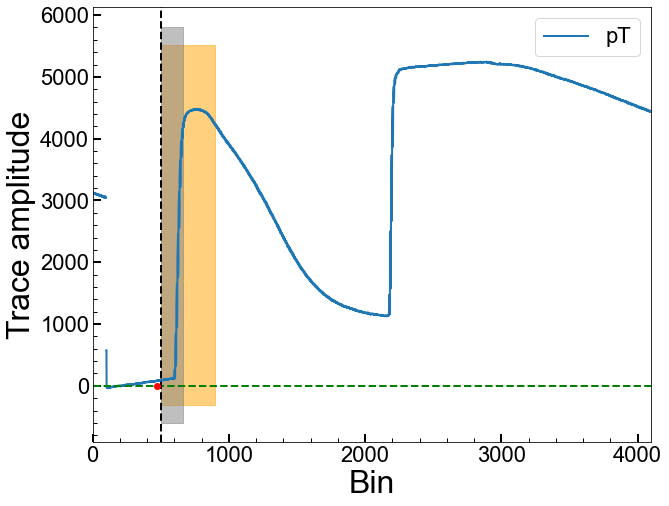

Series Number: 72209162200
Event Number: 6050033
Energy: 35.27750527578 keV


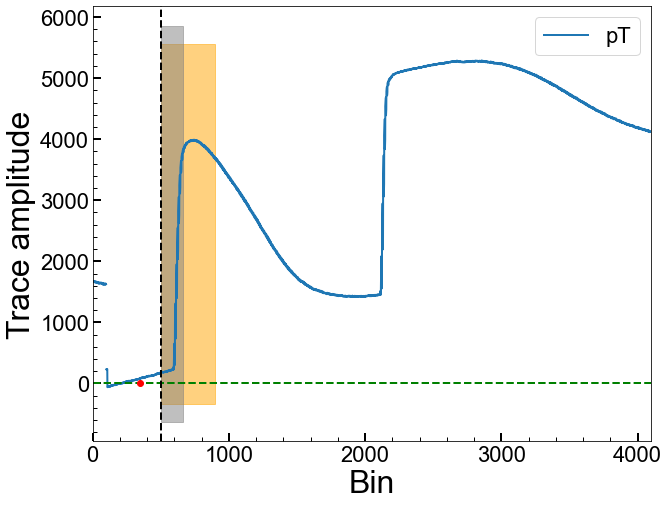

Series Number: 72209162200
Event Number: 6090706
Energy: 45.7306225786 keV


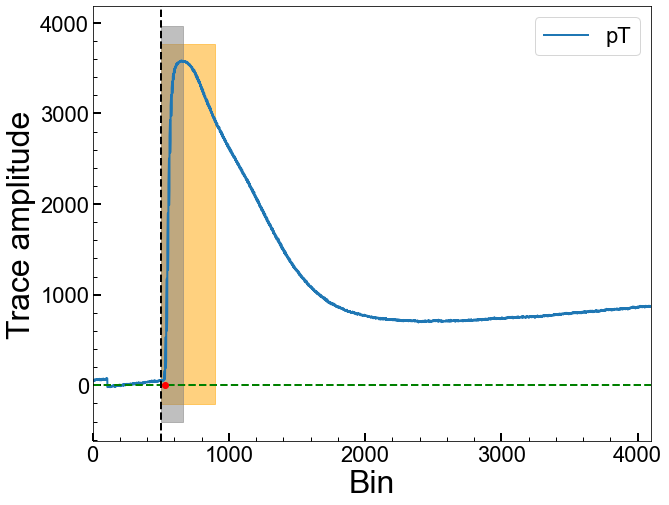

Series Number: 72209162200
Event Number: 6230832
Energy: 45.64817568418 keV


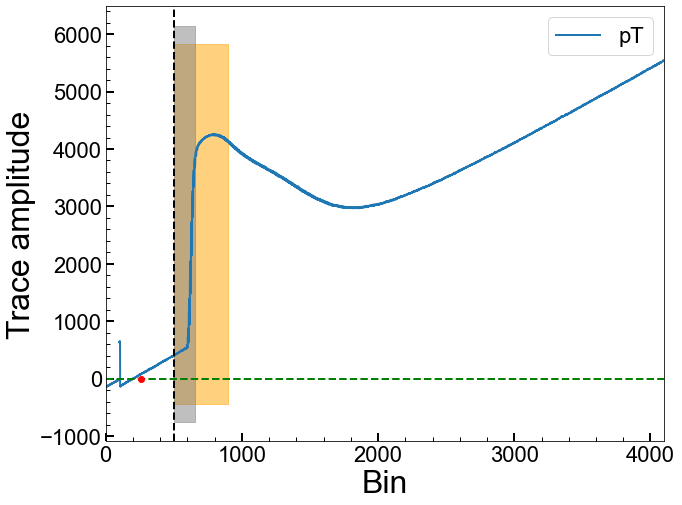

Series Number: 72209162200
Event Number: 6470790
Energy: 48.37486061023 keV


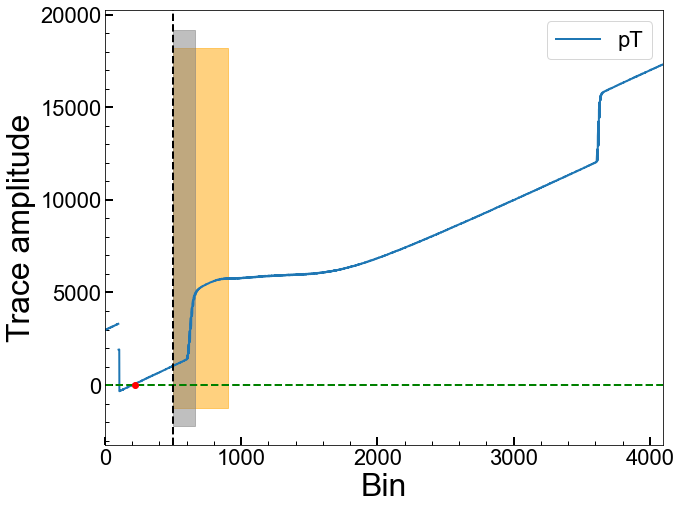

Series Number: 72209162200
Event Number: 6570296
Energy: 38.59146520713 keV


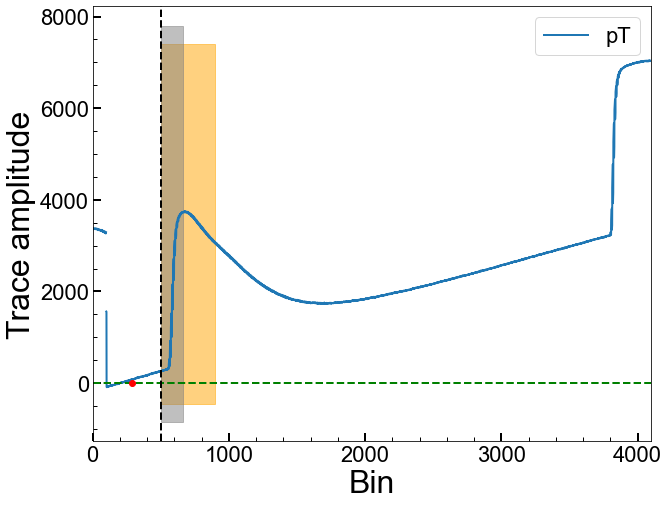

Series Number: 72209162200
Event Number: 6610717
Energy: 40.23007378752 keV


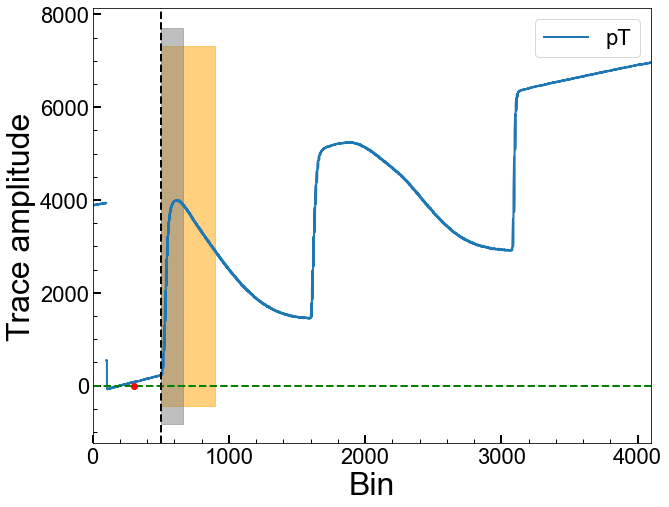

Series Number: 72209162200
Event Number: 7150213
Energy: 47.21011927114 keV


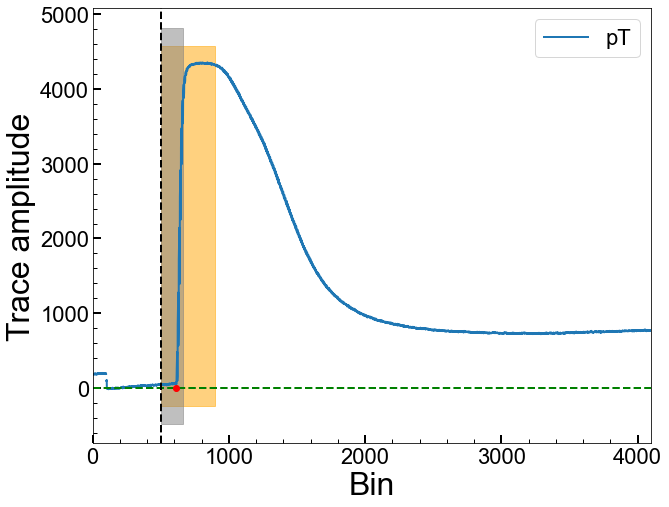

Series Number: 72209162200
Event Number: 7220890
Energy: 30.48805328357 keV


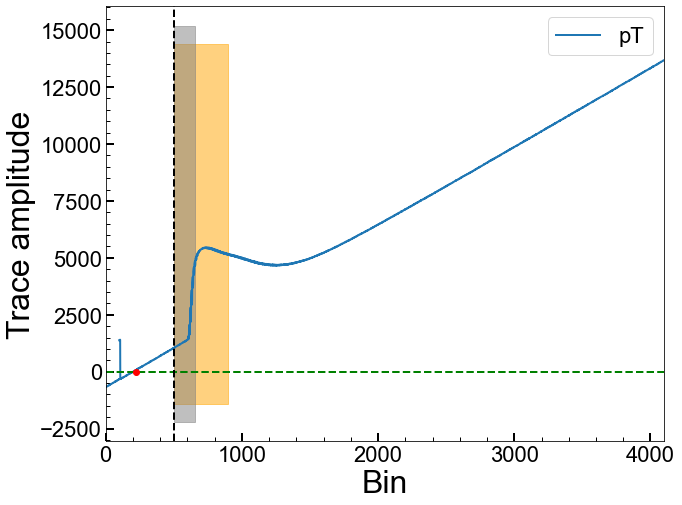

Series Number: 72209162200
Event Number: 7230343
Energy: 30.56351714512 keV


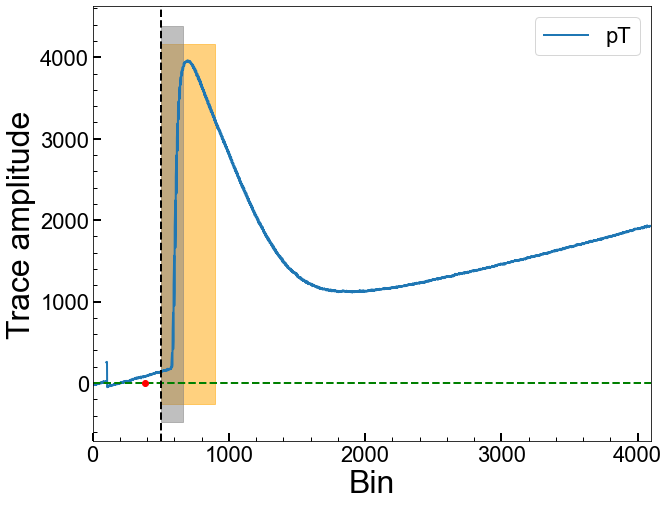

Series Number: 72209162200
Event Number: 7300339
Energy: 47.8145509351 keV


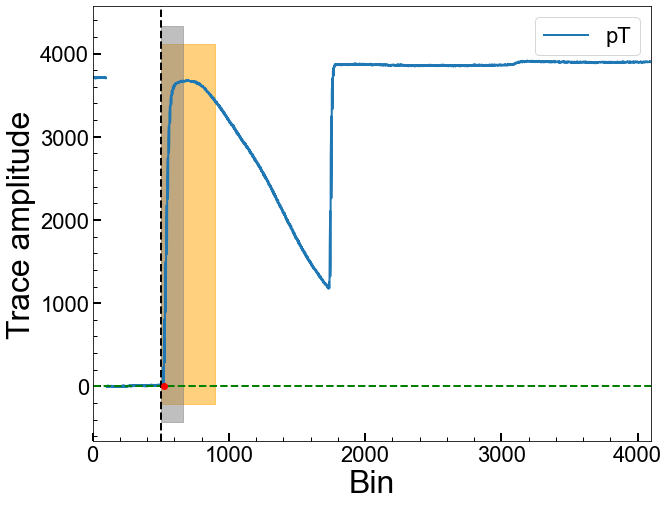

Series Number: 72209162200
Event Number: 7350397
Energy: 43.7252858962 keV


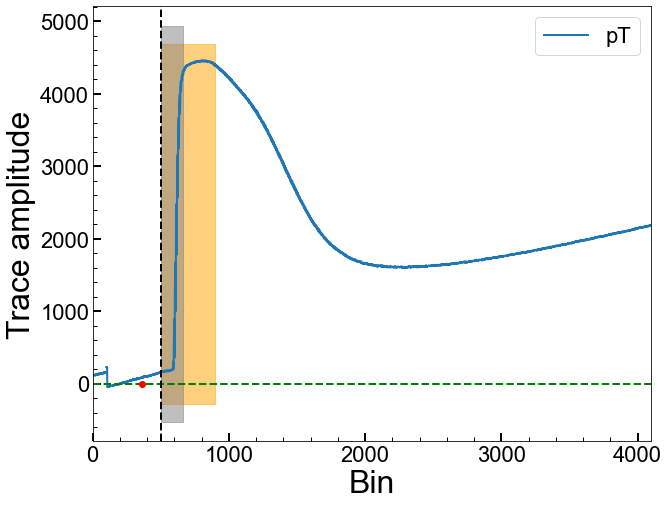

Series Number: 72209162200
Event Number: 7370515
Energy: 32.83239834487 keV


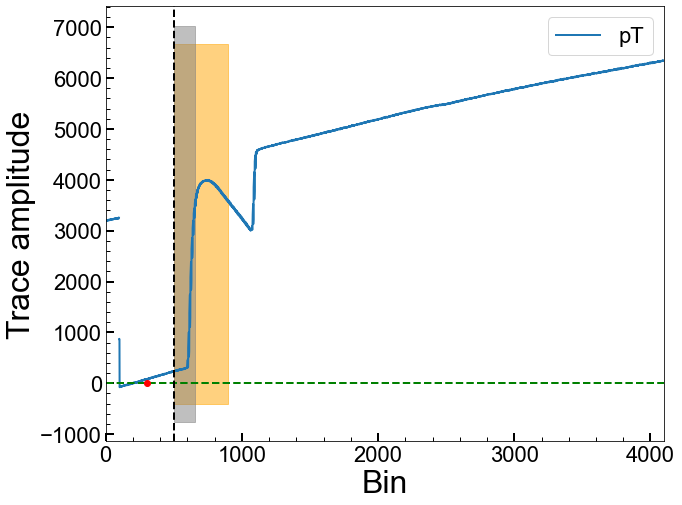

Series Number: 72209171225
Event Number: 300068
Energy: 32.89290741209 keV


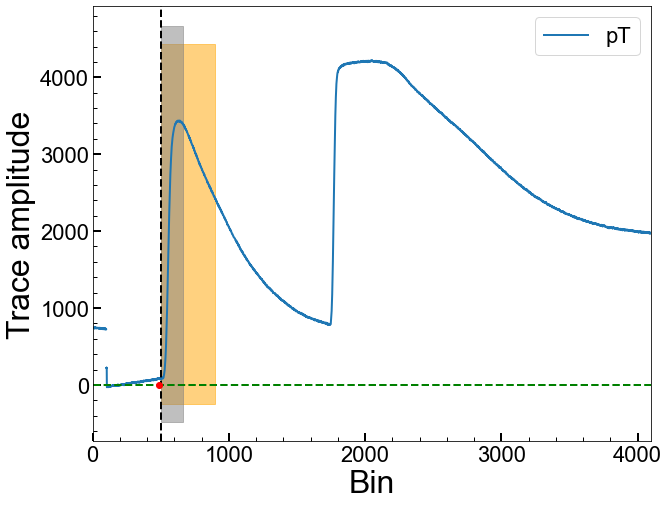

Series Number: 72209171225
Event Number: 560760
Energy: 34.95661758919 keV


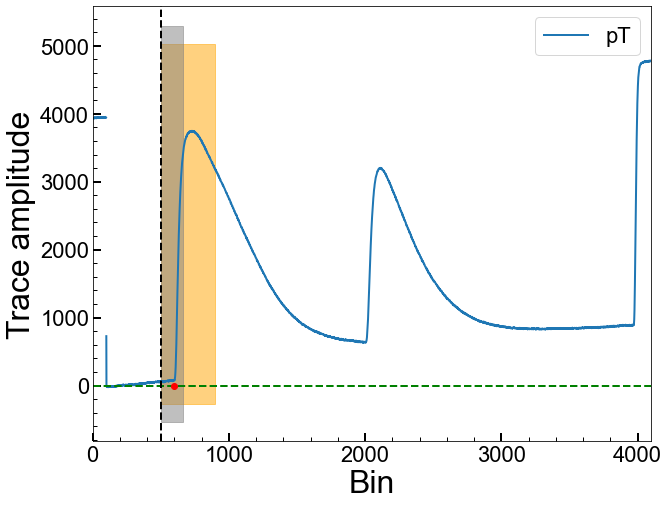

Series Number: 72209171225
Event Number: 590460
Energy: 34.58209807431 keV


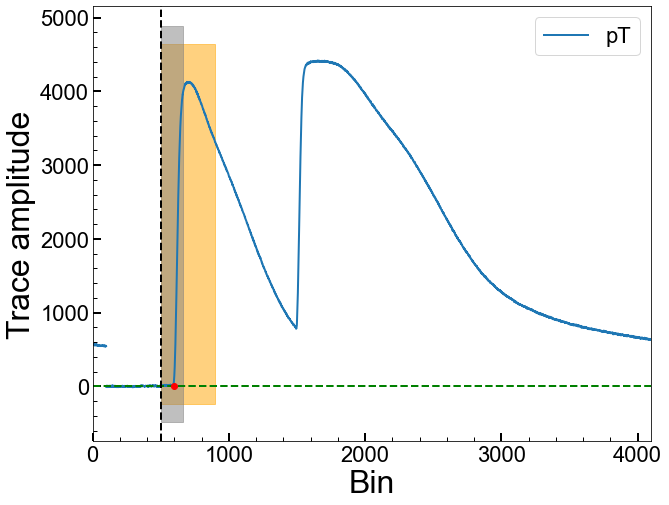

Series Number: 72209171225
Event Number: 600703
Energy: 46.11694469458 keV


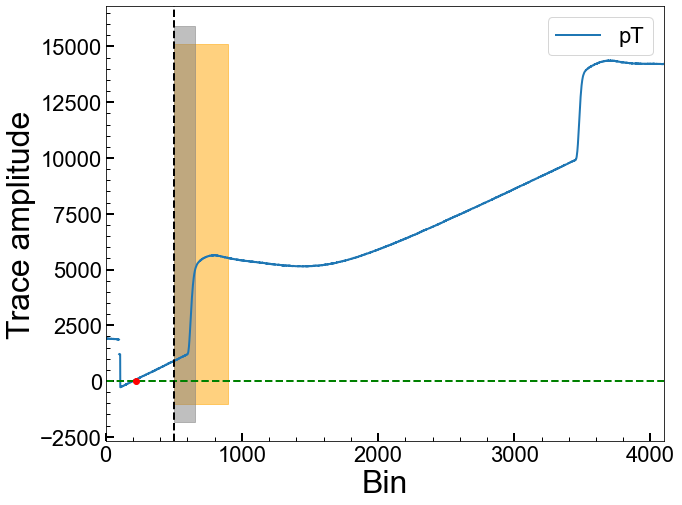

Series Number: 72209171225
Event Number: 780415
Energy: 47.34155838674 keV


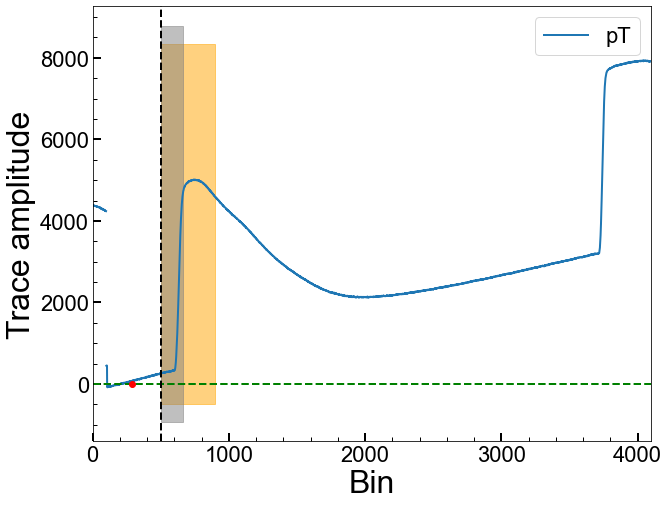

Series Number: 72209171225
Event Number: 880361
Energy: 39.0480913313 keV


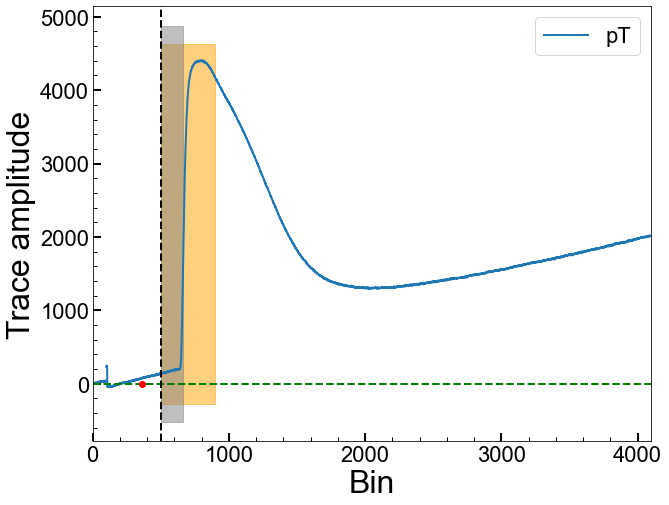

Series Number: 72209171225
Event Number: 1310232
Energy: 47.67562335231 keV


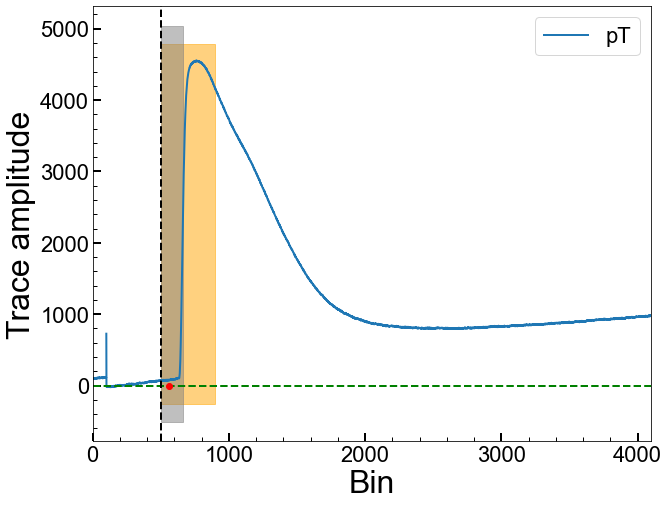

Series Number: 72209171225
Event Number: 1400479
Energy: 35.41937727087 keV


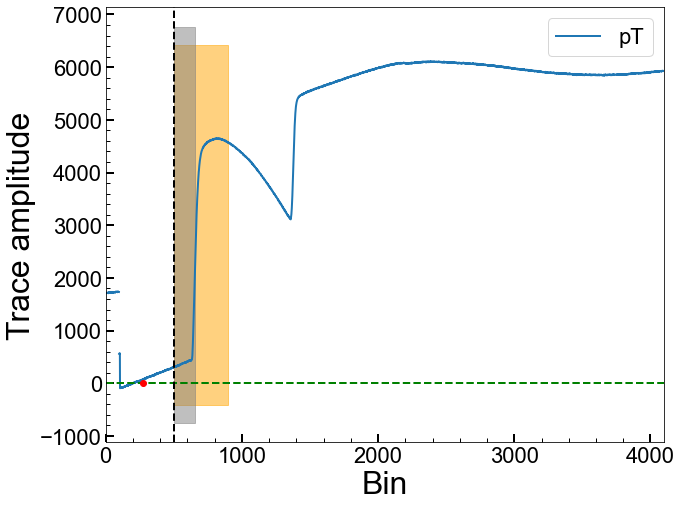

Series Number: 72209171225
Event Number: 1750297
Energy: 40.22401009321 keV


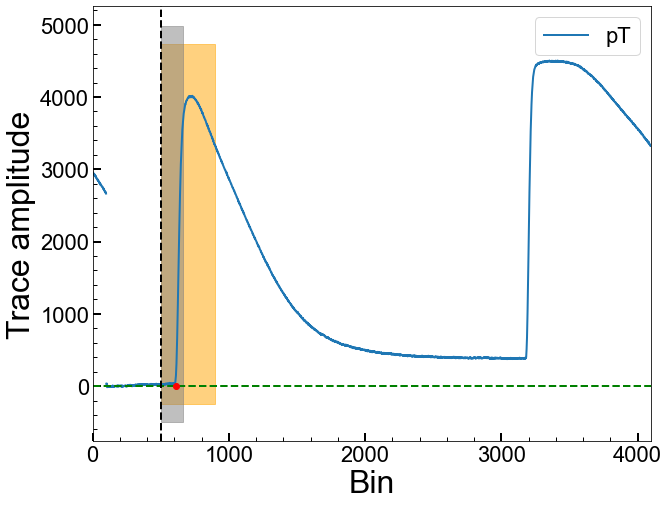

Series Number: 72209171225
Event Number: 1960296
Energy: 48.45227217595 keV


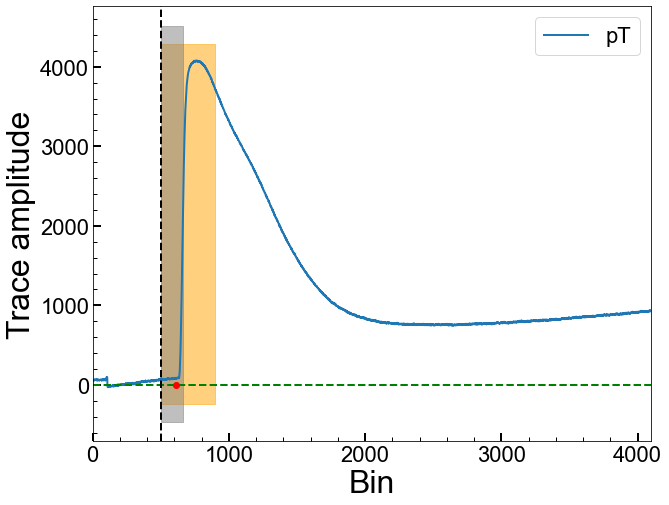

Series Number: 72209171225
Event Number: 2030110
Energy: 36.32906431983 keV


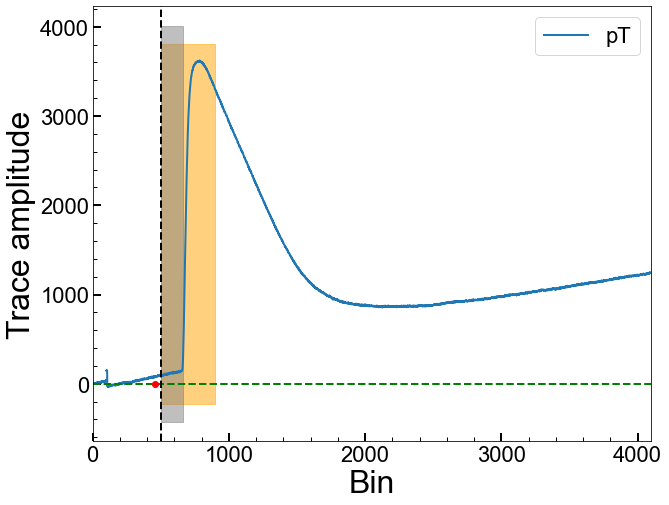

Series Number: 72209171225
Event Number: 2050439
Energy: 32.55553816804 keV


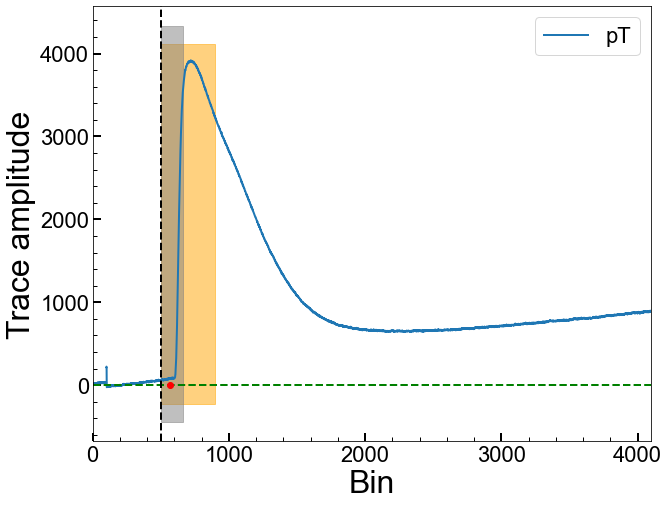

Series Number: 72209171225
Event Number: 2060186
Energy: 39.57512594484 keV


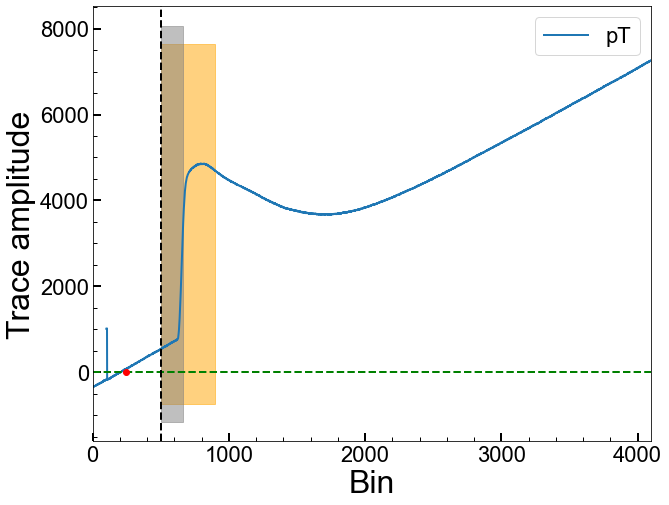

Series Number: 72209171225
Event Number: 2100507
Energy: 39.73864128248 keV


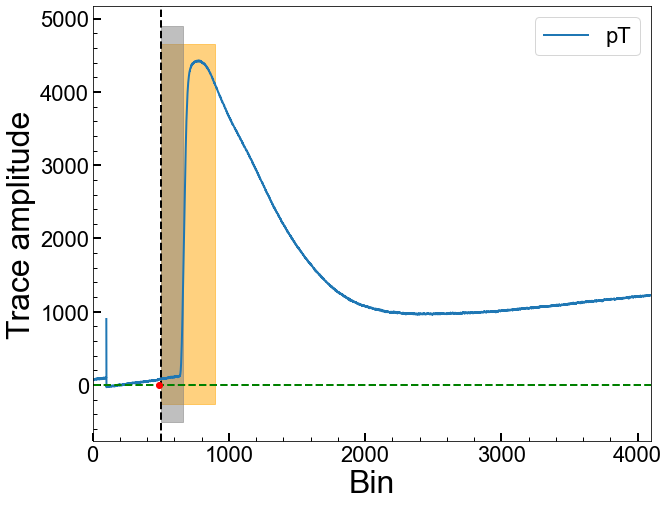

Series Number: 72209171225
Event Number: 2100726
Energy: 40.85314616115 keV


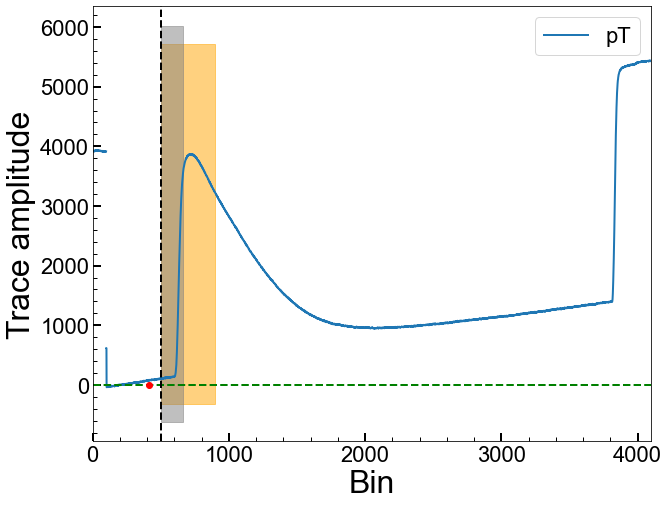

Series Number: 72209171225
Event Number: 2170166
Energy: 41.19097968343 keV


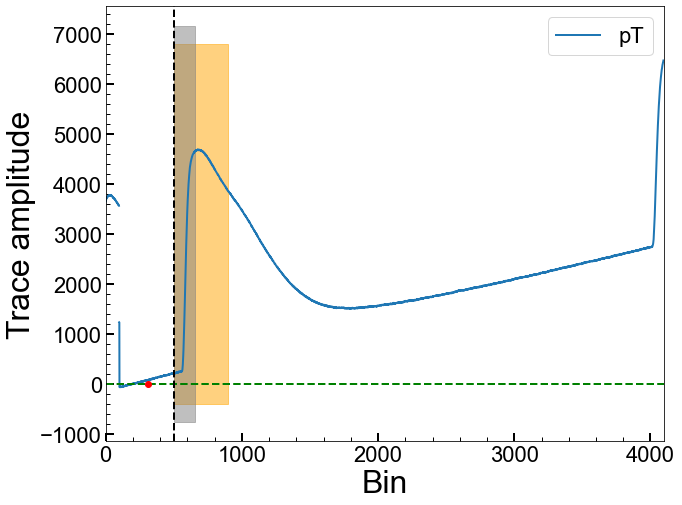

Series Number: 72209171225
Event Number: 2220296
Energy: 40.18558837798 keV


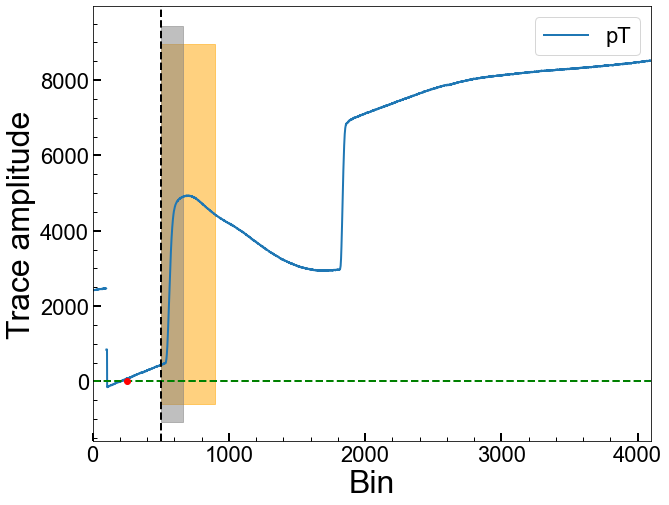

Series Number: 72209171225
Event Number: 2340432
Energy: 45.75460347061 keV


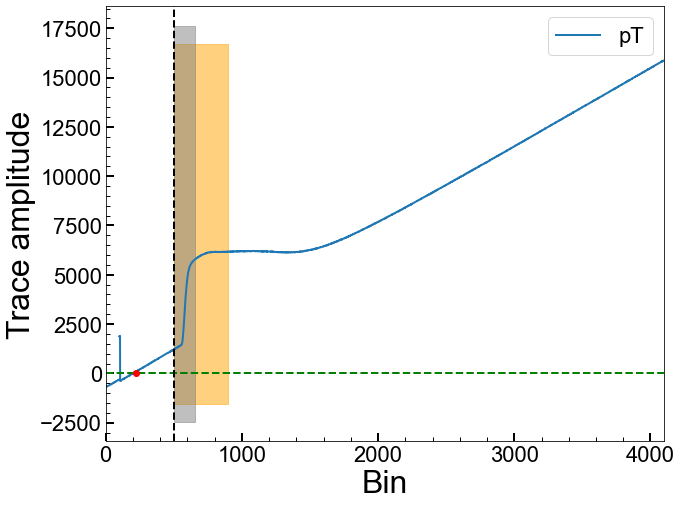

Series Number: 72209171225
Event Number: 2530121
Energy: 47.10099079395 keV


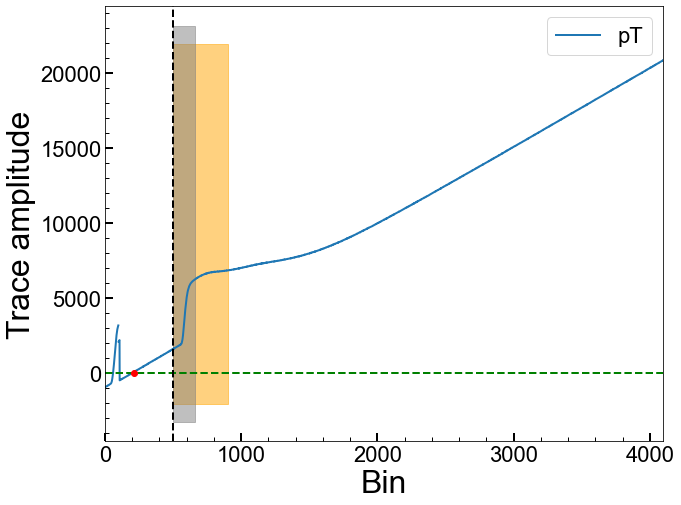

Series Number: 72209171225
Event Number: 2640228
Energy: 43.14447842959 keV


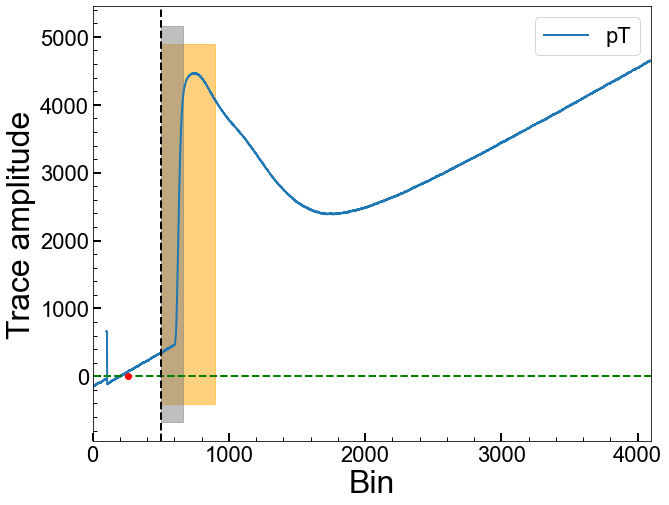

Series Number: 72209171225
Event Number: 2640579
Energy: 30.18055270313 keV


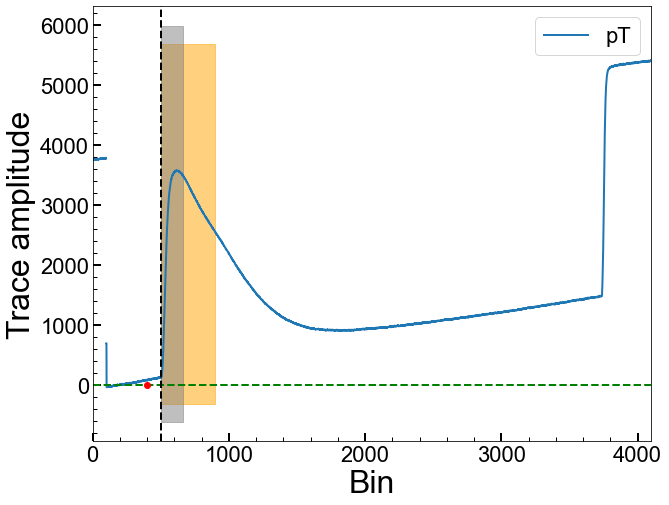

Series Number: 72209171225
Event Number: 2900617
Energy: 43.0335593464 keV


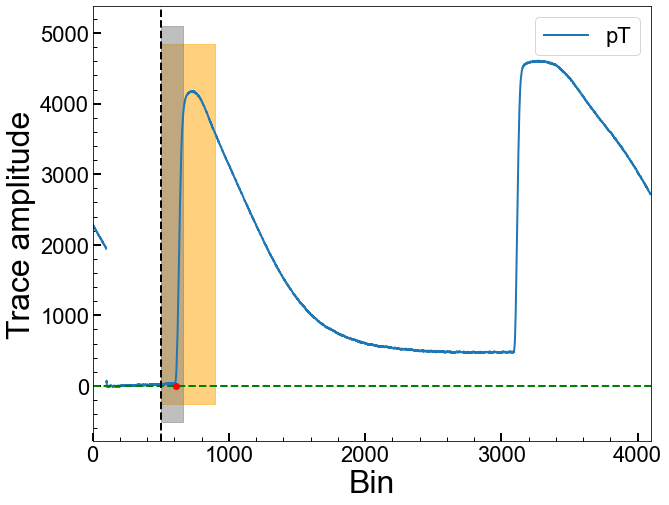

Series Number: 72209171225
Event Number: 2940228
Energy: 48.55329150194 keV


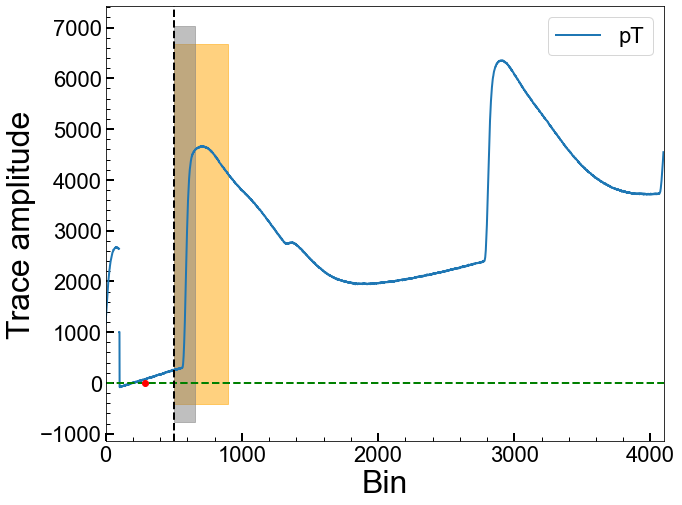

Series Number: 72209171225
Event Number: 3040695
Energy: 32.80725080574 keV


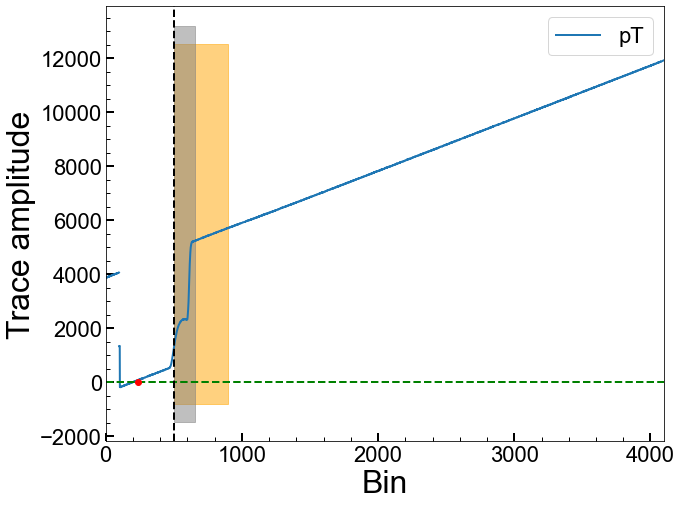

Series Number: 72209171225
Event Number: 3240393
Energy: 38.16445118885 keV


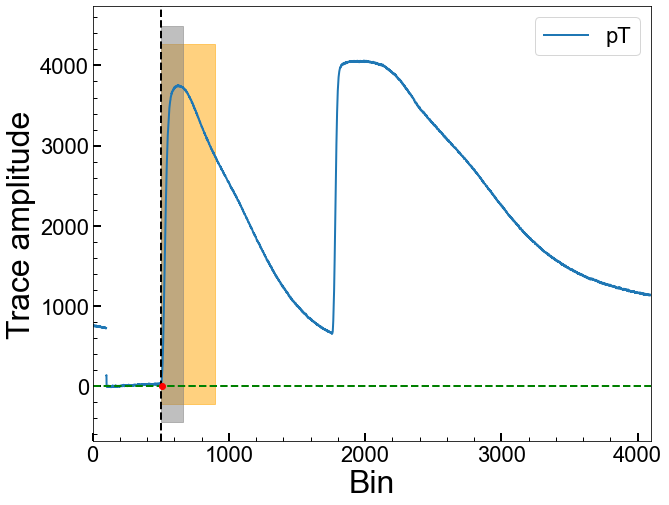

Series Number: 72209171225
Event Number: 3370612
Energy: 47.31216068962 keV


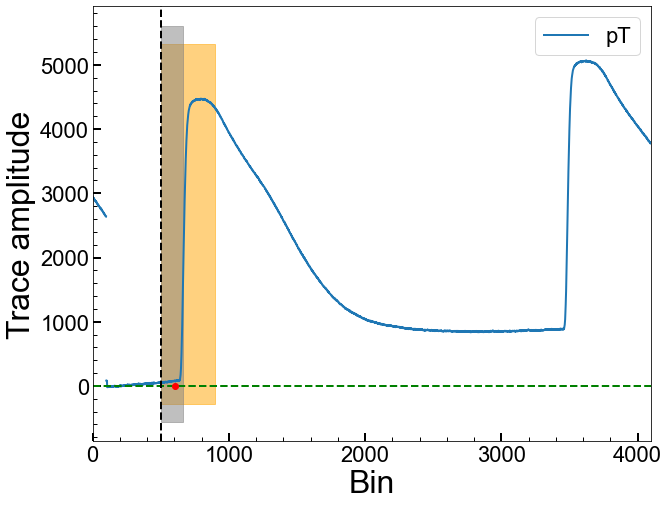

Series Number: 72209171225
Event Number: 3490454
Energy: 44.70618161179 keV


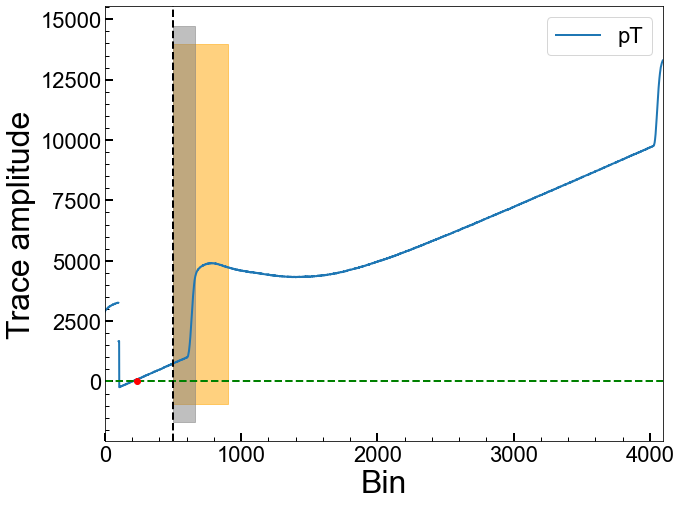

Series Number: 72209171225
Event Number: 3490810
Energy: 45.07092303122 keV


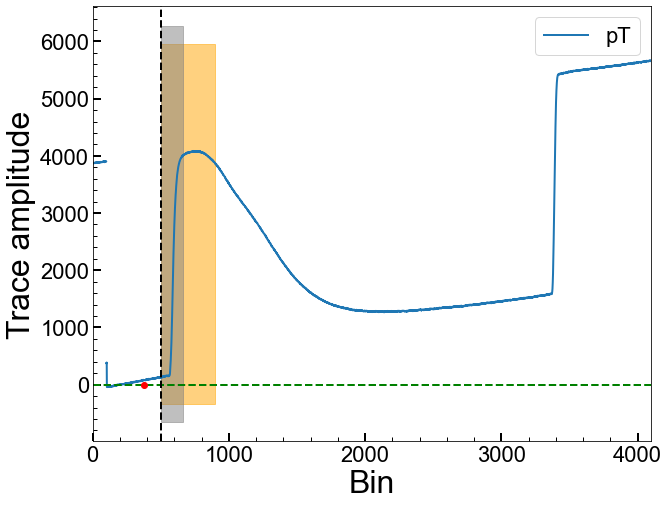

Series Number: 72209171225
Event Number: 3590722
Energy: 34.16357409052 keV


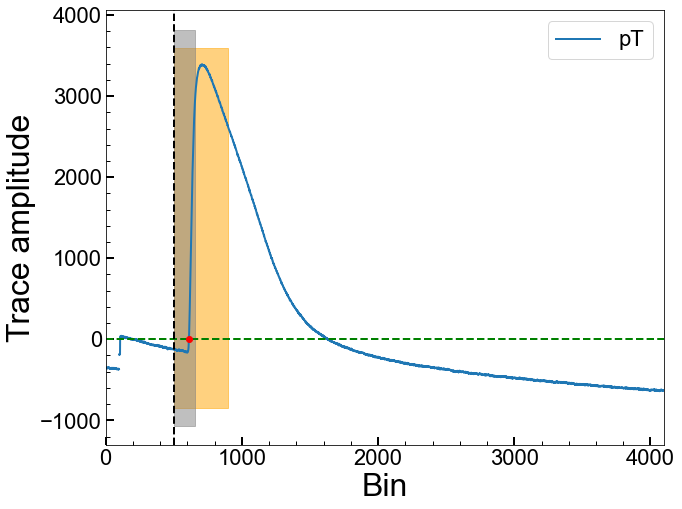

Series Number: 72209171225
Event Number: 3840533
Energy: 38.67774402173 keV


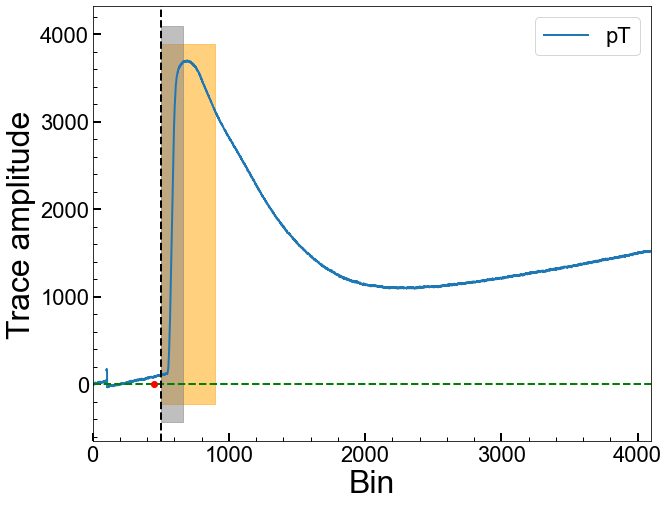

Series Number: 72209171225
Event Number: 3920450
Energy: 39.30297202985 keV


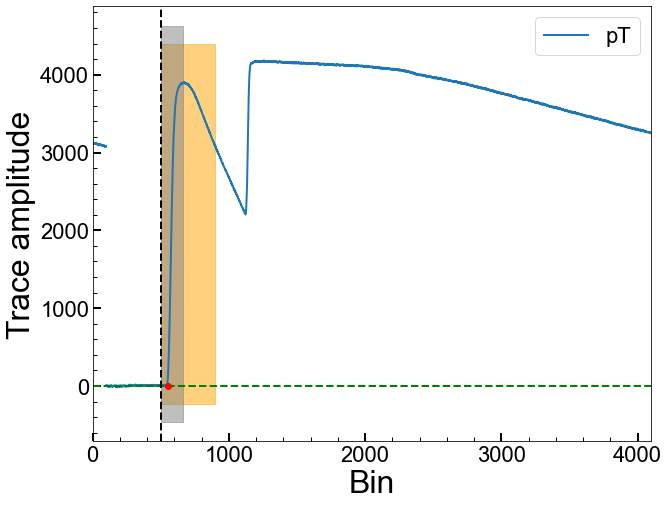

Series Number: 72209171225
Event Number: 4080643
Energy: 49.10331614283 keV


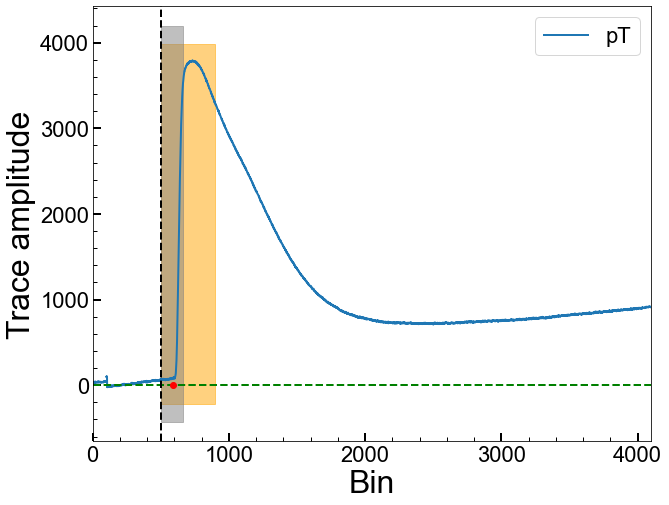

Series Number: 72209171225
Event Number: 4120723
Energy: 31.78077121466 keV


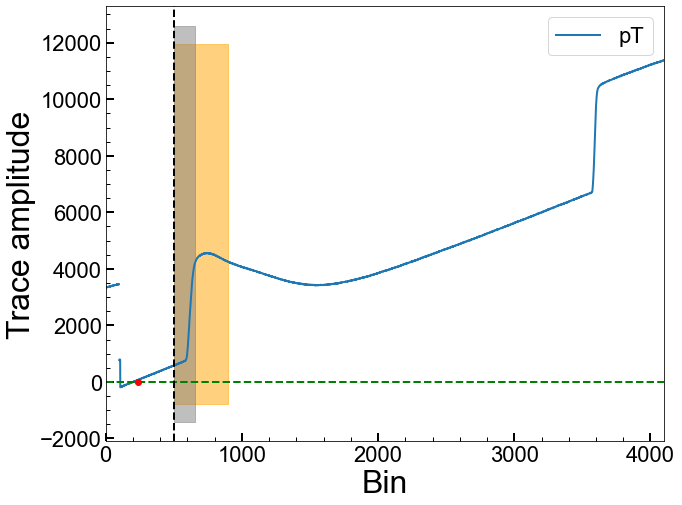

Series Number: 72209171225
Event Number: 4300405
Energy: 39.13542782909 keV


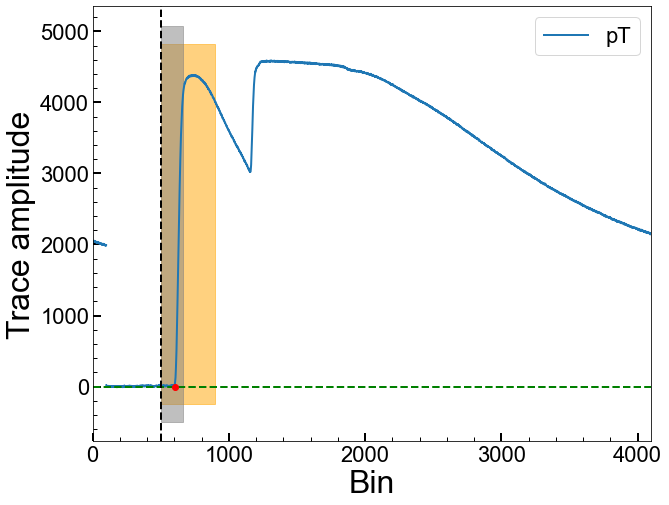

Series Number: 72209171225
Event Number: 4320878
Energy: 45.19280980088 keV


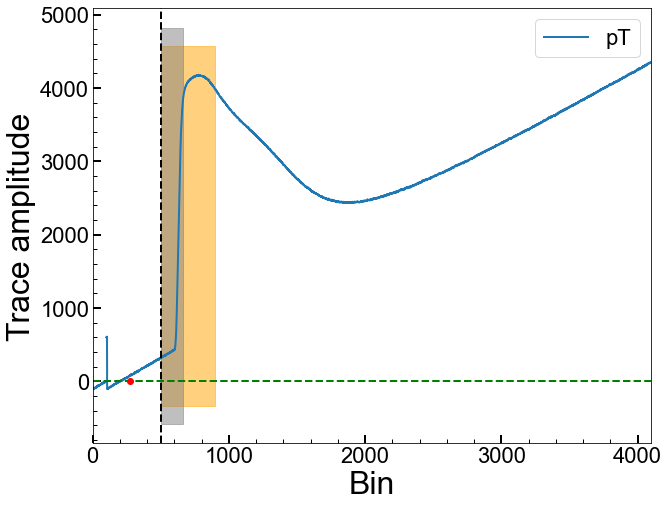

Series Number: 72209171225
Event Number: 4360412
Energy: 40.30914213745 keV


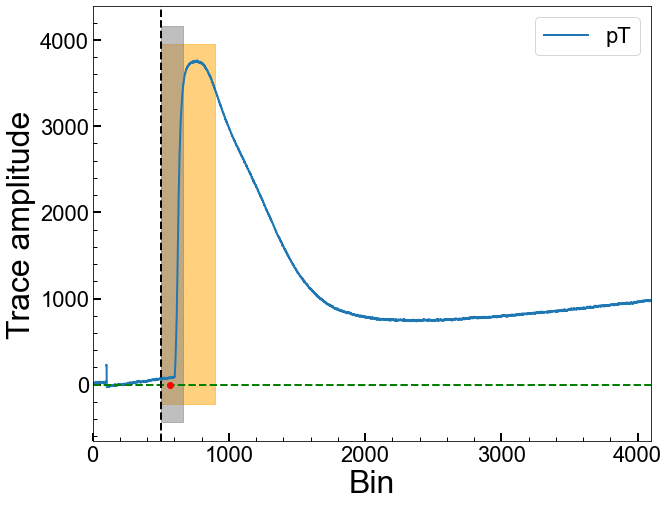

Series Number: 72209171225
Event Number: 4390192
Energy: 39.9012270286 keV


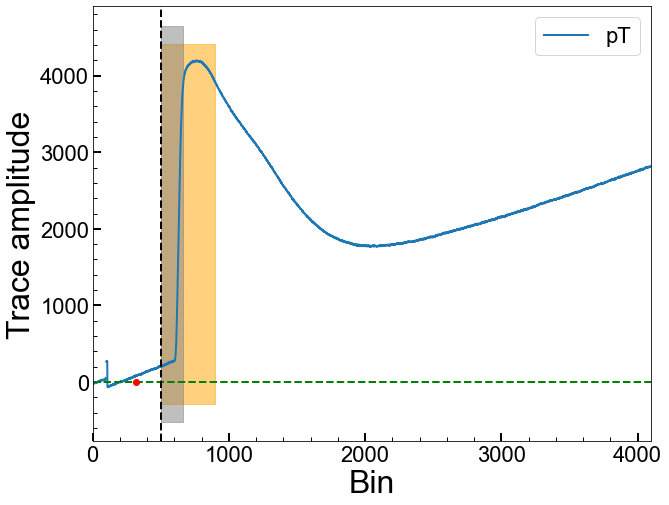

Series Number: 72209171225
Event Number: 4690750
Energy: 46.31645802266 keV


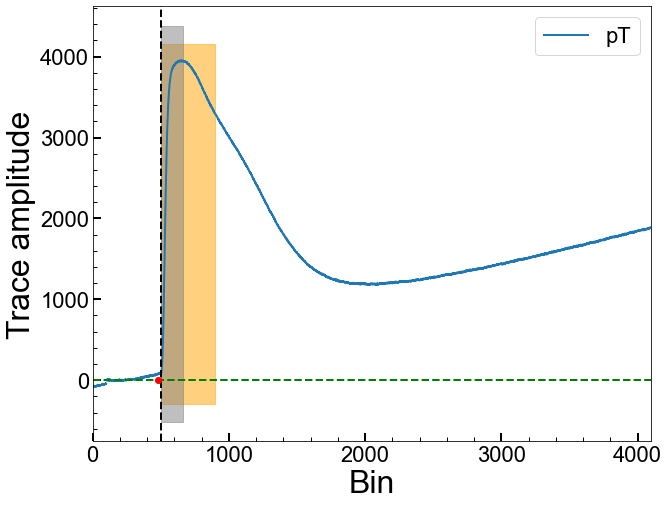

Series Number: 72209171225
Event Number: 4740844
Energy: 39.55060167459 keV


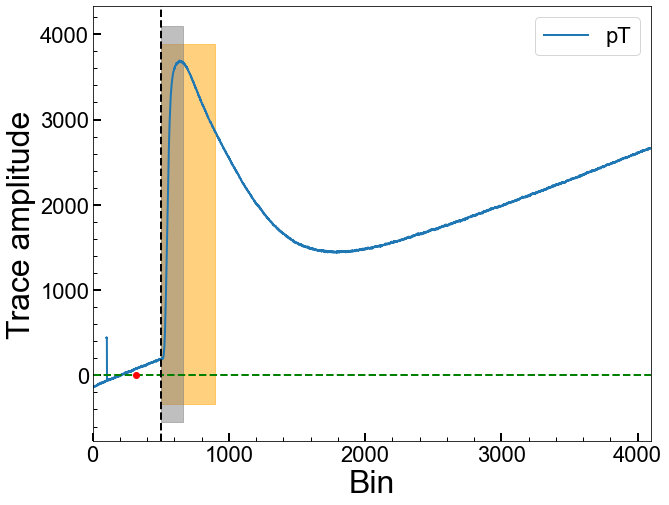

Series Number: 72209171225
Event Number: 4950033
Energy: 47.41182847994 keV


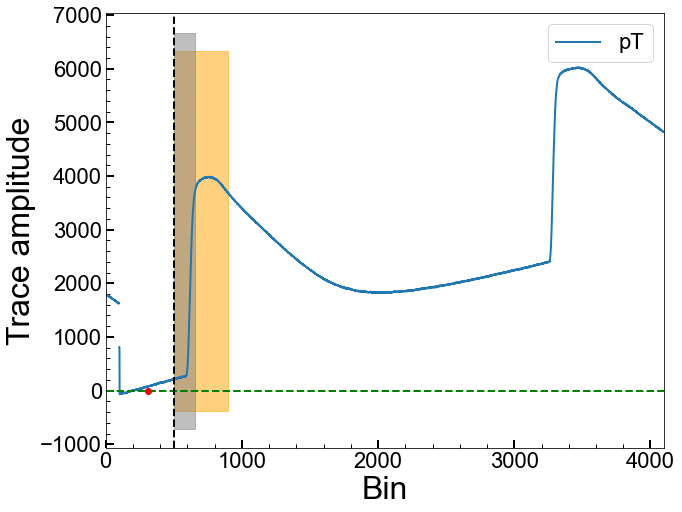

Series Number: 72209171225
Event Number: 5030407
Energy: 33.40722041091 keV


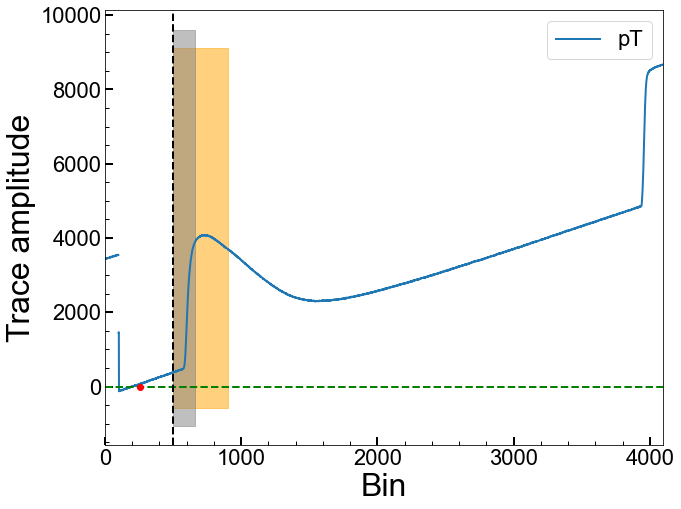

Series Number: 72209171225
Event Number: 5050474
Energy: 48.46690036178 keV


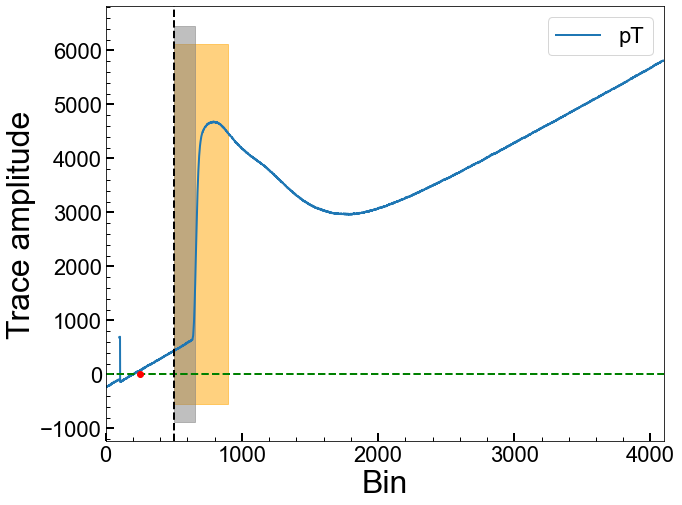

Series Number: 72209171225
Event Number: 5060642
Energy: 49.74976526863 keV


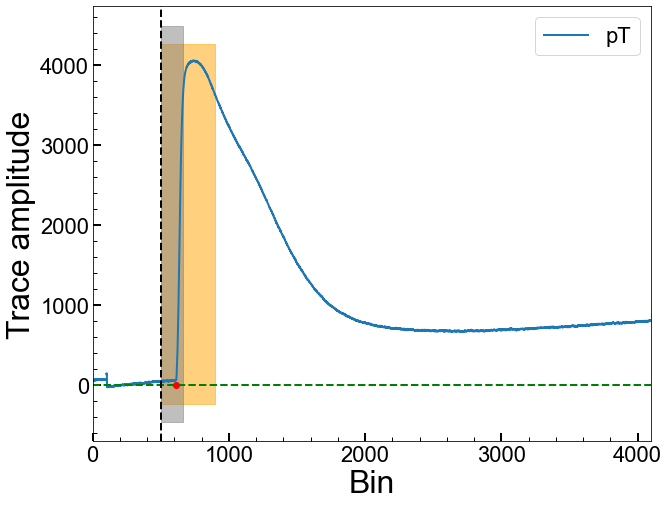

Series Number: 72209171225
Event Number: 5180397
Energy: 37.9189477984 keV


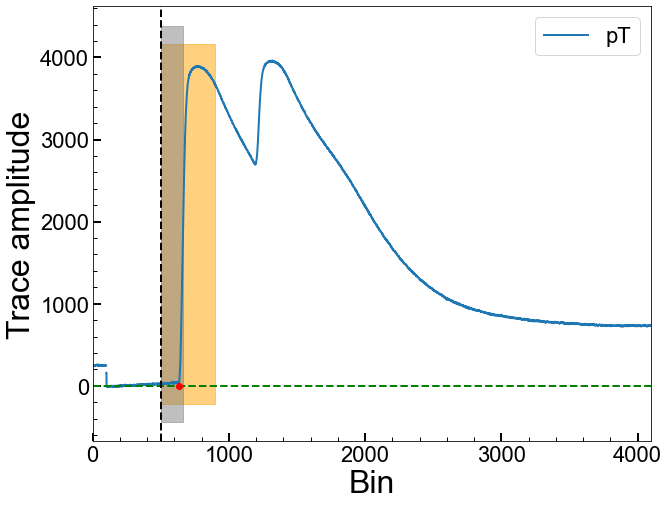

Series Number: 72209171225
Event Number: 5230527
Energy: 39.22535218816 keV


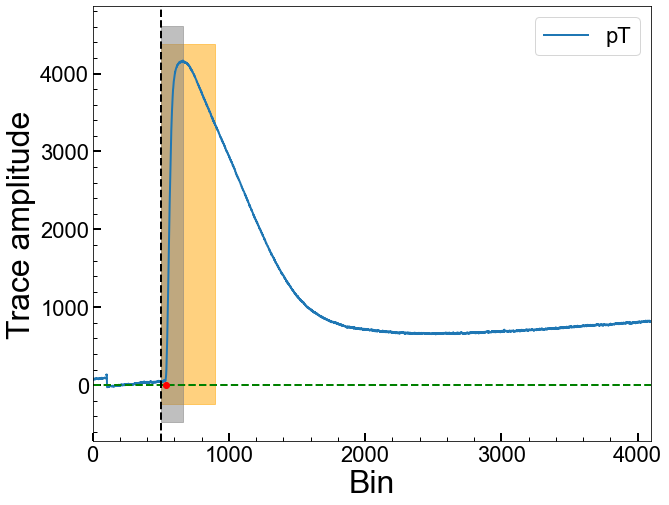

Series Number: 72209172155
Event Number: 290528
Energy: 31.06828588846 keV


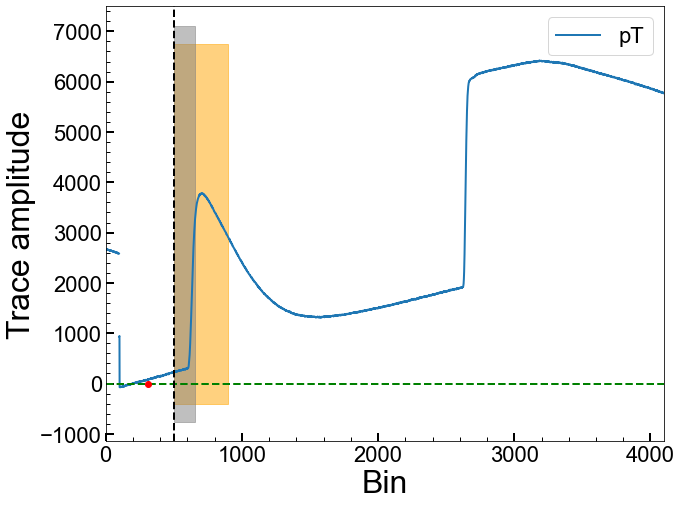

Series Number: 72209172155
Event Number: 490349
Energy: 35.31733253288 keV


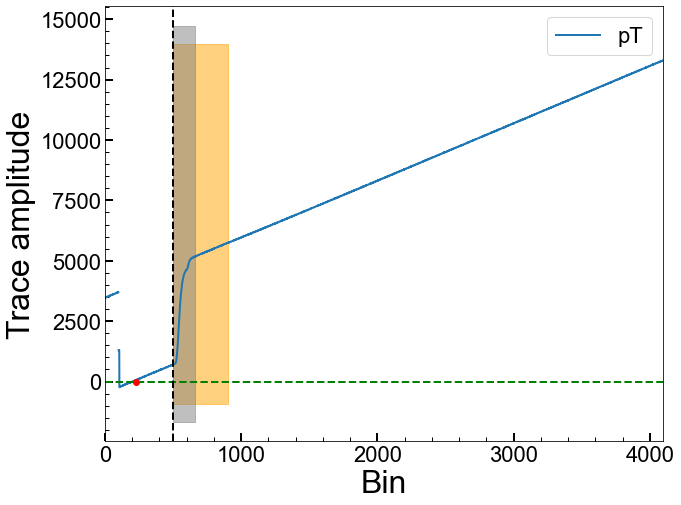

Series Number: 72209172155
Event Number: 570919
Energy: 32.74413780547 keV


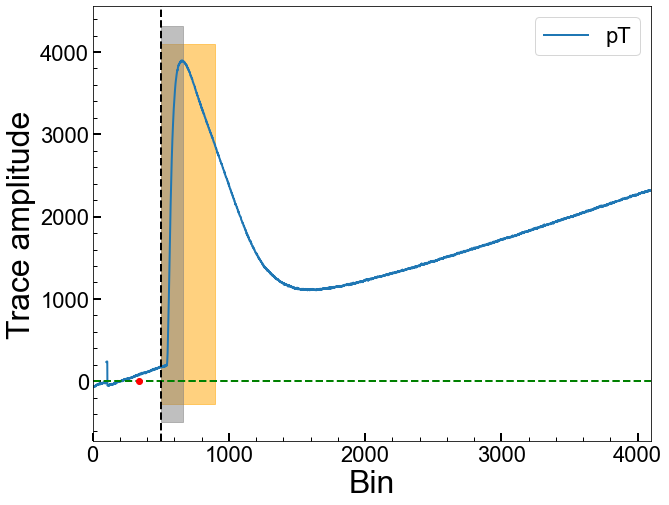

Series Number: 72209172155
Event Number: 590312
Energy: 37.82920093215 keV


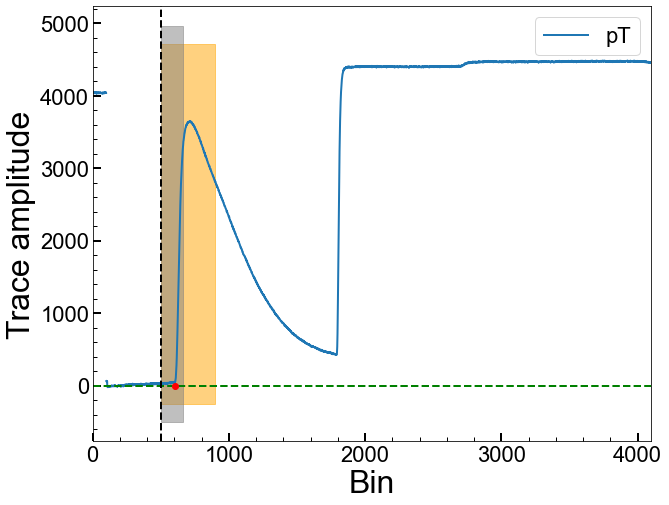

Series Number: 72209172155
Event Number: 710383
Energy: 31.27584991062 keV


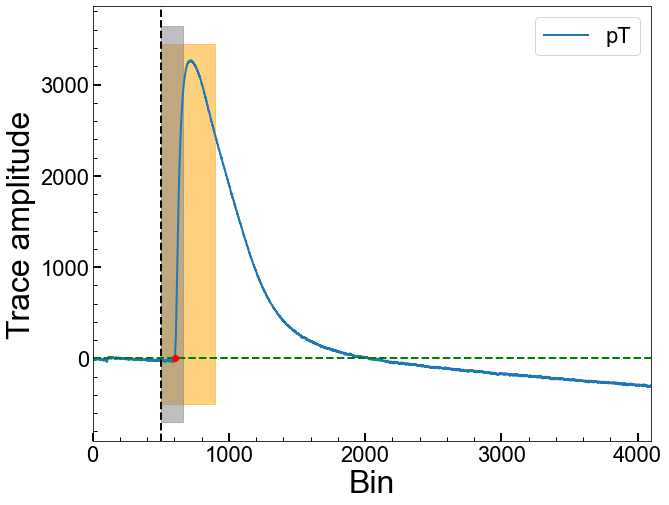

Series Number: 72209172155
Event Number: 720047
Energy: 48.2761034771 keV


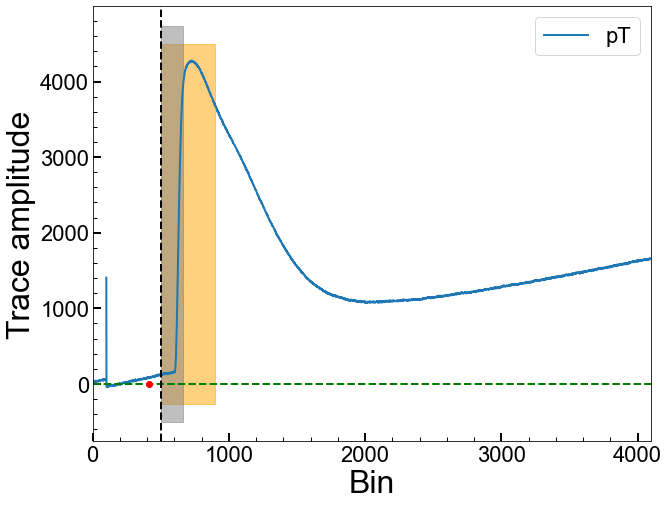

Series Number: 72209172155
Event Number: 1080099
Energy: 47.54789366116 keV


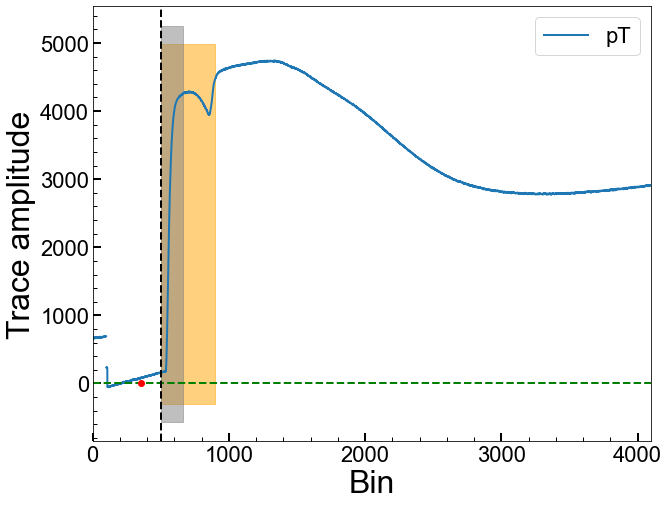

Series Number: 72209172155
Event Number: 1550508
Energy: 33.27898457197 keV


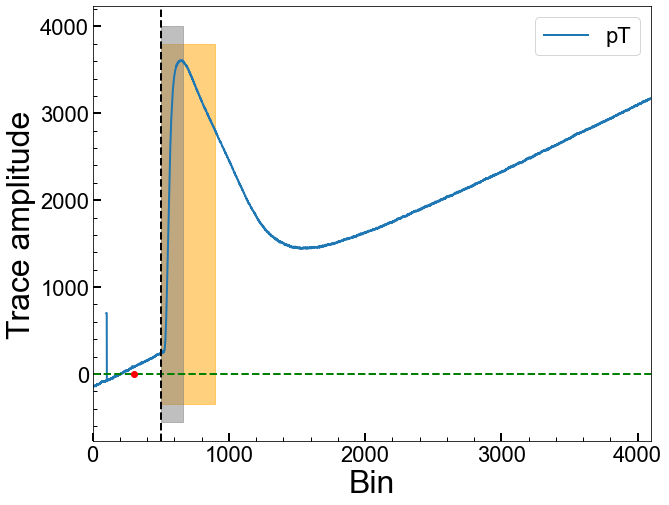

In [7]:
loops = 0
time_reg = []
energies = []
bad=[]
goodevs=[]
plot=True

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                if best_cross<500:
                    bad.append(loops)
                elif (energy<15):
                    goodevs.append(ev)
                    
            if (plot==True) and (getBadBL(exampleObj,ser,ev)) and (energy>30):
                
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1

:)
Series Number: 72209162200
Event Number: 580008
Energy: 33.97321412501 keV


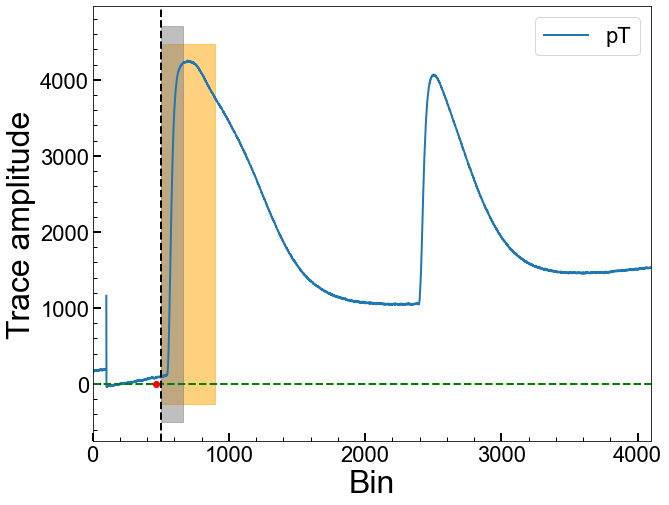

:)
Series Number: 72209162200
Event Number: 580723
Energy: 19.11512774491 keV


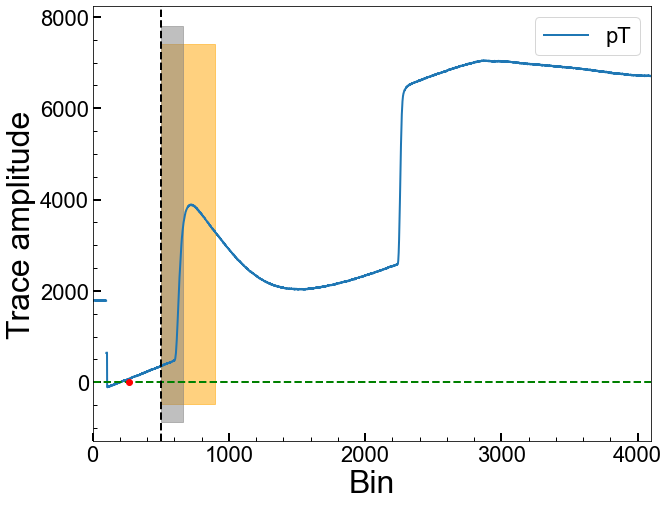

:)
Series Number: 72209162200
Event Number: 650751
Energy: 27.58306035935 keV


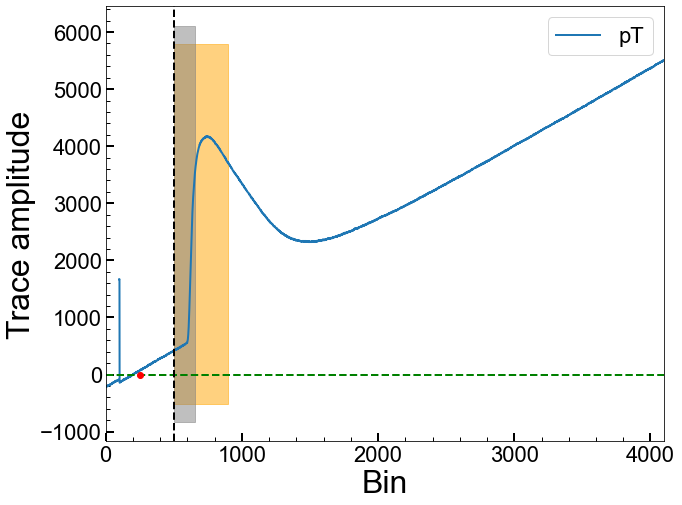

:)
Series Number: 72209162200
Event Number: 930239
Energy: 20.01647378765 keV


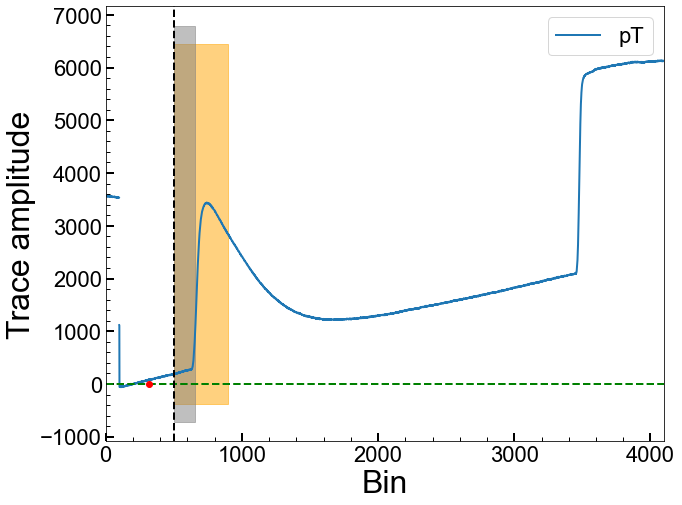

:)
Series Number: 72209162200
Event Number: 1780091
Energy: 22.82722920011 keV


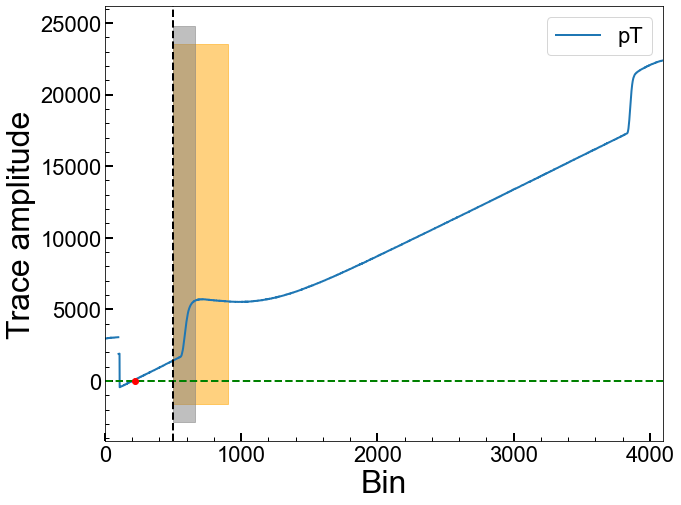

:)
Series Number: 72209162200
Event Number: 1840259
Energy: 21.49664650311 keV


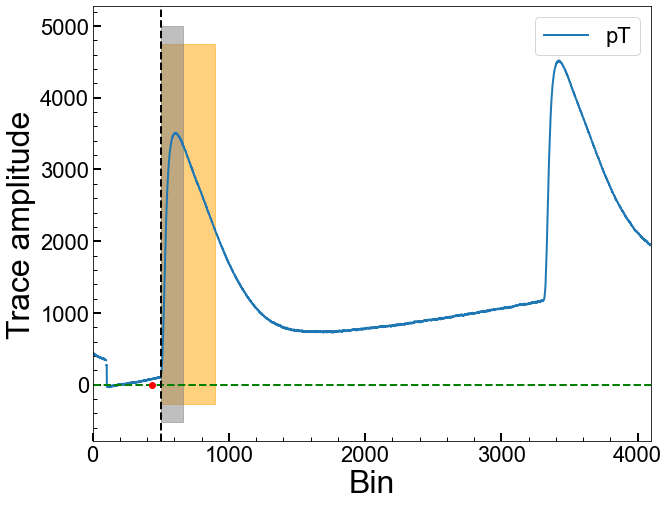

:)
Series Number: 72209162200
Event Number: 2040801
Energy: 16.99229462839 keV


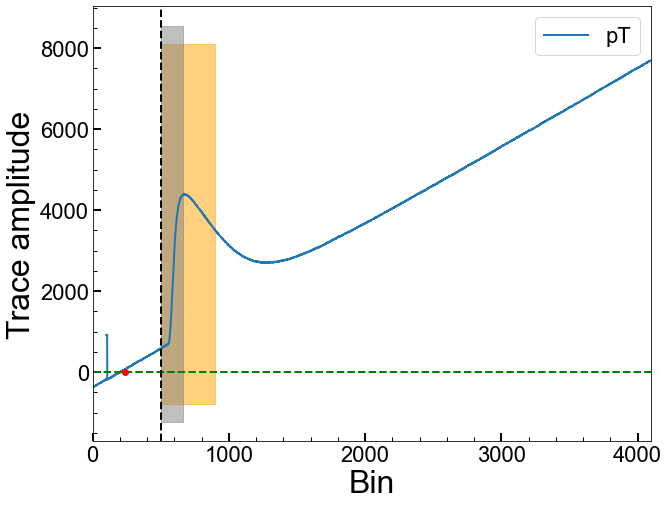

:)
Series Number: 72209162200
Event Number: 2190588
Energy: 19.93073538992 keV


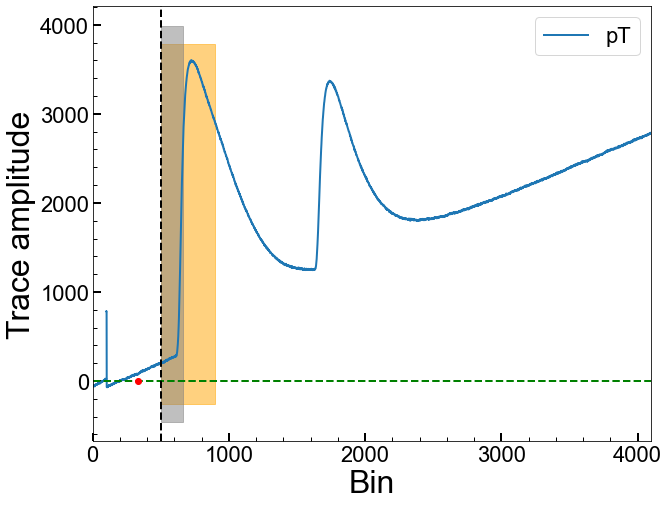

:)
Series Number: 72209162200
Event Number: 2210439
Energy: 23.43612144872 keV


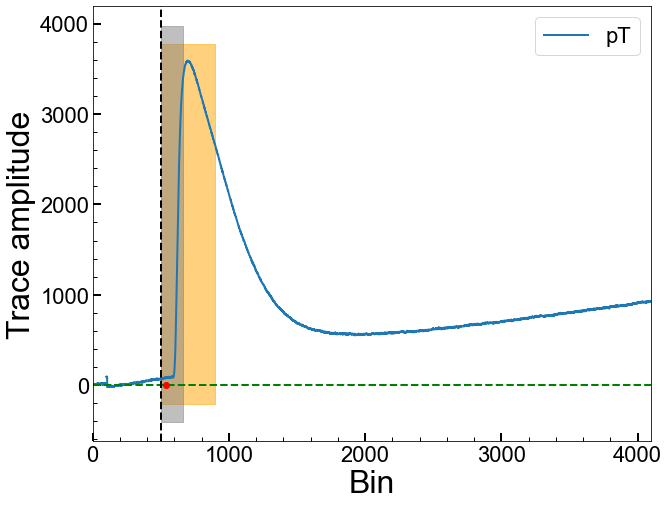

:)
Series Number: 72209162200
Event Number: 2490200
Energy: 24.68465627089 keV


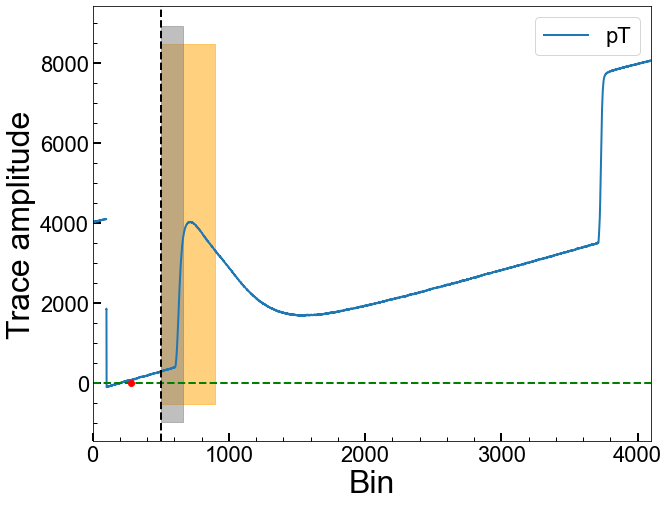

:)
Series Number: 72209162200
Event Number: 2680389
Energy: 2.829655200786 keV


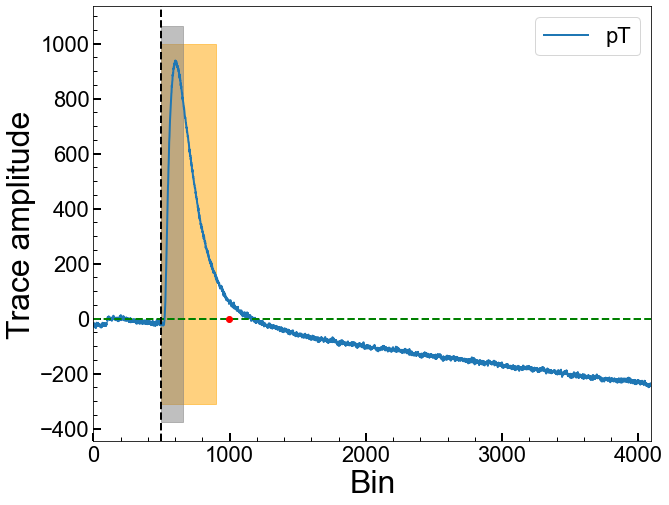

:)
Series Number: 72209162200
Event Number: 3710851
Energy: 33.31666486587 keV


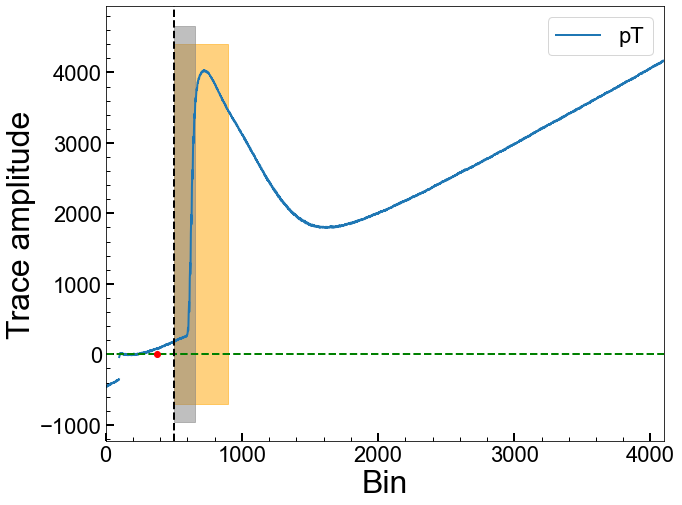

:)
Series Number: 72209162200
Event Number: 3960091
Energy: 17.60991019162 keV


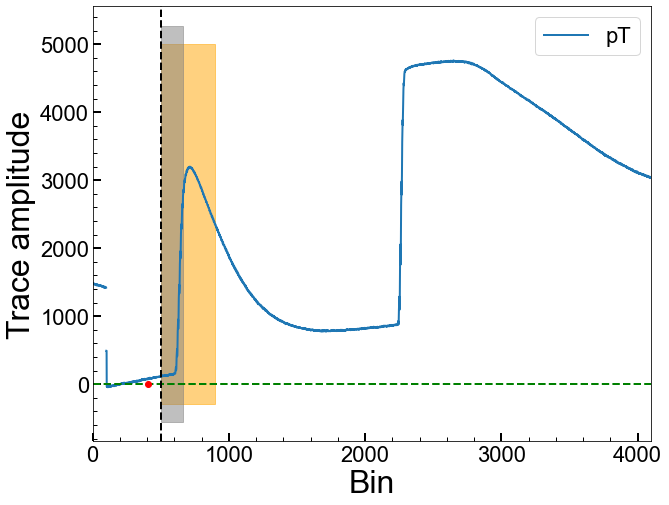

:)
Series Number: 72209162200
Event Number: 4860070
Energy: 2.810942425095 keV


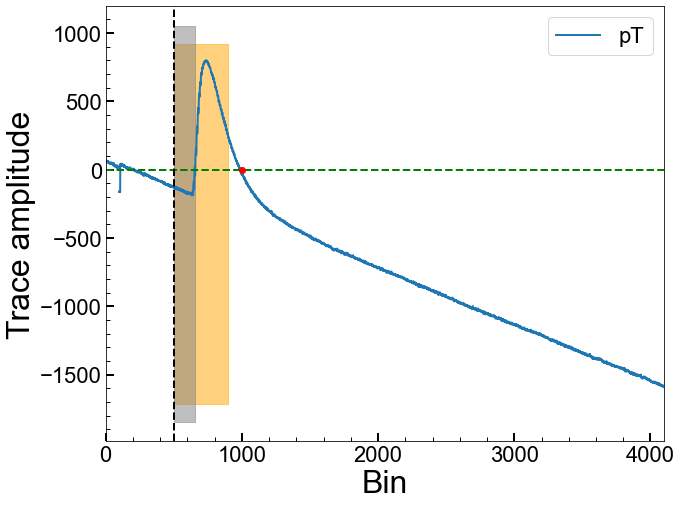

:)
Series Number: 72209171225
Event Number: 1250534
Energy: 5.142703648541 keV


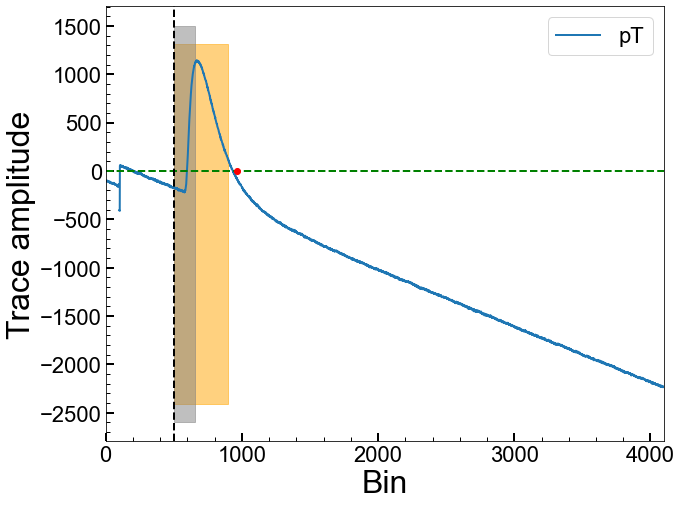

:)
Series Number: 72209172155
Event Number: 390282
Energy: 2.716829541955 keV


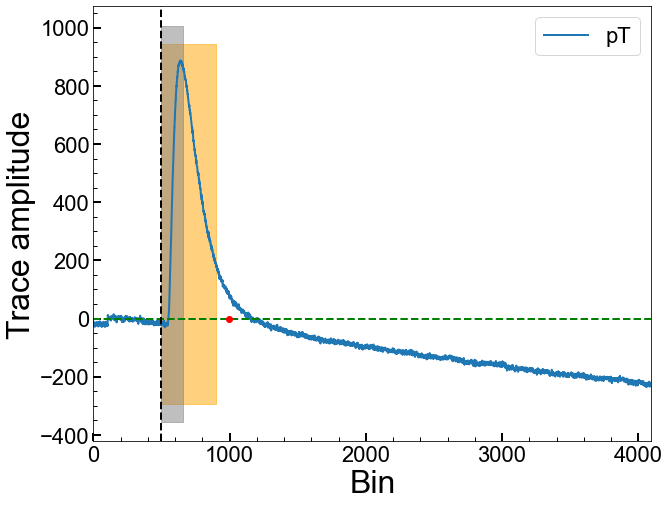

In [8]:
downSlopeBL=[1250534, 2680389, 4860070, 190019, 390282]
upSlopeBL=[580008, 580723, 650751, 930239, 1780091, 1840259, 2040801, 2190588, 2210439, 2490200, 3710851, 3960091]

loops = 0
time_reg = []
energies = []
bad=[]
goodevs=[]
plot=True

for s in pulse_struct:
    ser=int(s.replace('_',''))
    for ev in pulse_struct[s]:
        
        #print(exampleObj['Z1']['PA'][ser,ev])
        energy = getEnergy(ser, ev)
        
        shownpulses=0
        
        #if energy > 51:
        #    continue
        #print(ser)

        #plt.subplot(8,12)
        if(not isRailed(exampleObj['Z1']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PA'][ser,ev],label="pC") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z1']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PB'][ser,ev],label="pF")
        if(not isRailed(exampleObj['Z1']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z1']['PD'][ser,ev],label="pE")
        if(not isRailed(exampleObj['Z3']['PA'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PA'][ser,ev],label="pB") # index 0 corresponds to first event
        if(not isRailed(exampleObj['Z3']['PB'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PB'][ser,ev],label="pA")
        if(not isRailed(exampleObj['Z3']['PD'][ser,ev])):
            shownpulses+=1
            #ax1.plot(exampleObj['Z3']['PD'][ser,ev],label="pD")
            
        pT = getPTPulseCD(exampleObj,ser,ev)+3000
        baseline = getBaseline(pT)
        xB = np.linspace(0, 4095, 4096)
        yB = baseline(xB)
        #print(ser)

        
        #baseline discriminator - weird diagonal pulses
        bshifted_pT = np.subtract(pT,yB)

        if(shownpulses>0):
                        
            crosses = np.isclose(bshifted_pT, 0, atol=75.0) #changed from 250
            
            #t = 0
            #for i in range(0,750):
            #    if (crosses[i] == True):
            #        time_reg.append(i)
            #        #print("Crosses at bin: " + str(i))
            #        energies.append(energy)
                    #t += 1
            #        break
                    
            best_cross = 0
            plot_cross = False
            
            for i in range(0, 1000):
                if (crosses[i] == True):
                    best_cross = i 
                    
            if best_cross != 0:
                time_reg.append(best_cross)
                #print("Crosses at bin: " + str(best_cross))
                energies.append(energy)
                #t += 1
                plot_cross = True
                if best_cross<500:
                    bad.append(loops)
                elif (energy<15):
                    goodevs.append(ev)
                    
            if (plot==True) and ((ev in downSlopeBL) or (ev in upSlopeBL)):
                if getBadBL(exampleObj, ser,ev):
                    print(":)")
                else:
                    print(":(")
                print("Series Number: " + str(ser))
                print("Event Number: " + str(ev))
                print("Energy: " + str(energy) + " keV")
        
                fig,axes = plt.subplots(1,1,figsize=(10.0,8.0),sharex=True)
                ax1 = axes
                
                ax1.plot(bshifted_pT, label="pT")
                #ax1.plot(xB, yB, color='r', linestyle="--", label="baseline")
                plt.axhline(y=0, color='g', linestyle="--")
                
                #ax1.plot((exampleObj['Z4']['PA'][ser,ev]/3)+2900-2650)
                #plt.title('PA')
                ax1.legend(loc=1,prop={'size':22})
                ax1.set_xlim(0,4096)
                ax1.set_xlabel('Bin')
                ax1.set_ylabel('Trace amplitude')
                plt.axvline(x=500,color='k',linestyle="--")
                
                if plot_cross == True:
                    ax1.plot(best_cross, 0, 'ro')
                    
                    fixedWidth=160
                    fixedWidth1=400
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth1, color='orange', alpha=0.5)
                    ax1.fill_betweenx(ax1.get_ylim(), 500, 500+fixedWidth, color='gray', alpha=0.5)

                if shownpulses > 0:
                    #plt.savefig(f'figures/{energy}_keV_pulse.png')
                    plt.show()
                    
            #if t == 0:
            #    time_reg.append(0)
            
            loops += 1